# Melk: What happens here?
Based on pymc-marketing example notebook (02_mmm_example.ipynb)

## Changes
- Change to days rather than weeks
- Remove control, seasonality, trend
- Add dayofweek control

(mmm_example)=
# MMM Example Notebook

In this notebook we work out a simulated example to showcase the media mix Model (MMM) API from `pymc-marketing`. This package provides a `pymc` implementation of the MMM presented in the paper [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017)](https://research.google/pubs/pub46001/). We work with synthetic data as we want to do *parameter recovery* to better understand the model assumptions. That is, we explicitly set values for our adstock and saturation parameters (see model specification below) and recover them back from the model. The data generation process is as an adaptation of the blog post ["Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns"](https://juanitorduz.github.io/pymc_mmm/) by [Juan Orduz](https://juanitorduz.github.io/).

## Business Problem

Before jumping into the data, let's first define the business problem we are trying to solve. We are a marketing agency and we want to optimize the marketing budget of a client. We have access to the following data:

- Sales data: weekly sales of the client.
- Media spend data: weekly spend on different media channels (e.g. TV, radio, online, etc.). In ths example we consider 2 media channels: $x_{1}$ and $x_{2}$.
- Domain knowledge: 
  - We know that there has a been an positive sales trend which we believe comes from a strong economic growth.
  - We also know that there is a yearly seasonality effect.
  - In addition, we were informed about two outliers in the data during the weeks `2019-05-13` and `2021-09-14`.

What do we mean by optimize the marketing budget? We want to find the optimal media mix that maximizes sales. In order to do so, we need to understand the mechanism in which the media spend for each channel affects sales. In other words, we need to understand the media contribution. The main challenge is that the direct cost signal does not translate into a linear contribution. For example, a $10\%$ increase in channel $x_{1}$ spend does not necessarily translate into a $10\%$ increase in sales. This can be explained by two phenomena

1. On the one hand side, there is a carry-over effect. That is, the effect of spend on sales is not instantaneous but accumulates over time.
2. In addition, there is a saturation effect. That is, the effect of spend on sales is not linear but saturates at some point.

In this example we will illustrate how we can use `pymc-marketing` to model these effects.

In the next section we describe a general framework for modeling media effects.

## Model Specification

In `pymc-marketing` we provide an API for a Bayesian media mix model (MMM) specification following [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017)](https://research.google/pubs/pub46001/) as a base model. Concretely, given a time series target variable $y_{t}$ (e.g. sales or conversions), media variables $x_{m, t}$ (e.g. impressions, clicks or costs) and a set of control covariates $z_{c, t}$ (e.g. holidays, special events) we consider a linear model of the form 

$$
y_{t} = \alpha + \sum_{m=1}^{M}\beta_{m}f(x_{m, t}) +  \sum_{c=1}^{C}\gamma_{c}z_{c, t} + \varepsilon_{t},
$$

where $\alpha$ is the intercept, $f$ is a media transformation function and $\varepsilon_{t}$ is the error therm which we assume is normally distributed. The function $f$ encodes the contribution of media on the target variable. Typically we consider two types of transformation: adstock (carry-over) and saturation effects.

```{tip}
The MMM model in `pymc-marketing` provides additional features on top of this base model:

- **Experiment Calibration**: We have the option to add empirical experiments (lift tests) to calibrate the model using custom likelihood functions. See {ref}`mmm_lift_test`.

- **Time-varying Intercept:** Capture time-varying baseline contributions in your model (using modern and efficient Gaussian processes approximation methods). That is, we allow the intercept term $\alpha = \alpha(t)$ to vary over time. See {ref}`mmm_tvp_example`.

- **Budget Optimization:** Allocate your marketing budget based on the parameters recover by the model, finding the spend distribution to maximizes the amount of contribution given a limited budget. See {ref}`mmm_budget_allocation_example`.
```

### References:

- [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017).](https://research.google/pubs/pub46001/)
- PyMC Labs Blog:
  - [Bayesian Media Mix Modeling for Marketing Optimization](https://www.pymc-labs.io/blog-posts/bayesian-media-mix-modeling-for-marketing-optimization/)
  - [Improving the Speed and Accuracy of Bayesian Media Mix Models](https://www.pymc-labs.io/blog-posts/reducing-customer-acquisition-costs-how-we-helped-optimizing-hellofreshs-marketing-budget/)
- [Johns, Michael and Wang,  Zhenyu. "A Bayesian Approach to Media Mix Modeling"](https://www.youtube.com/watch?v=UznM_-_760Y)
- [Orduz, Juan. "Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns"](https://juanitorduz.github.io/pymc_mmm/)

---

## Part I: Data Generation Process

In Part I of this notebook we focus on the data generating process. That is, we want to construct the target variable $y_{t}$ (sales) by adding each of the components described in the *Business Problem* section.

## Prepare Notebook

In [83]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm.delayed_saturated_mmm import MMM
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
LOAD_FROM_DISK = True
# set filename to current filename
model_name = "02_mmm_example.savedmodel"

## Generate Data

### 1. Date Range

First we set a time range for our data. We consider a bit more than 2 years of data at weekly granularity.

In [85]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2024-01-01")
max_date = pd.to_datetime("2024-05-30")

df = pd.DataFrame(
    data={"date": pd.date_range(start=min_date, end=max_date, freq="D")}
).assign(
    year=lambda x: x["date"].dt.year,
    month=lambda x: x["date"].dt.month,
    dayofyear=lambda x: x["date"].dt.dayofyear,
    dayofweek=lambda x: x["date"].dt.dayofweek, # Monday=0, Sunday=6
)

n = df.shape[0]
print(f"Number of observations: {n}")
df

Number of observations: 151


date  year  month  dayofyear  dayofweek
0   2024-01-01  2024      1          1          0
1   2024-01-02  2024      1          2          1
2   2024-01-03  2024      1          3          2
3   2024-01-04  2024      1          4          3
4   2024-01-05  2024      1          5          4
..         ...   ...    ...        ...        ...
146 2024-05-26  2024      5        147          6
147 2024-05-27  2024      5        148          0
148 2024-05-28  2024      5        149          1
149 2024-05-29  2024      5        150          2
150 2024-05-30  2024      5        151          3

[151 rows x 5 columns]

### 2. Media Costs Data

Now we generate synthetic data from two channels $x_1$ and $x_2$. We refer to it as the raw signal as it is going to be the input at the modeling phase. We expect the contribution of each channel to be different, based on the carryover and saturation parameters.

- Raw Signal

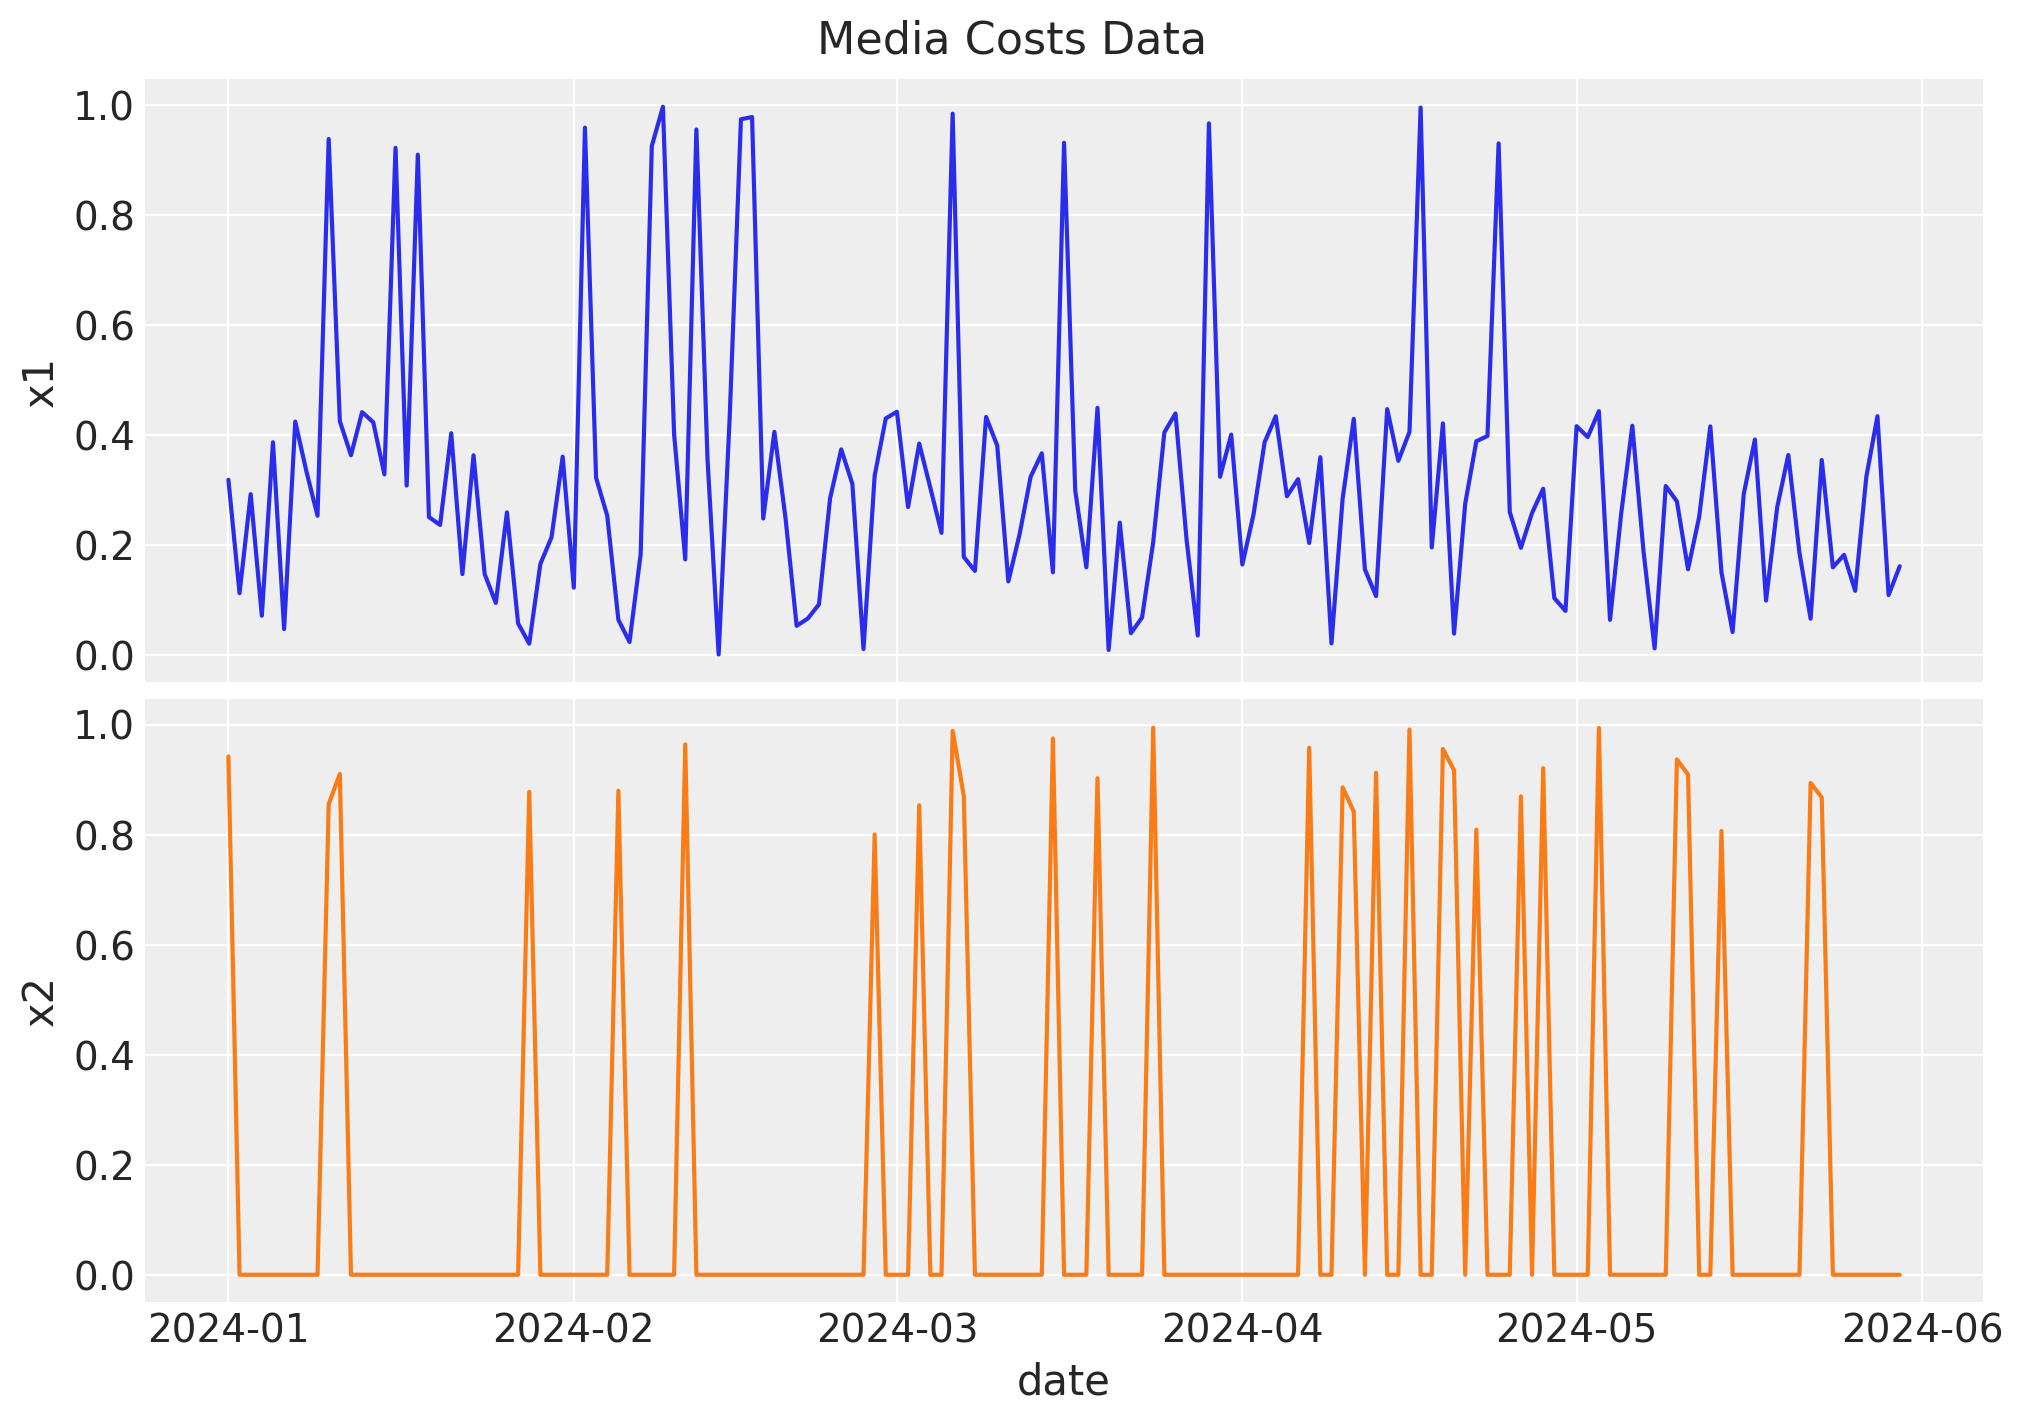

In [86]:
# media data
x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)


fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date", y="x1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date", y="x2", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

**Remark:** By design, $x_{1}$ should resemble a typical paid social channel and $x_{2}$ a offline (e.g. TV) spend time series.

- Effect Signal

Next, we pass the raw signal through the two transformations: first the geometric adstock (carryover effect) and then the logistic saturation. Note that we set the parameters ourselves, but we will recover them back from the model.

Let's start with the adstock transformation. We set the adstock parameter $0 < \alpha < 1$ to be $0.4$ and $0.2$ for $x_1$ and $x_2$ respectively. We set a maximum lag effect of $8$ weeks.

In [87]:
# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

df["x1_adstock"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
    .eval()
    .flatten()
)

Next, we compose the resulting adstock signals with the logistic saturation function. We set the parameter $\lambda > 0$ to be $4$ and $3$ for $z_1$ and $z_2$ respectively.

In [88]:
# apply saturation transformation
lam1: float = 4.0
lam2: float = 3.0

df["x1_adstock_saturated"] = logistic_saturation(
    x=df["x1_adstock"].to_numpy(), lam=lam1
).eval()

df["x2_adstock_saturated"] = logistic_saturation(
    x=df["x2_adstock"].to_numpy(), lam=lam2
).eval()

We can now visualize the effect signal for each channel after each transformation:

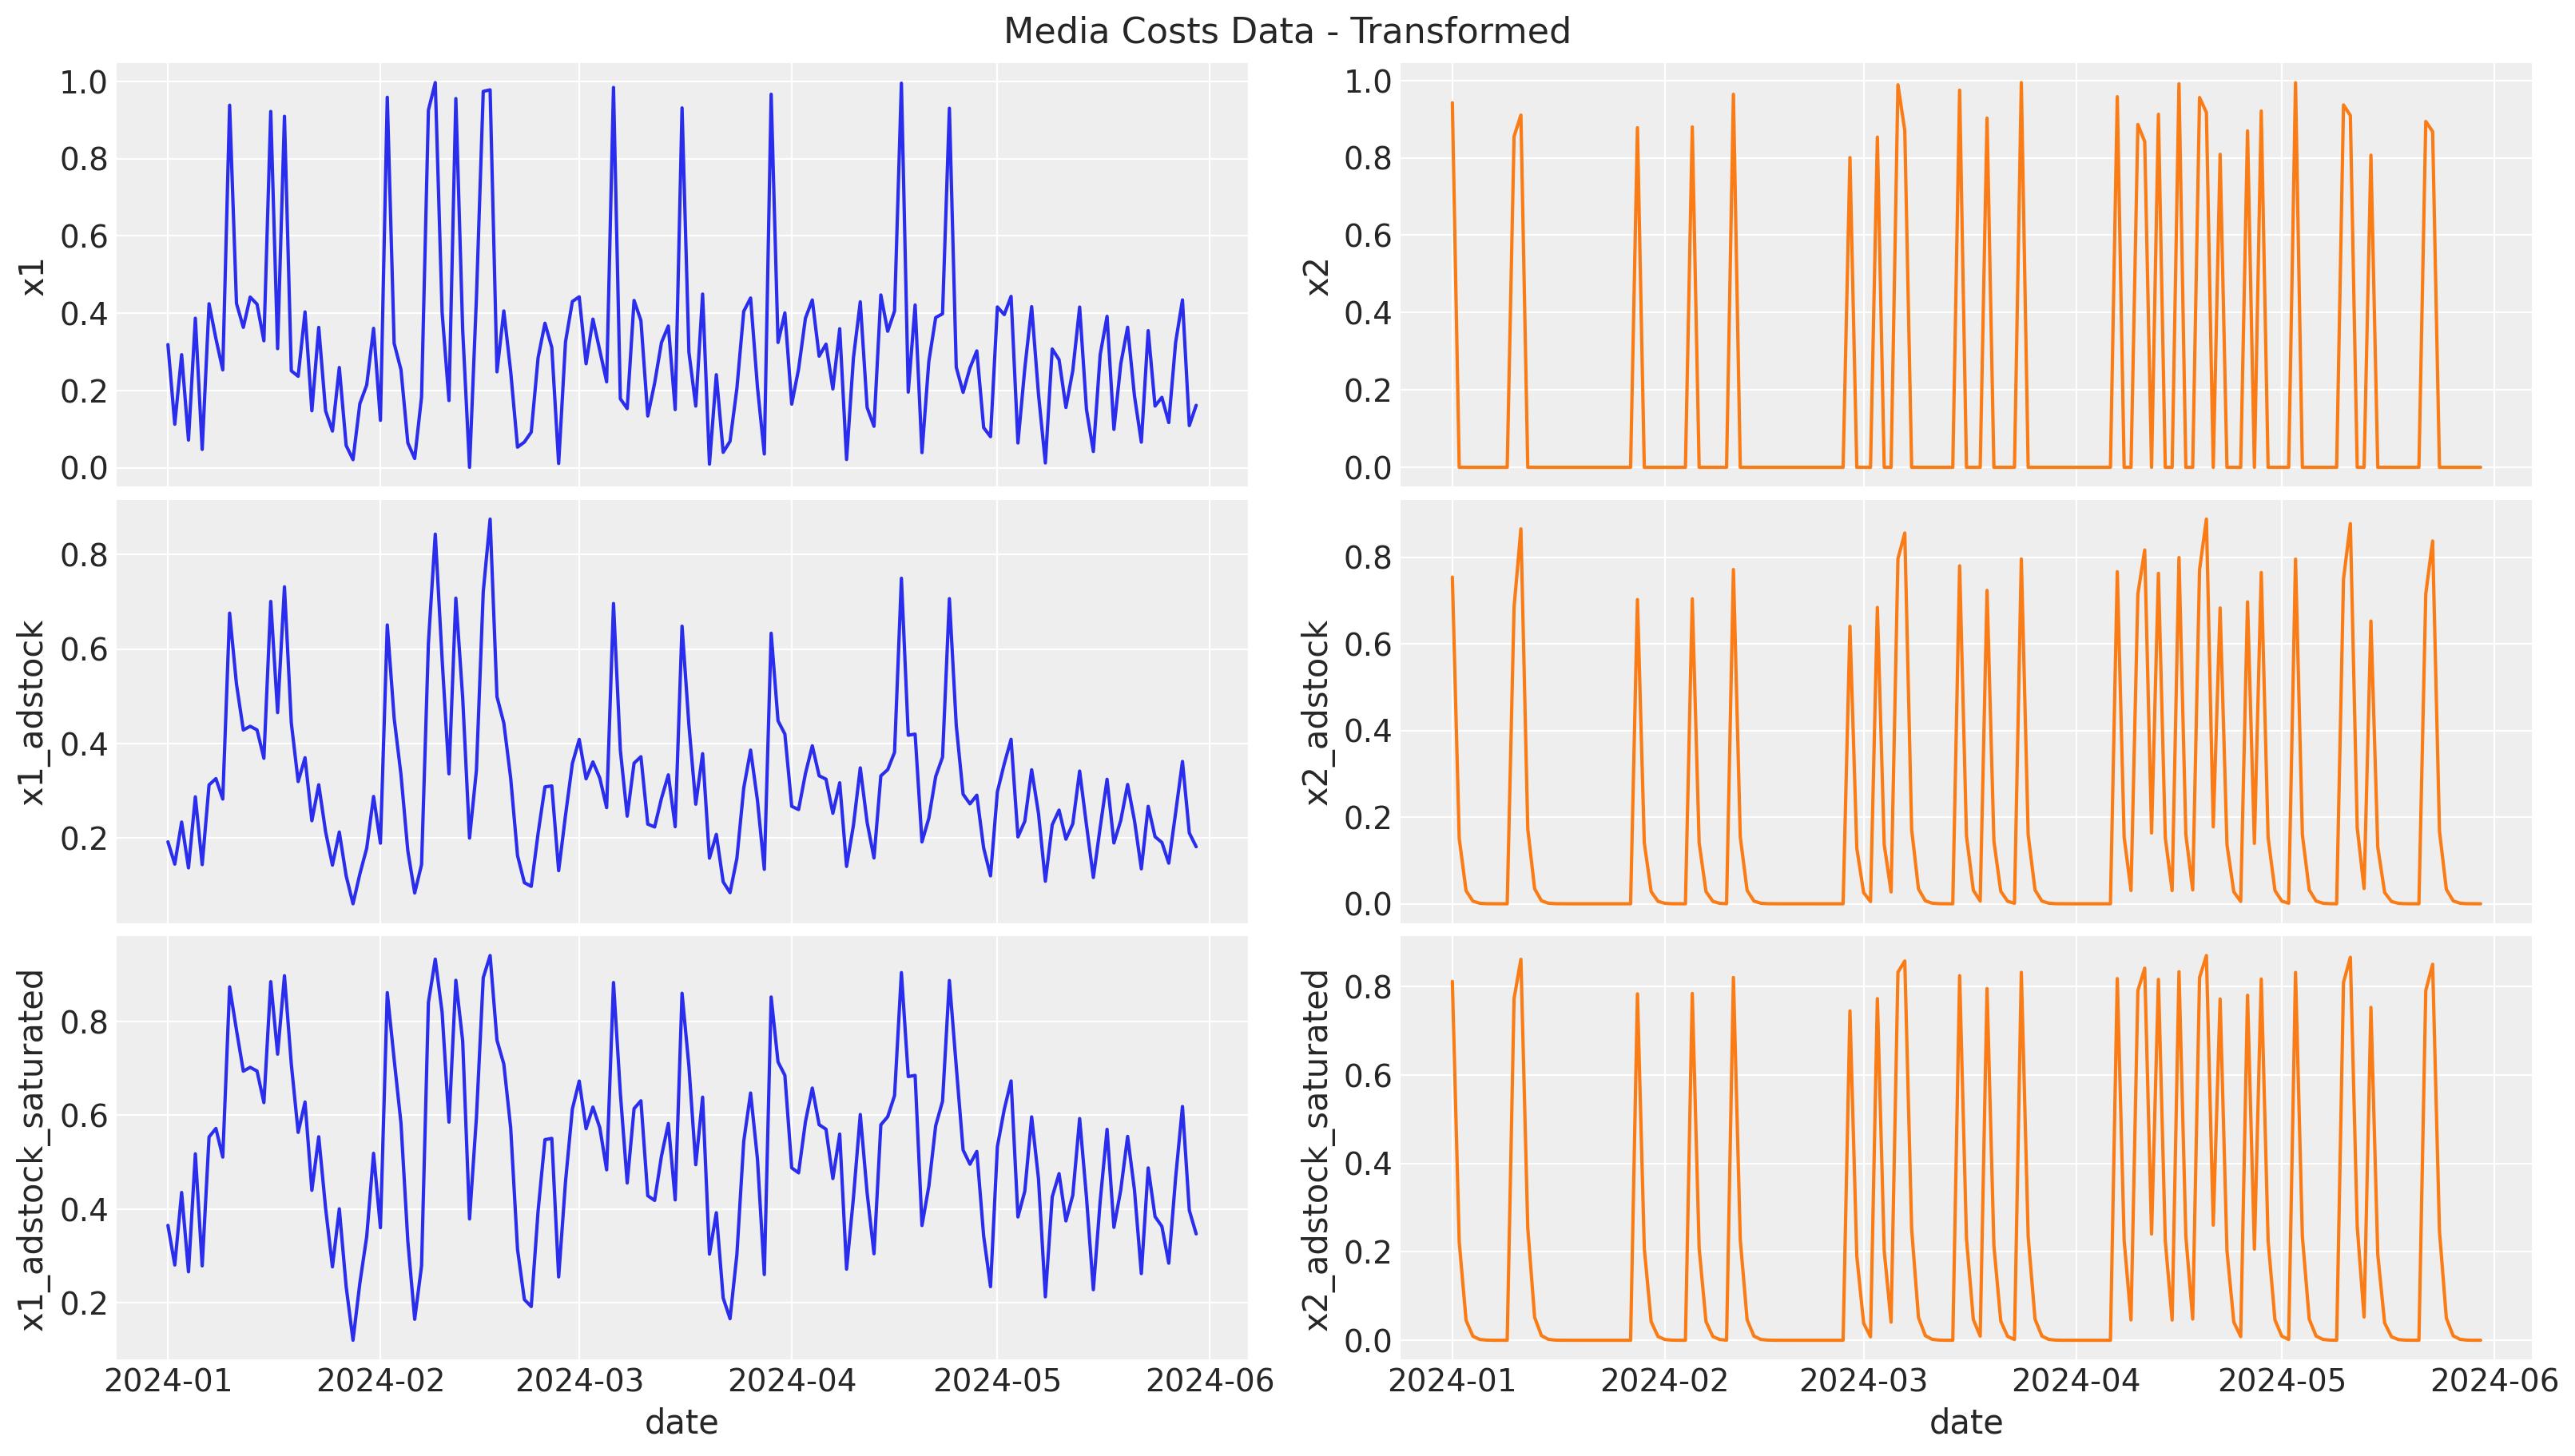

In [89]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date", y="x1", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date", y="x2", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date", y="x1_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date", y="x2_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date", y="x1_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date", y="x2_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16);

### 3. Trend \& Seasonal Components

Now we add synthetic trend and seasonal components to the effect signal.

In [90]:
# df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

# df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
# df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
# df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

# fig, ax = plt.subplots()
# sns.lineplot(x="date", y="trend", color="C2", label="trend", data=df, ax=ax)
# sns.lineplot(
#     x="date", y="seasonality", color="C3", label="seasonality", data=df, ax=ax
# )
# ax.legend(loc="upper left")
# ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None);

### 3.1 Weekday Components

In [91]:
# Extra sales on Mon to Sat - Sun is the base and goes into intercept
dayofweek_beta = [1.5, 0.5, 0.5, 1.0, 0.5, 0.5] 
# set mean effect to zero
dayofweek_beta = np.array(dayofweek_beta) - np.mean(dayofweek_beta)

def add_dayofweek(df: pd.DataFrame) -> pd.DataFrame:
    df["dayofweek"] = df.assign(dayofweek=lambda x: x["date"].dt.dayofweek)["dayofweek"]
    for dayofweek in range(6):
        df[f"dayofweek_{dayofweek}"] = np.where(df["dayofweek"] == dayofweek, 1, 0)
    return df

In [92]:

df = add_dayofweek(df)

# define list of dayofweek variables for later use
control_dayofweek = [f"dayofweek_{dayofweek}" for dayofweek in range(6)]

dayofweek_beta

array([ 0.75, -0.25, -0.25,  0.25, -0.25, -0.25])

### 4. Control Variables

We add two *events* where there was a remarkable peak in our target variable. We assume they are independent an not seasonal (e.g. launch of a particular product). 

In [11]:
# df["event_1"] = (df["date"] == "2019-05-13").astype(float)
# df["event_2"] = (df["date"] == "2020-09-14").astype(float)

### 5. Target Variable

Finally, we define the target variable (sales) $y$. We assume it is a linear combination of the effect signal, the trend and the seasonal components, plus the two events and an intercept. We also add some Gaussian noise.

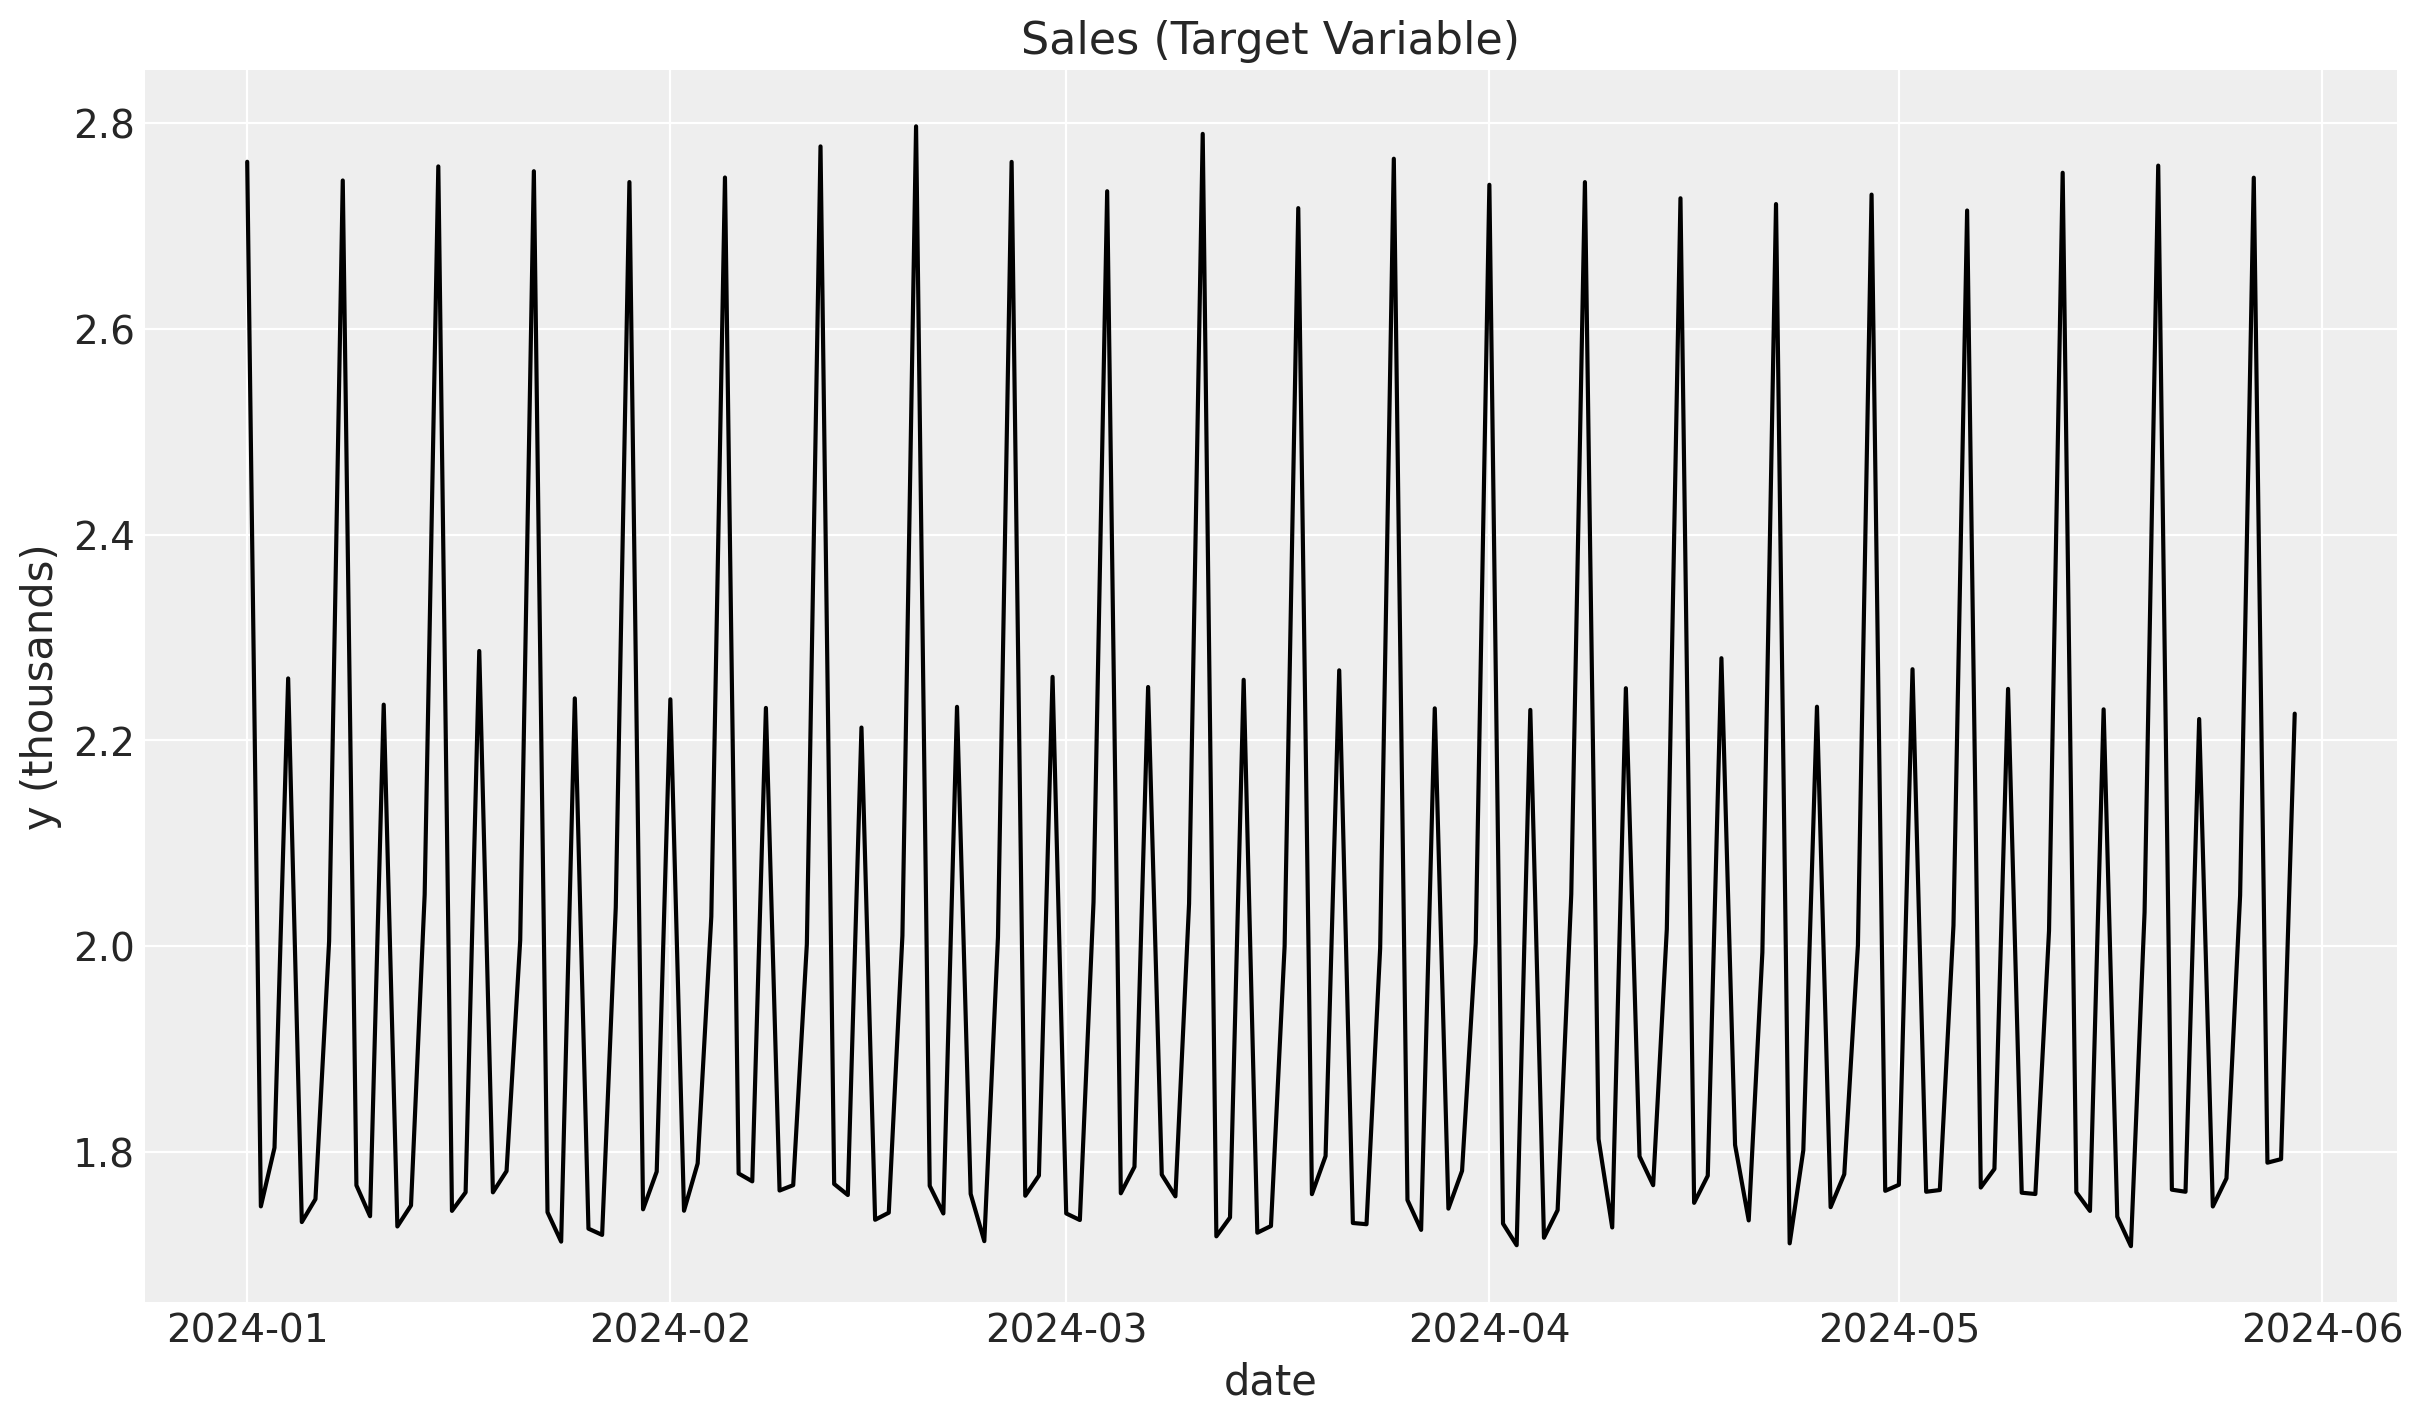

In [12]:
suppress_non_weekday = 0.001

df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.025, size=n)

amplitude = 1
beta_1 = 3.0
beta_2 = 2.0
betas = [beta_1, beta_2]

df["y"] = (
    df["intercept"] 
    # + df["trend"]
    # + df["seasonality"]
    # + 1.5 * df["event_1"]
    # + 2.5 * df["event_2"]
    + beta_1 * df["x1_adstock_saturated"] * suppress_non_weekday
    + beta_2 * df["x2_adstock_saturated"] * suppress_non_weekday
    + df["epsilon"] 


) * amplitude 

# add day of week effect
df["dayofweek_effect"] = df["y"] * 0
for dayofweek in range(6):
    effect = df[f"dayofweek_{dayofweek}"] * dayofweek_beta[dayofweek] 
    df["dayofweek_effect"] = df["dayofweek_effect"] + effect

df["dayofweek_effect"] = df["dayofweek_effect"] * amplitude

df["y"] = df["y"] + df["dayofweek_effect"] 
df


fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y (thousands)");

We can visualize the true component contributions over the historical period:

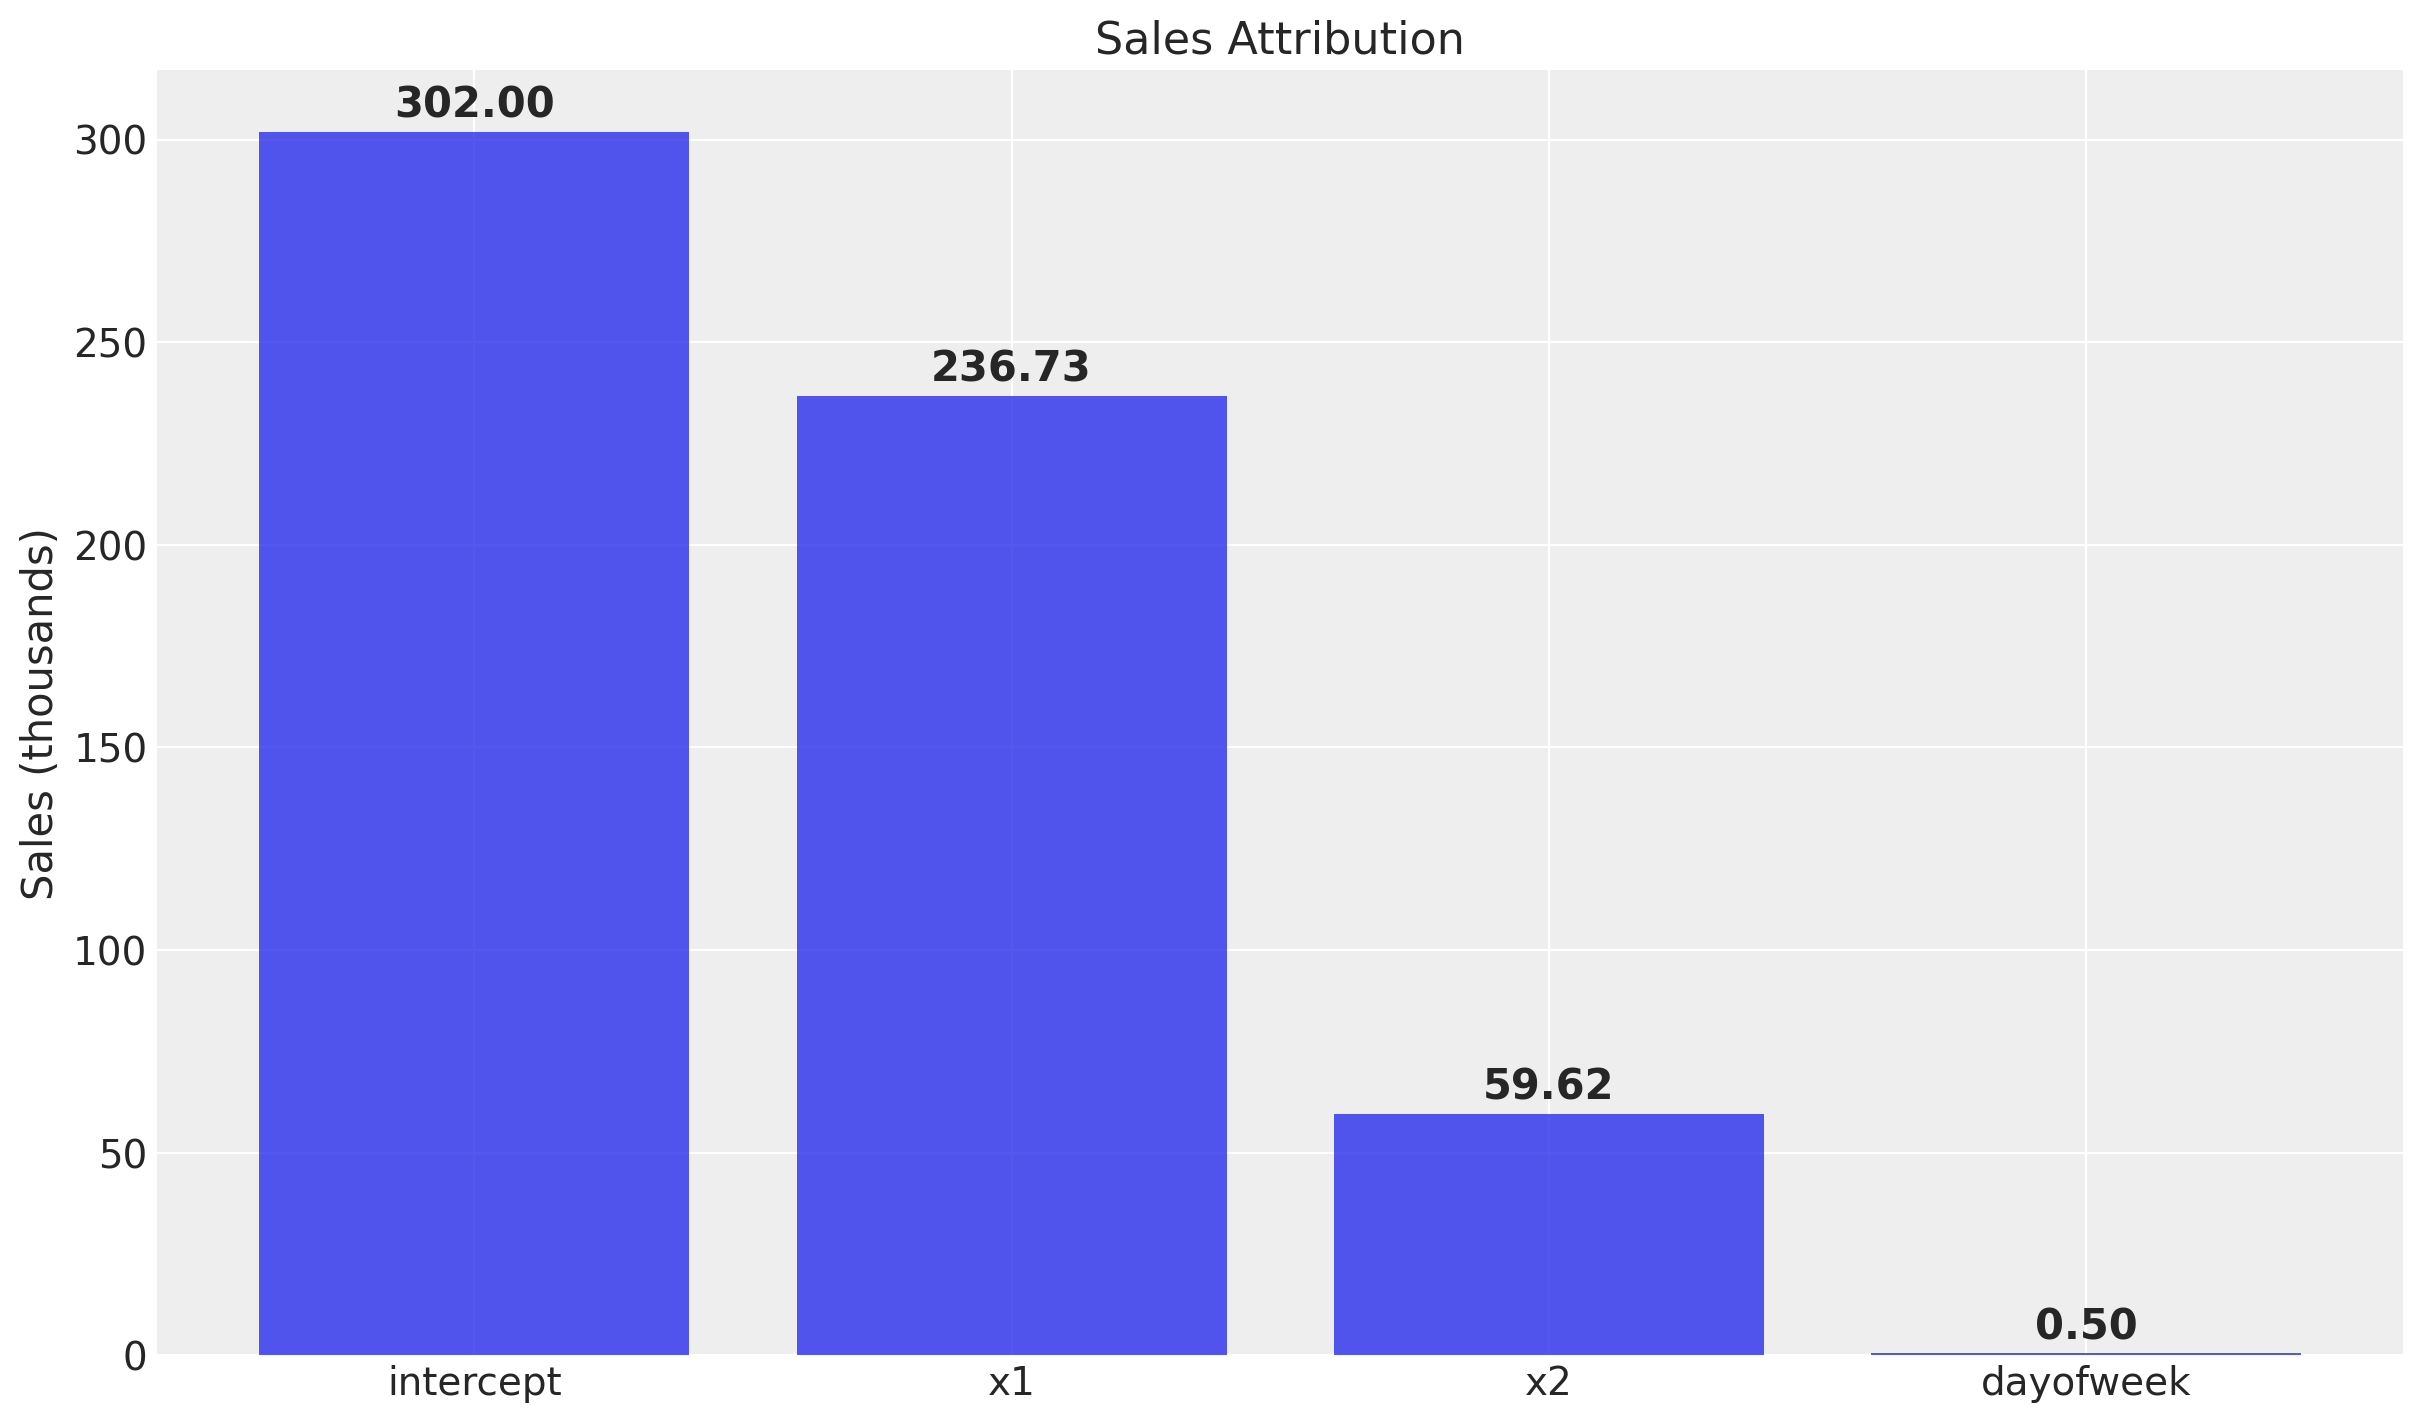

In [13]:
fig, ax = plt.subplots()

contributions = [
    df["intercept"].sum(),
    (beta_1 * df["x1_adstock_saturated"]).sum(),
    (beta_2 * df["x2_adstock_saturated"]).sum(),
    # 1.5 * df["event_1"].sum(),
    # 2.5 * df["event_2"].sum(),
    # df["trend"].sum(),
    # df["seasonality"].sum(),
    df["dayofweek_effect"].sum(),
]

ax.bar(
    ["intercept", "x1", "x2", "dayofweek"], #, "event_1", "event_2", "trend", "seasonality"],
    contributions,
    color=["C0" if x >= 0 else "C3" for x in contributions],
    alpha=0.8,
)
ax.bar_label(
    ax.containers[0],
    fmt="{:,.2f}",
    label_type="edge",
    padding=2,
    fontsize=15,
    fontweight="bold",
)
ax.set(title="Sales Attribution", ylabel="Sales (thousands)");

We would like to recover these values from the model.

### 6. Media Contribution Interpretation

From the data generating process we can compute the relative contribution of each channel to the target variable. We will recover these values back from the model.

In [14]:
contribution_share_x1: float = (beta_1 * df["x1_adstock_saturated"]).sum() / (
    beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]
).sum()

contribution_share_x2: float = (beta_2 * df["x2_adstock_saturated"]).sum() / (
    beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]
).sum()

print(f"Contribution Share of x1: {contribution_share_x1:.2f}")
print(f"Contribution Share of x2: {contribution_share_x2:.2f}")

Contribution Share of x1: 0.80
Contribution Share of x2: 0.20


We can obtain the contribution plots for each channel where we clearly see the effect of the adstock and saturation transformations.

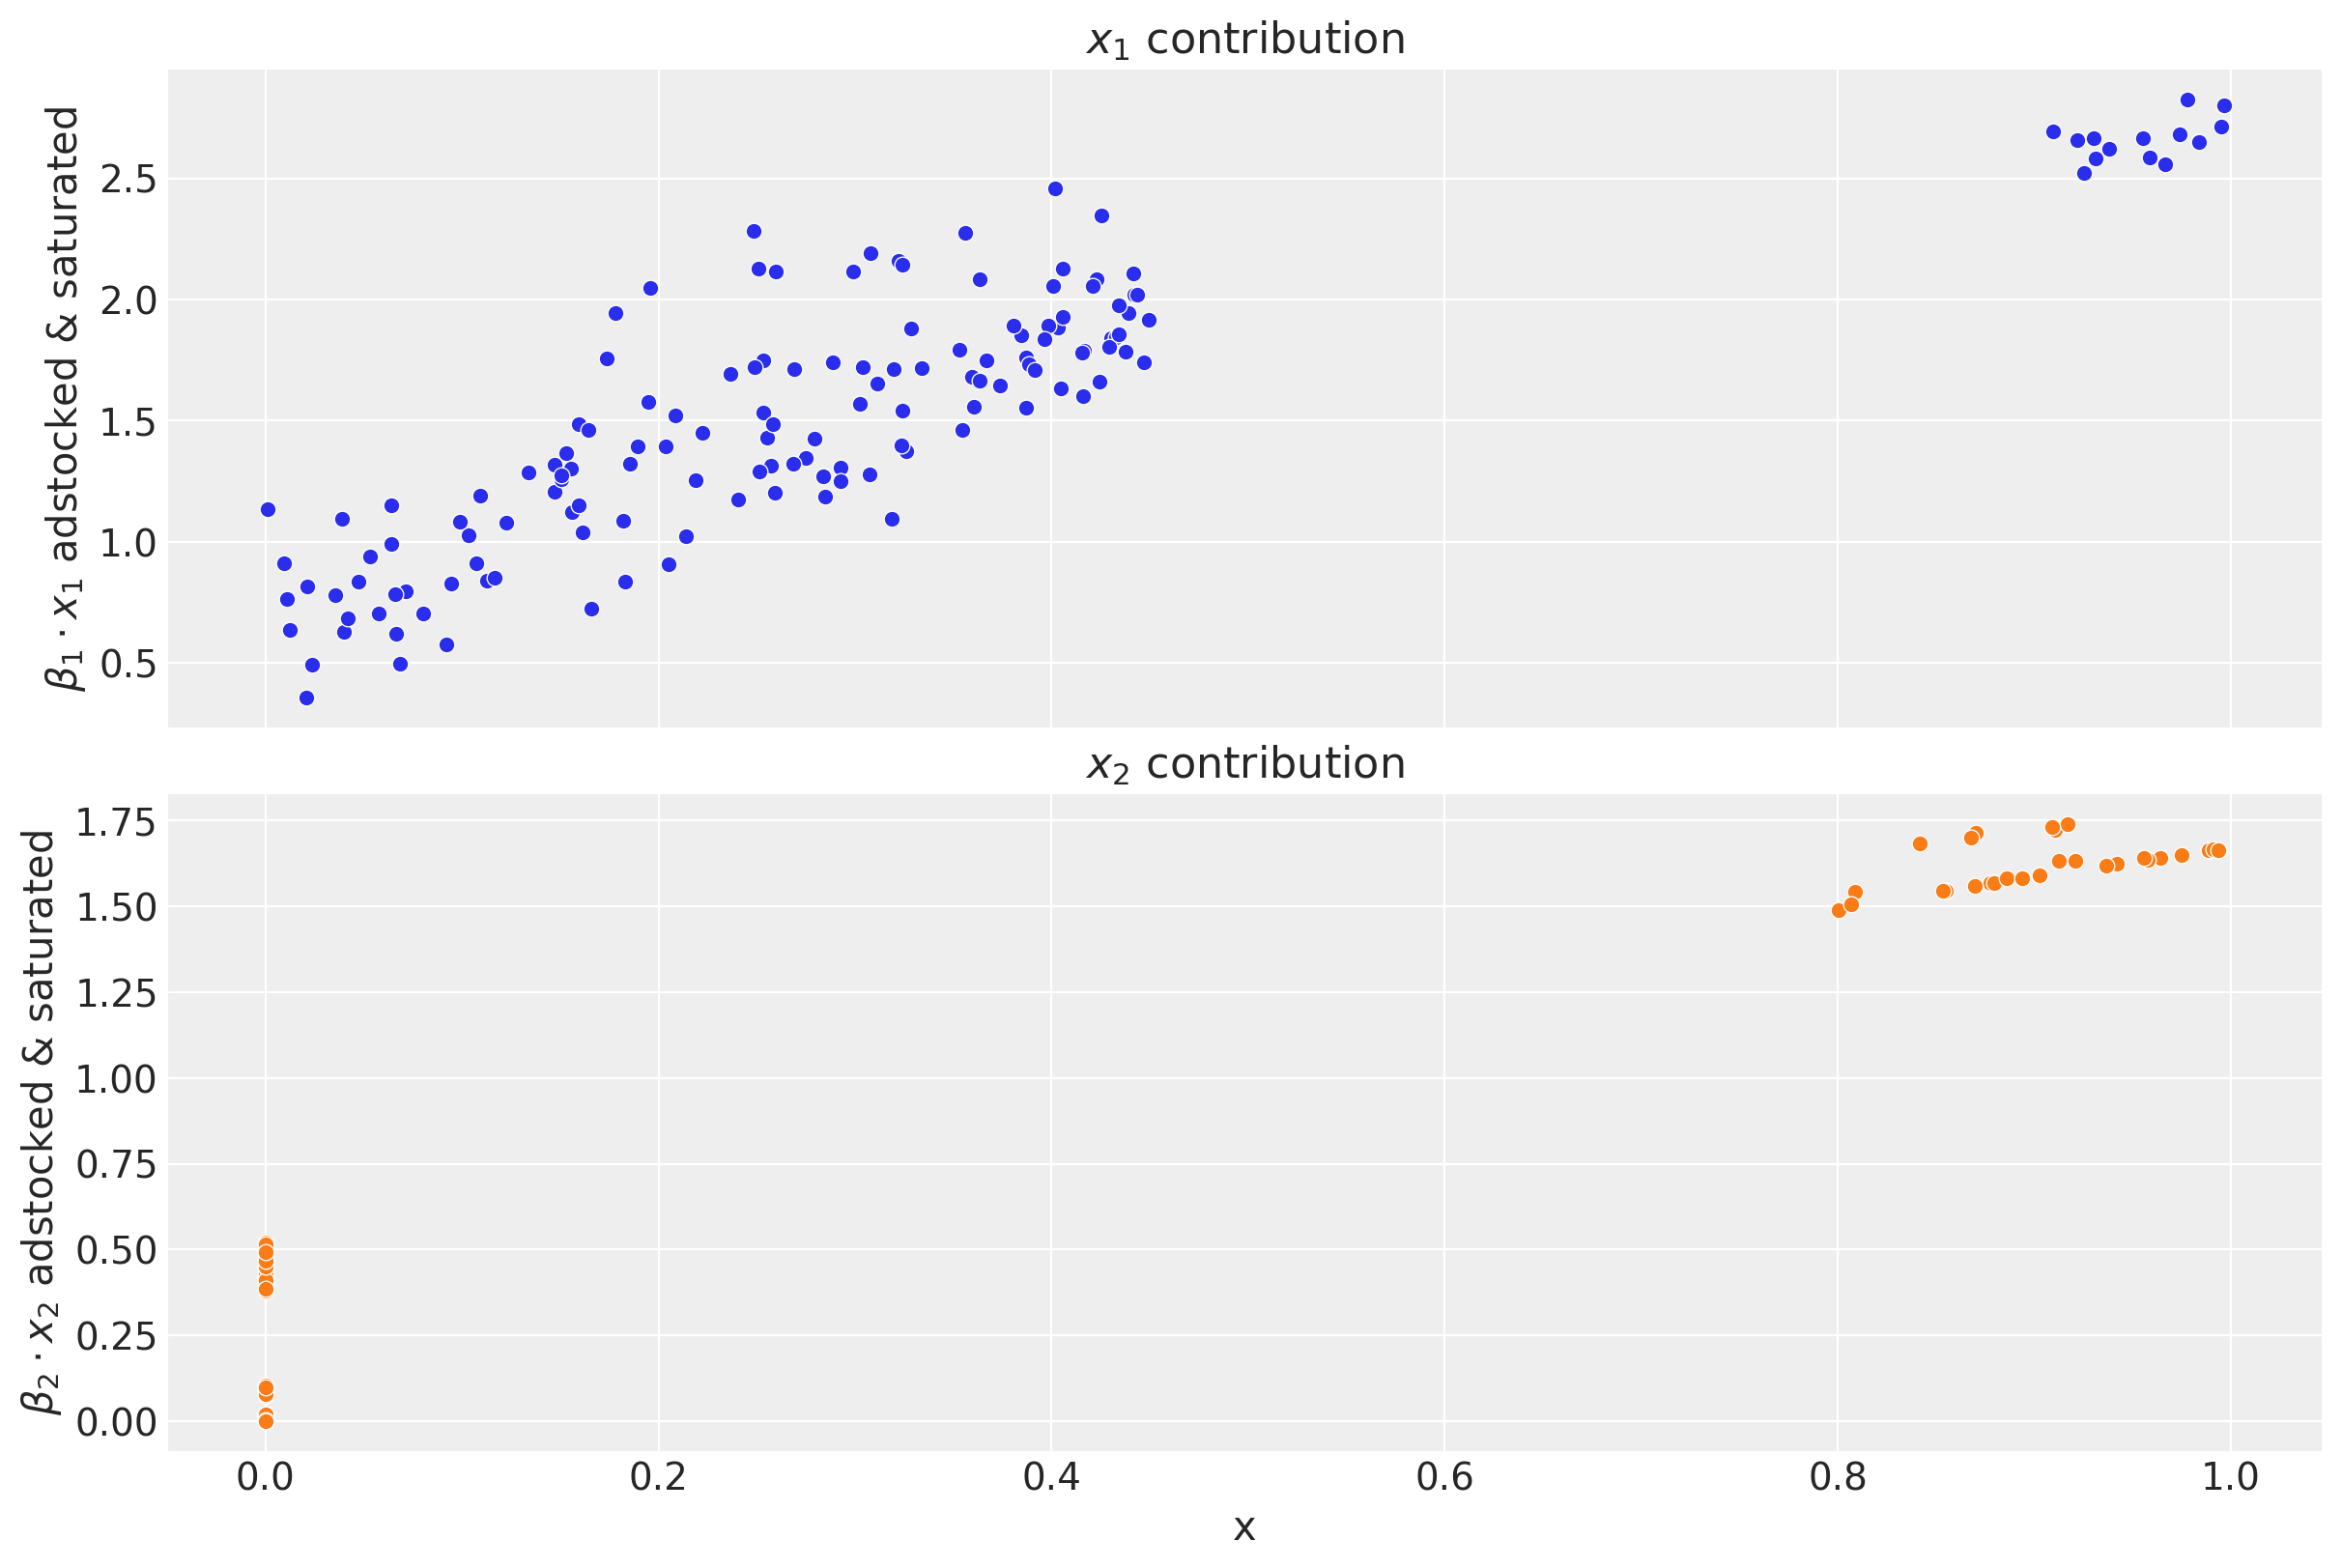

In [15]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 8), sharex=True, sharey=False, layout="constrained"
)

for i, x in enumerate(["x1", "x2"]):
    sns.scatterplot(
        x=df[x],
        y=amplitude * betas[i] * df[f"{x}_adstock_saturated"],
        color=f"C{i}",
        ax=ax[i],
    )
    ax[i].set(
        title=f"$x_{i + 1}$ contribution",
        ylabel=f"$\\beta_{i + 1} \\cdot x_{i + 1}$ adstocked & saturated",
        xlabel="x",
    )

This plot shows some interesting aspects of the media contribution: 

- The adstock effect is reflected in the non-zero contribution of the channel even when the spend is zero.
- One clearly see the saturation effect as the contribution growth (slope) decreases as the spend increases.

As we will see in Part II of this notebook, we will recover these plots from the model!

We see that channel $x_{1}$ has a higher contribution than $x_{2}$. This could be explained by the fact that there was more spend in channel  $x_{1}$ than in channel $x_{2}$:

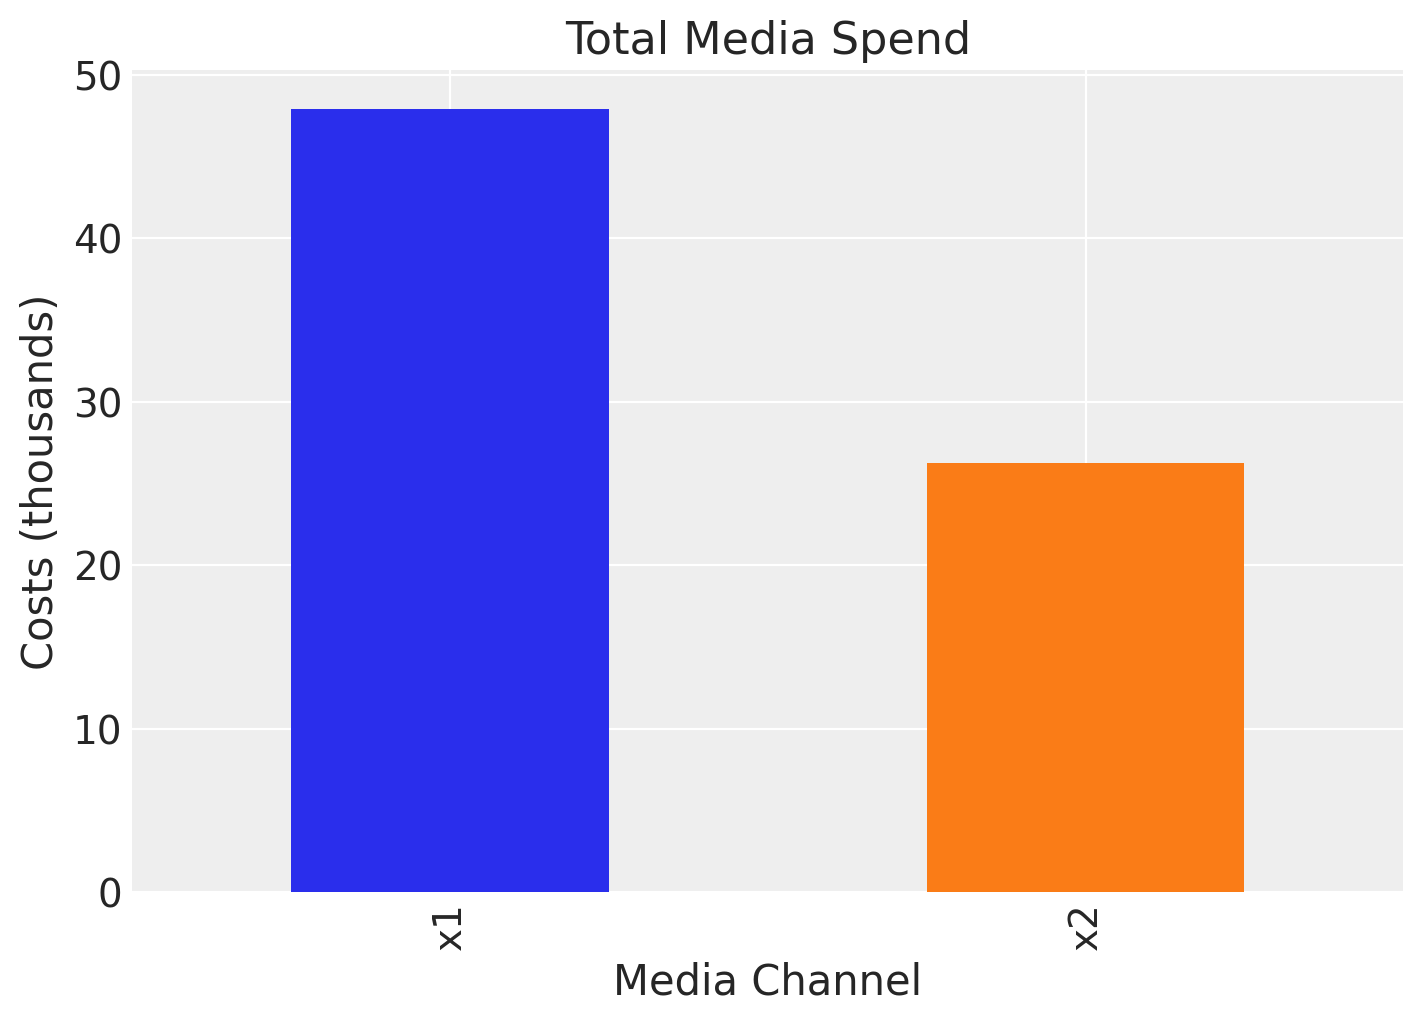

In [16]:
fig, ax = plt.subplots(figsize=(7, 5))
df[["x1", "x2"]].sum().plot(kind="bar", color=["C0", "C1"], ax=ax)
ax.set(title="Total Media Spend", xlabel="Media Channel", ylabel="Costs (thousands)");

However, one usually is not only interested in the contribution itself but rather the Return on Ad Spend (ROAS). That is, the contribution divided by the cost. We can compute the ROAS for each channel as follows:

In [17]:
roas_1 = (amplitude * beta_1 * df["x1_adstock_saturated"]).sum() / df["x1"].sum()
roas_2 = (amplitude * beta_2 * df["x2_adstock_saturated"]).sum() / df["x2"].sum()

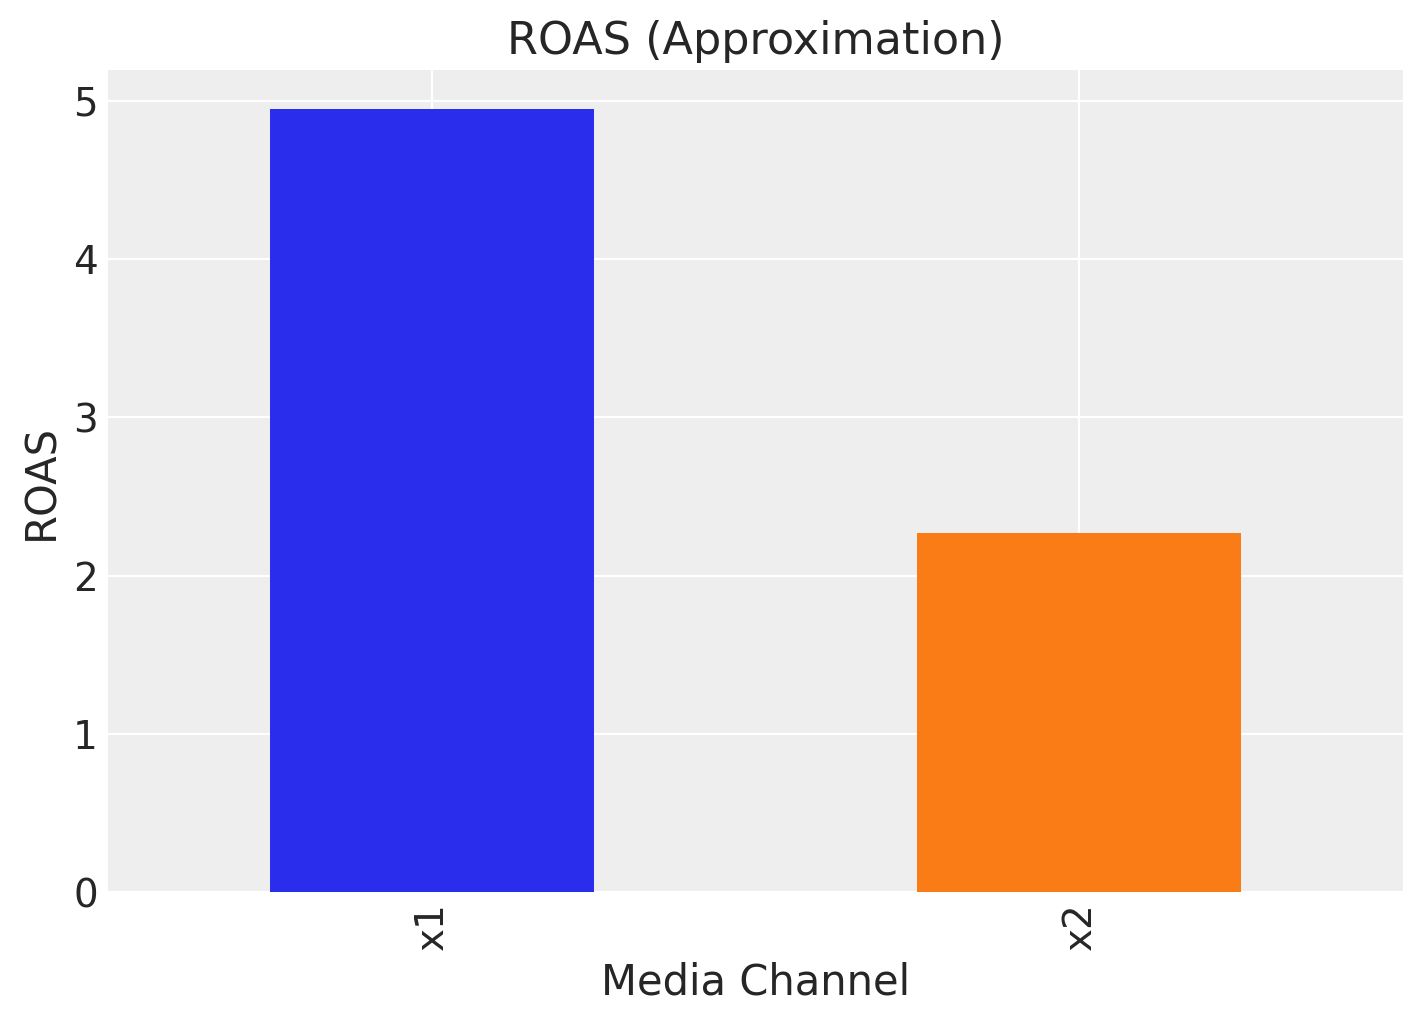

In [18]:
fig, ax = plt.subplots(figsize=(7, 5))
(
    pd.Series(data=[roas_1, roas_2], index=["x1", "x2"]).plot(
        kind="bar", color=["C0", "C1"]
    )
)

ax.set(title="ROAS (Approximation)", xlabel="Media Channel", ylabel="ROAS");

That is, channel $x_{1}$ seems to be more efficient than channel $x_{2}$.

```{note}
We recommended reading Section 4.1 in [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017)](https://research.google/pubs/pub46001/) for a detailed explanation of the ROAS (and mROAS). In particular:

- If we transform our target variable $y$ (e.g. with a log transformation), one needs to be careful with the ROAS computation as setting the spend to zero does not commute with the transformation.

- One has to be careful with the adstock effect so that we include a carryover period to fully account for the effect of the spend. The ROAS estimation above is an approximation.
```

### 7. Data Output

We of course will not have all of these features in our real data. Let's filter out the features we will use for modeling:

In [19]:
columns_to_keep = [
    "date",
    "y",
    "x1",
    "x2",
    # "event_1",
    # "event_2",
    # "dayofyear",
] + control_dayofweek

data = df[columns_to_keep].copy()

data.head()

date         y        x1        x2  dayofweek_0  dayofweek_1  \
0 2024-01-01  2.762385  0.318580  0.942322            1            0   
1 2024-01-02  1.747168  0.112388  0.000000            0            1   
2 2024-01-03  1.804173  0.292400  0.000000            0            0   
3 2024-01-04  2.260266  0.071399  0.000000            0            0   
4 2024-01-05  1.731902  0.386745  0.000000            0            0   

   dayofweek_2  dayofweek_3  dayofweek_4  dayofweek_5  
0            0            0            0            0  
1            0            0            0            0  
2            1            0            0            0  
3            0            1            0            0  
4            0            0            1            0

## Part II: Modeling

On this second part, we focus on the modeling process. We will use the data generated in Part I.

## 1. Feature Engineering

Assuming we did an EDA and we have a good understanding of the data (we did not do it here as we generated the data ourselves, but please never skip the EDA!), we can start building our model. One thing we immediately see is the seasonality and the trend component. We can generate features ourselves as *control variables*, for example using a uniformly increasing straight line to model the trend component. In addition, we include *dummy variables* to encode the `event_1`  and `event_2` contributions.

For the seasonality component we use Fourier modes (similar as in [Prophet](https://facebook.github.io/prophet/)). We do not need to add the Fourier modes by hand as they are handled by the model API through the `yearly_seasonality` argument (see below). We use 4 modes for the seasonality component.

In [20]:
# # trend feature
# data["t"] = range(n)

# data.head()

## 2. Model Specification

We can specify the model structure using the {class}`MMM <pymc_marketing.mmm.delayed_saturated_mmm.MMM>` class. This class, handles a lot of internal boilerplate code for us such us scaling the data (see details below) and handy diagnostics and reporting plots. One great feature is that we can specify the channel priors distributions ourselves, which fundamental component of the [bayesian workflow](https://arxiv.org/abs/2011.01808) as we can incorporate our prior knowledge into the model. This is one of the most important advantages of using a bayesian approach. Let's see how we can do it.

As we do not know much more about the channels, we start with a simple heuristic: 

1. The channel contributions should be positive, so we can for example use a {class}`HalfNormal <pymc.distributions.continuous.HalfNormal>` distribution as prior. We need to set the `sigma` parameter per channel. The higher the `sigma`, the more "freedom" it has to fit the data. To specify `sigma` we can use the following point.

2. We expect channels where we spend the most to have more attributed sales , before seeing the data. This is a very reasonable assumption (note that we are not imposing anything at the level of efficiency!).

How to incorporate this heuristic into the model? To begin with, it is important to note that the {class}`MMM <pymc_marketing.mmm.delayed_saturated_mmm.MMM>` class scales the target and input variables through an [`MaxAbsScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) transformer from [`scikit-learn`](https://scikit-learn.org/stable/), its important to specify the priors in the scaled space (i.e. between 0 and 1). One way to do it is to use the spend share as the `sigma` parameter for the `HalfNormal` distribution. We can actually add a scaling factor to take into account the support of the distribution.

First, let's compute the share of spend per channel:

In [21]:
total_spend_per_channel = data[["x1", "x2"]].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

spend_share

x1    0.645579
x2    0.354421
dtype: float64

Next, we specify the `sigma` parameter per channel: 

In [22]:
# The scale helpful to make a HalfNormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

n_channels = 2

prior_sigma = HALFNORMAL_SCALE * n_channels * spend_share.to_numpy()

prior_sigma.tolist()

[2.1418977103656407, 1.1758957695749717]

Delayed Saturated MMM follows sklearn convention, so we need to split our data into X (predictors) and y(target value)

In [23]:
X = data.drop("y", axis=1)
y = data["y"]

You can use the optional parameter 'model_config' to apply your own priors to the model. Each entry in the 'model_config' contains a key that corresponds to a registered distribution name in our model. The value of the key is a dictionary that describes the input parameters of that specific distribution.

If you're unsure how to define your own priors, you can use the 'default_model_config' property of {class}`MMM <pymc_marketing.mmm.delayed_saturated_mmm.MMM>` to see the required structure.

In [24]:
dummy_model = DelayedSaturatedMMM(date_column="", channel_columns="", adstock="geometric", saturation="logistic", adstock_max_lag=4)
dummy_model.default_model_config

{'intercept': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'beta_channel': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}},
 'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'lam': {'dist': 'Gamma', 'kwargs': {'alpha': 3, 'beta': 1}},
 'likelihood': {'dist': 'Normal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}}}},
 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'mu': 0, 'b': 1}},
 'intercept_tvp_kwargs': {'m': 200,
  'L': None,
  'eta_lam': 1,
  'ls_mu': None,
  'ls_sigma': 10,
  'cov_func': None}}

You can change only the prior parameters that you wish, no need to alter all of them, unless you'd like to!

In [25]:
my_model_config = {
    "saturation_beta": {
        "dist": "LogNormal",
        "kwargs": {"mu": np.array([2, 1]), "sigma": prior_sigma},
    },
    "likelihood": {
        "dist": "Normal",
        "kwargs": {
            "sigma": {"dist": "HalfNormal", "kwargs": {"sigma": 2}}
            # Also possible define sigma as:
            # {'sigma': 5}
        },
    },
}

**Remark:** For the prior specification there is no right or wrong answer. It all depends on the data, the context and the assumptions you are willing to make. It is always recommended to do some prior predictive sampling and sensitivity analysis to check the impact of the priors on the posterior. We skip this here for the sake of simplicity. If you are not sure about specific priors, the {class}`MMM <pymc_marketing.mmm.delayed_saturated_mmm.MMM>` class has some default priors that you can use as a starting point.

Model sampler allows specifying set of parameters that will be passed to fit the same way as the `kwargs` are getting passed so far. It doesn't disable the fit kwargs, but rather extend them, to enable customizable and preservable configuration. By default the sampler_config for {class}`MMM <pymc_marketing.mmm.delayed_saturated_mmm.MMM>` is empty. But if you'd like to use it, you can define it like showed below: 

In [26]:
my_sampler_config = {"progressbar": True}

Now we are ready to use the {class}`MMM <pymc_marketing.mmm.delayed_saturated_mmm.MMM>` class to define the model.

In [27]:
mmm = DelayedSaturatedMMM(
    model_config=my_model_config,
    sampler_config=my_sampler_config,
    date_column="date",
    adstock="geometric",
    saturation="logistic",
    channel_columns=["x1", "x2"],
    control_columns=control_dayofweek,
    # control_columns=[
    #     "event_1",
    #     "event_2",
    #     "t",
    # ],
    adstock_max_lag=8,
    # yearly_seasonality=2,
)

Observe how the media transformations were handled by the class `MMM`.

## 3. Model Fitting

We can now fit the model:

```{tip}
You can use other NUTS samplers to fit the model as one can do with PyMC models. You just ned to make sure to have the packages installed in your local environment. See {ref}`other_nuts_samplers`.
```

In [28]:
# mmm.fit(X=X, y=y, target_accept=0.90, chains=4, random_seed=rng)

You can access `pymc` model as `mmm.model`.

In [29]:
if not LOAD_FROM_DISK:
    mmm.fit(X=X, y=y, target_accept=0.90, chains=4, cores=4, random_seed=rng)
    mmm.save(f"models/{model_name}")
else:
    mmm = DelayedSaturatedMMM.load(f"models/{model_name}")

/root/.cache/pypoetry/virtualenvs/mmm-experiments-PvlroFJ7-py3.12/lib/python3.12/site-packages/arviz/data/inference_data.py:157: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(


In [30]:
type(mmm.model)

pymc.model.core.Model

We can easily see the explicit model structure:

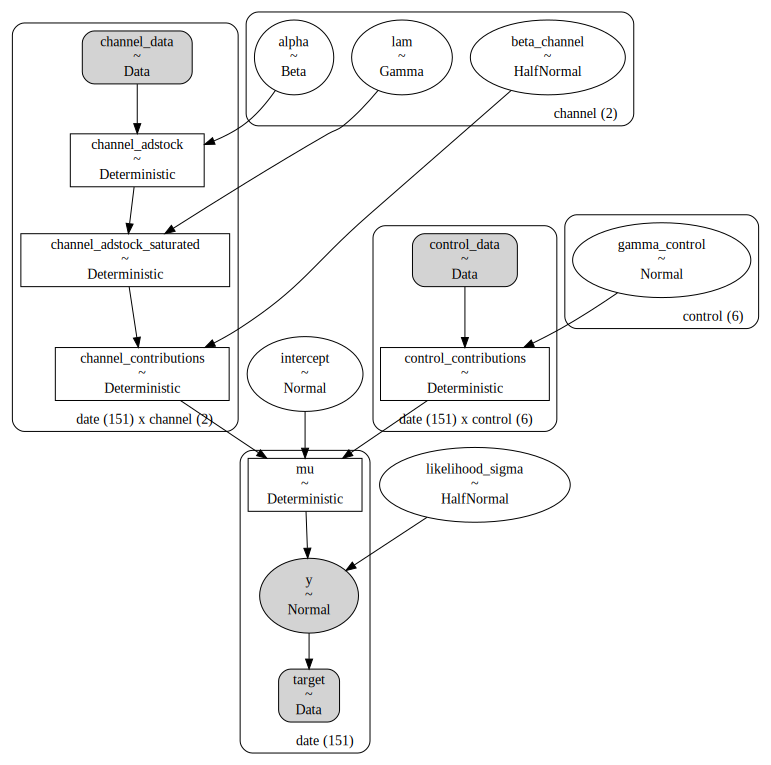

In [31]:
pm.model_to_graphviz(model=mmm.model)

## 4. Model Diagnostics

The {func}`fit_result <pymc_marketing.mmm.delayed_saturated_mmm.MMM.fit_result>` attribute contains the `pymc` trace object.

In [32]:
mmm.fit_result

<xarray.Dataset> Size: 63MB
Dimensions:                    (chain: 4, draw: 1000, channel: 2, date: 151,
                                control: 6)
Coordinates:
  * chain                      (chain) int64 32B 0 1 2 3
  * draw                       (draw) int64 8kB 0 1 2 3 4 ... 996 997 998 999
  * channel                    (channel) <U2 16B 'x1' 'x2'
  * date                       (date) datetime64[ns] 1kB 2024-01-01 ... 2024-...
  * control                    (control) <U11 264B 'dayofweek_0' ... 'dayofwe...
Data variables:
    alpha                      (chain, draw, channel) float64 64kB ...
    beta_channel               (chain, draw, channel) float64 64kB ...
    channel_adstock            (chain, draw, date, channel) float64 10MB ...
    channel_adstock_saturated  (chain, draw, date, channel) float64 10MB ...
    channel_contributions      (chain, draw, date, channel) float64 10MB ...
    control_contributions      (chain, draw, date, control) float64 29MB ...
    gamma_control              (chain, draw, control) float64 192kB ...
    intercept                  (chain, draw) float64 32kB ...
    lam                        (chain, draw, channel) float64 64kB ...
    likelihood_sigma           (chain, draw) float64 32kB ...
    mu                         (chain, draw, date) float64 5MB ...
Attributes:
    created_at:                 2024-06-17T14:40:04.027582+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1
    sampling_time:              20.491145849227905
    tuning_steps:               1000

We can therefore use all the `pymc` machinery to run model diagnostics. First, let's see the summary of the trace:

In [33]:
var_names = var_names = [
        "intercept",
        "likelihood_sigma",
        # "channel_adstock_saturated",
        "lam",
        "alpha",
        "gamma_control",
        # "gamma_fourier",
    ]

# var_names = [
#         "intercept",
#         "likelihood_sigma",
#         "channel_adstock_saturated",
#         "lam",
#         "alpha",
#         "gamma_control",
#         "gamma_fourier",
#         "control_contributions"
#     ]

az.summary(
    data=mmm.fit_result,
    var_names=var_names,
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept                   0.719  0.002   0.715    0.724      0.000    0.000   
likelihood_sigma            0.008  0.000   0.007    0.009      0.000    0.000   
lam[x1]                     2.097  1.470   0.042    4.753      0.025    0.017   
lam[x2]                     2.469  1.722   0.118    5.563      0.031    0.022   
alpha[x1]                   0.362  0.203   0.001    0.677      0.004    0.003   
alpha[x2]                   0.354  0.238   0.000    0.763      0.005    0.003   
gamma_control[dayofweek_0]  0.261  0.003   0.256    0.266      0.000    0.000   
gamma_control[dayofweek_1] -0.094  0.003  -0.098   -0.089      0.000    0.000   
gamma_control[dayofweek_2] -0.092  0.003  -0.097   -0.087      0.000    0.000   
gamma_control[dayofweek_3]  0.081  0.003   0.076    0.086      0.000    0.000   
gamma_control[dayofweek_4] -0.097  0.003  -0.102   -0.092      0.000    0.000   
gamma_control[dayofweek_5] -0.096  0.003  -0.101   -0.091      0.000    0.000   

                            ess_bulk  ess_tail  r_hat  
intercept                      849.0     798.0    1.0  
likelihood_sigma              3542.0    2716.0    1.0  
lam[x1]                       2646.0    1899.0    1.0  
lam[x2]                       2416.0    1832.0    1.0  
alpha[x1]                     3047.0    1929.0    1.0  
alpha[x2]                     2498.0    2160.0    1.0  
gamma_control[dayofweek_0]    1244.0    1910.0    1.0  
gamma_control[dayofweek_1]    1149.0    1744.0    1.0  
gamma_control[dayofweek_2]    1133.0    1830.0    1.0  
gamma_control[dayofweek_3]    1152.0    1786.0    1.0  
gamma_control[dayofweek_4]    1182.0    1747.0    1.0  
gamma_control[dayofweek_5]    1207.0    2019.0    1.0

Observe that the estimated parameters for $\alpha$ and $\lambda$ are very close to the ones we set in the data generation process! Let's plot the trace for the parameters:

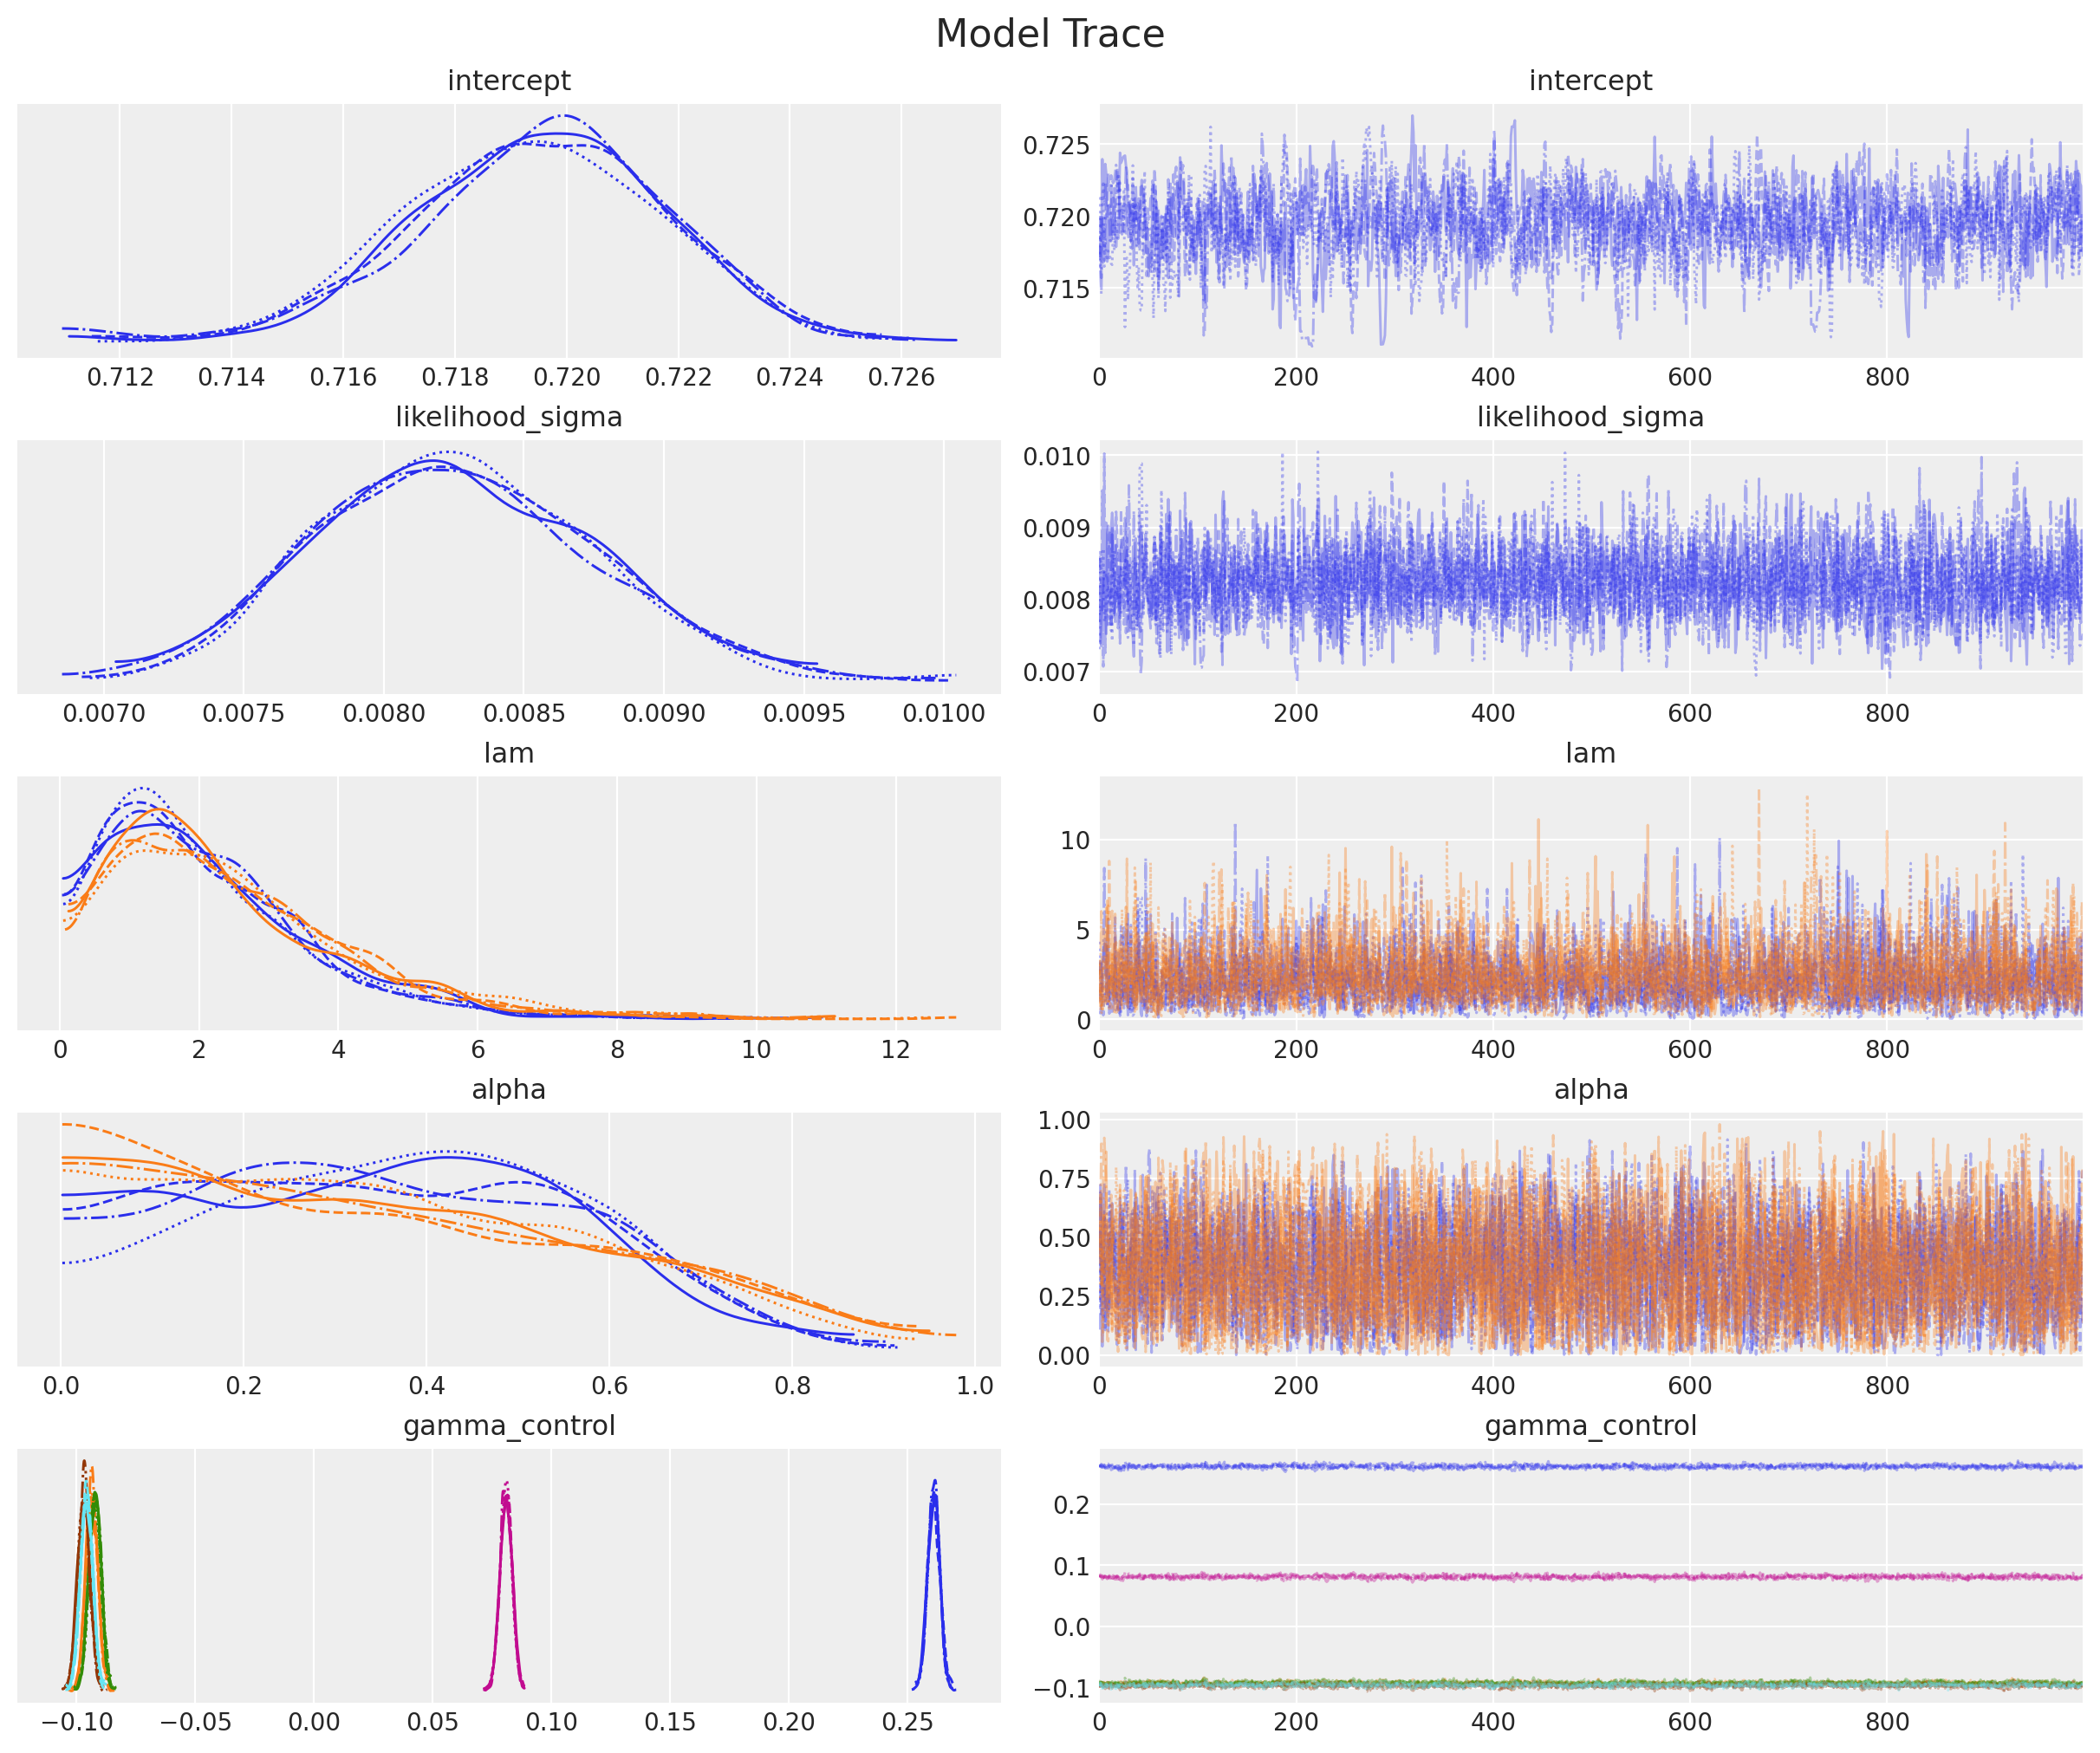

In [34]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

Now we sample from the posterior predictive distribution:

In [35]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

Sampling: [y]


Output()

<xarray.Dataset> Size: 5MB
Dimensions:  (date: 151, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2024-01-01 2024-01-02 ... 2024-05-30
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 5MB 2.767 2.744 2.769 ... 2.202 2.277 2.24
Attributes:
    created_at:                 2024-06-17T14:59:29.941742+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1

We can now plot the posterior predictive distribution for the target variable:

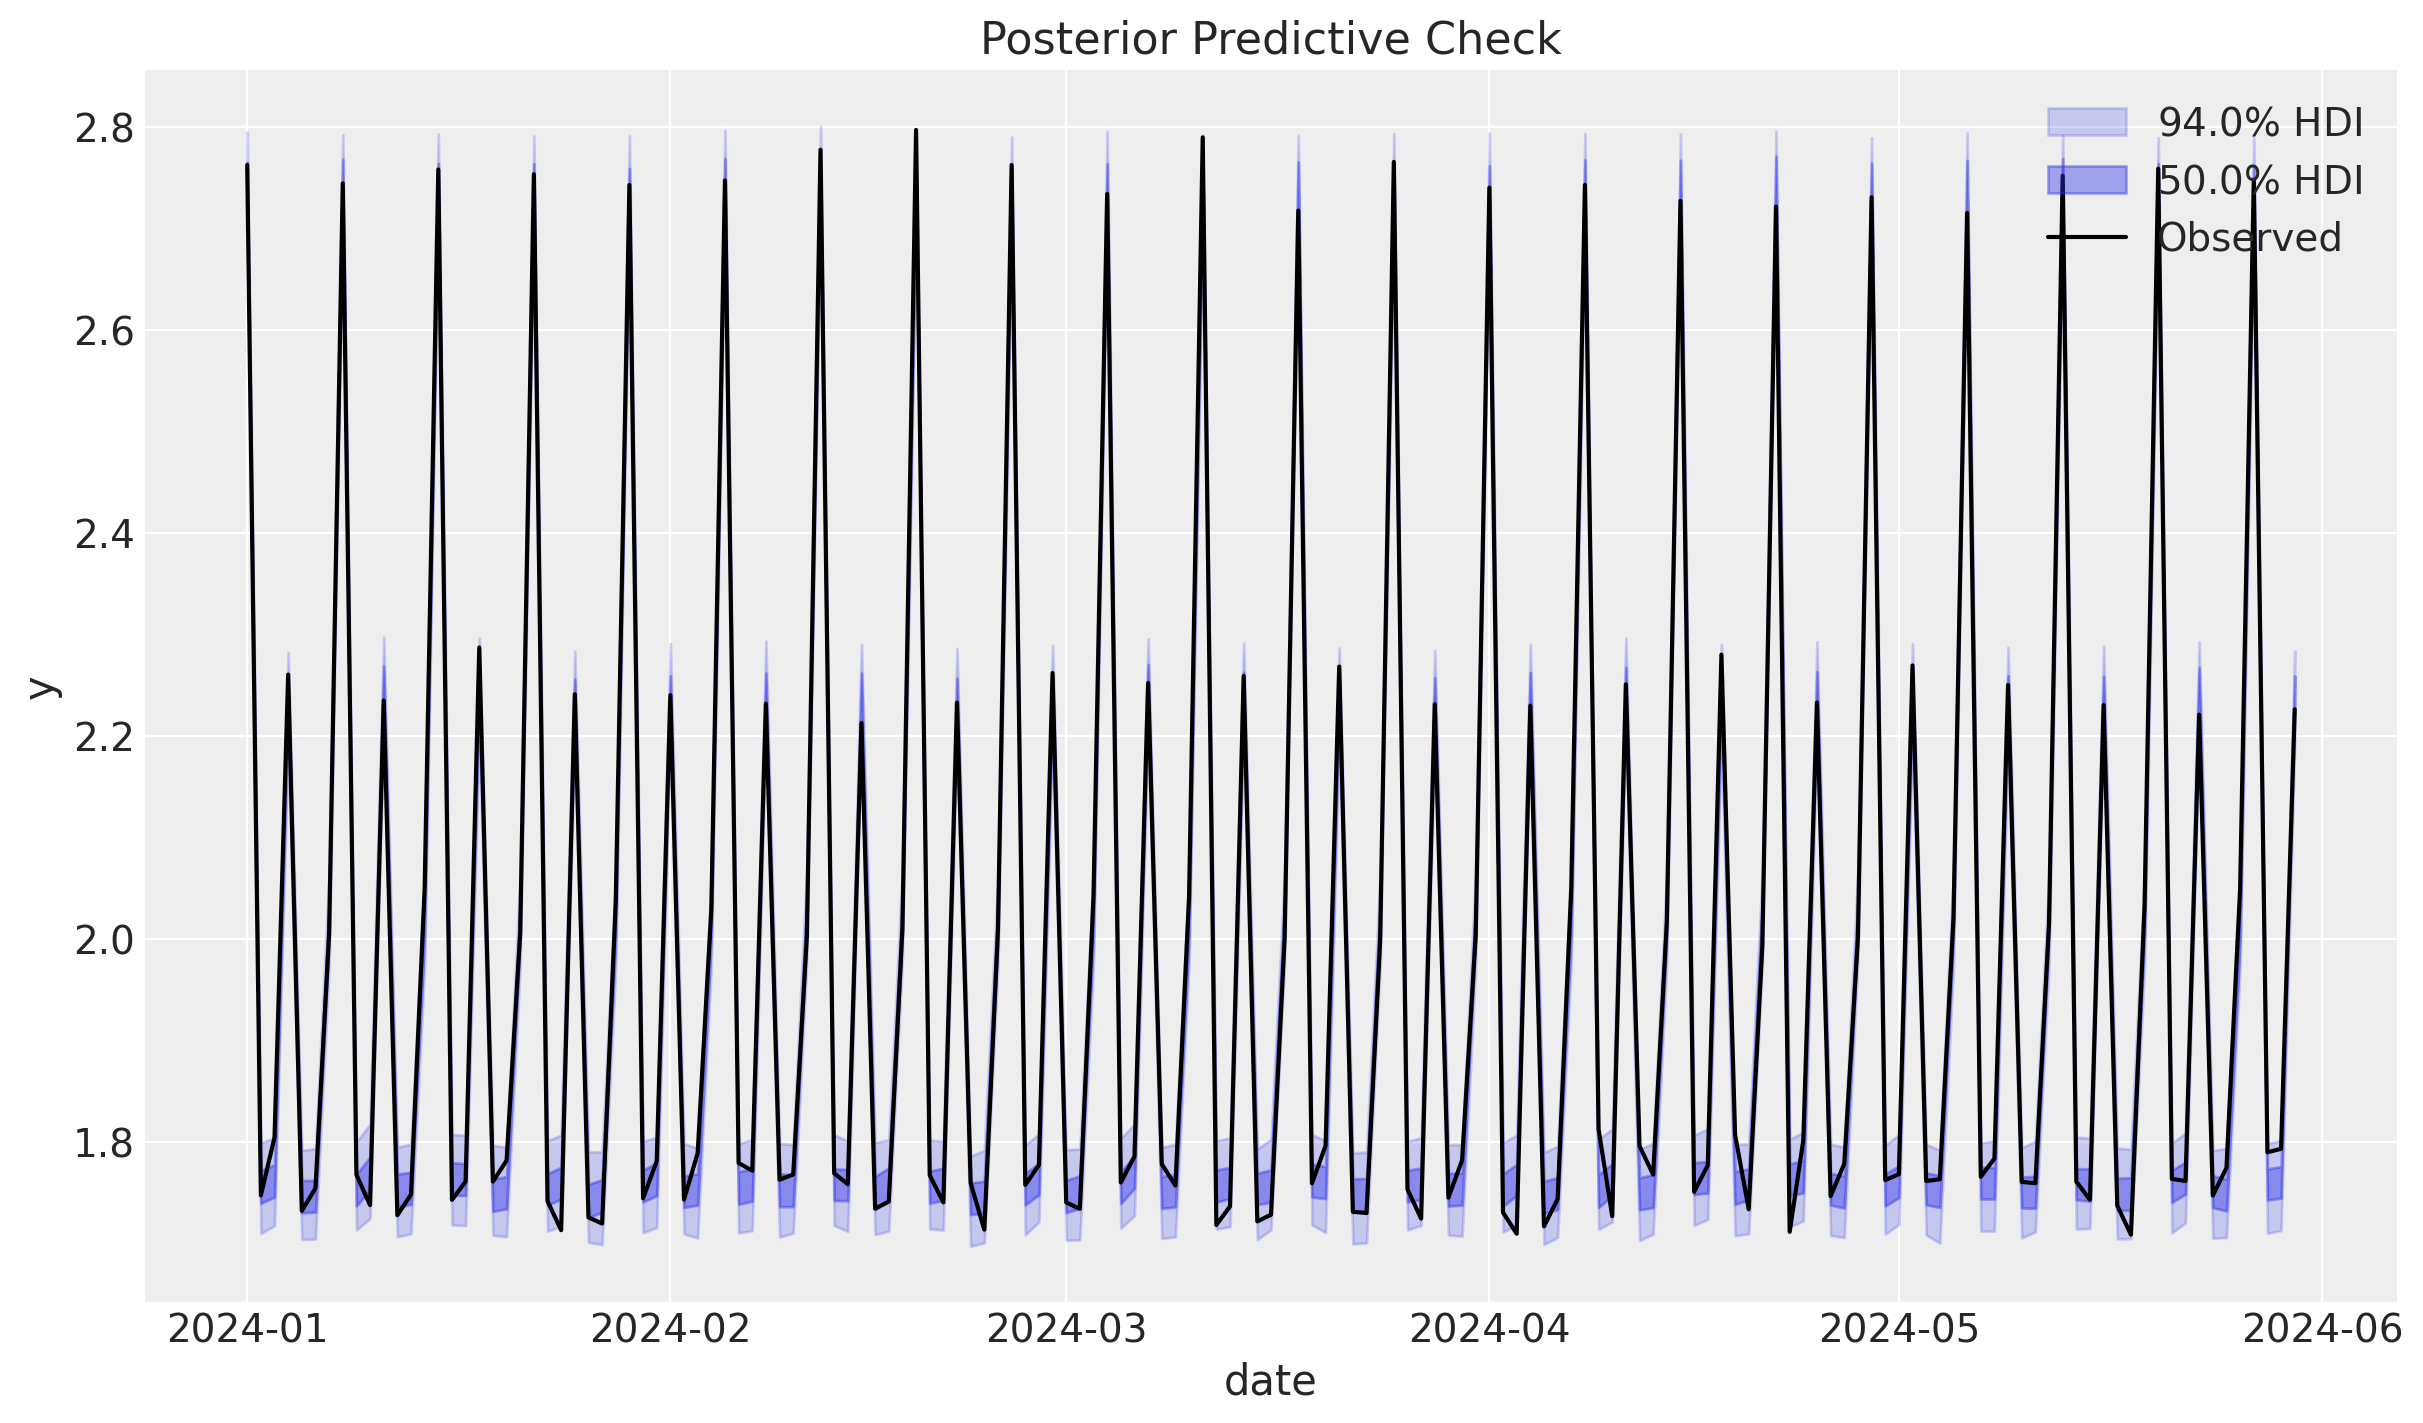

In [36]:
mmm.plot_posterior_predictive(original_scale=True);

The fit looks very good (as expected)!

We can inspect the model errors:

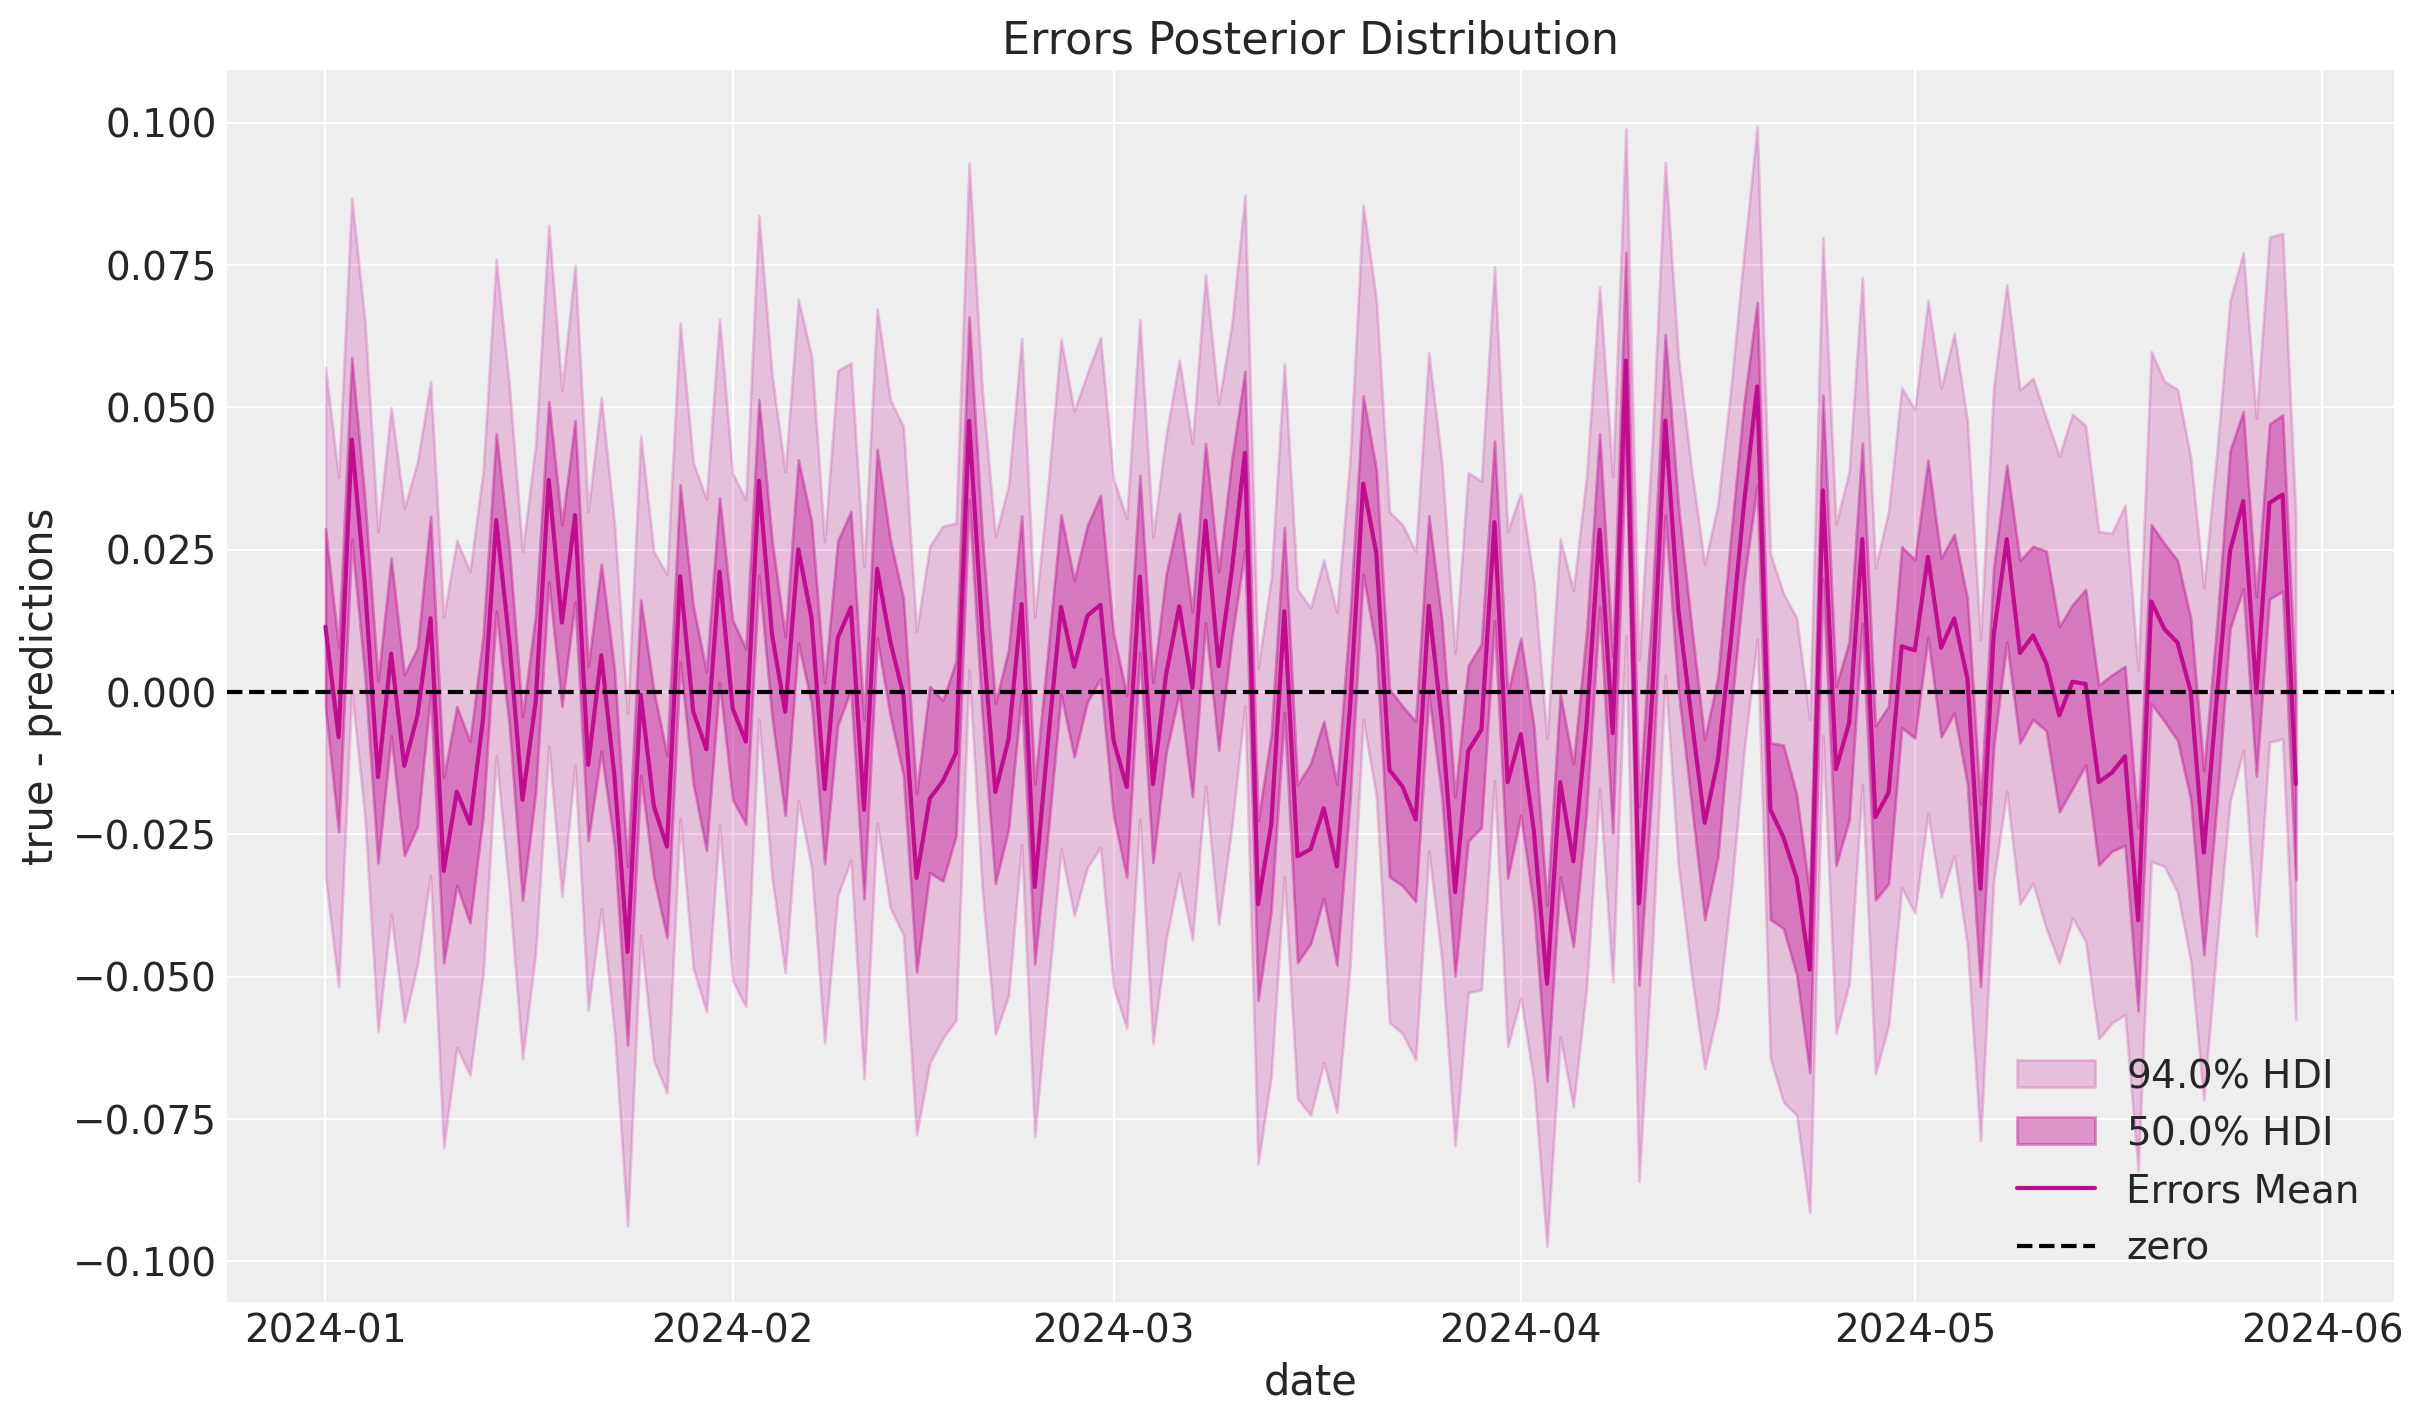

In [37]:
mmm.plot_errors(original_scale=True);

We can actually extract the whole error posterior distribution for custom error analyzes:

In [38]:
errors = mmm.get_errors(original_scale=True)

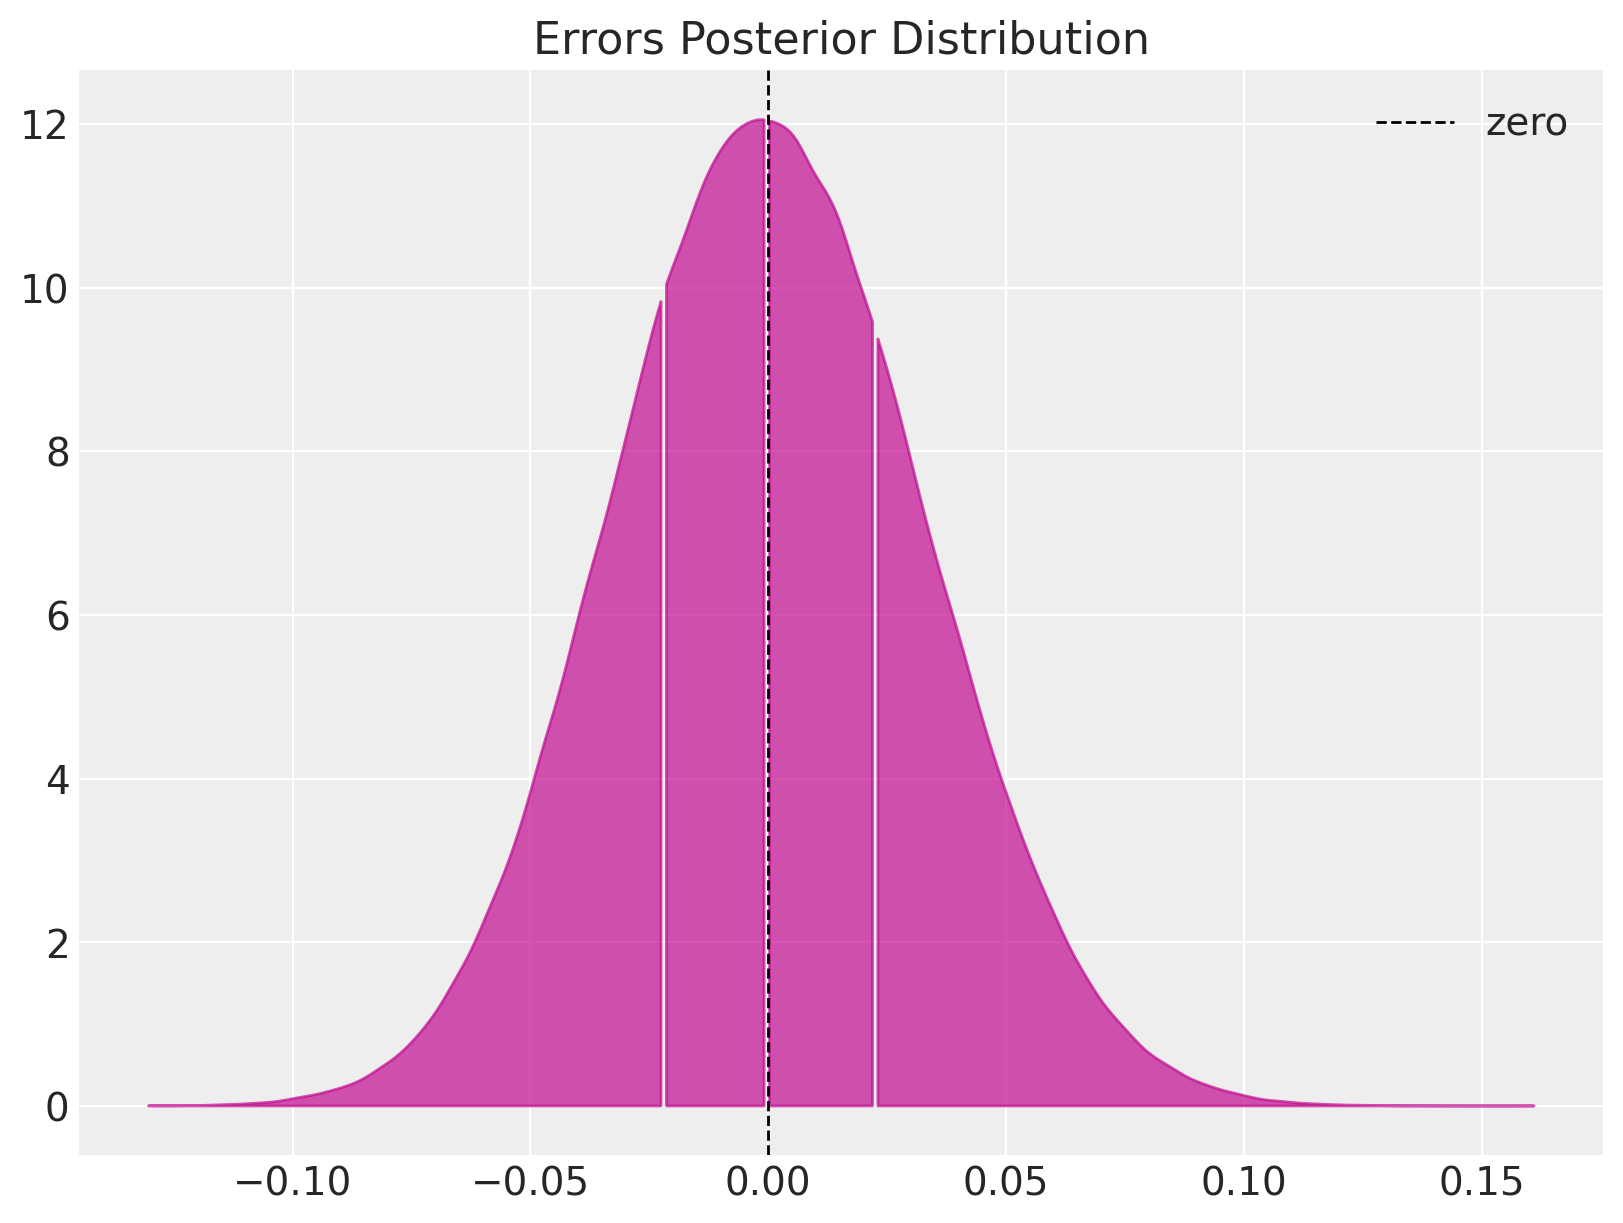

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))
az.plot_dist(
    errors, quantiles=[0.25, 0.5, 0.75], color="C3", fill_kwargs={"alpha": 0.7}, ax=ax
)
ax.axvline(x=0, color="black", linestyle="--", linewidth=1, label="zero")
ax.legend()
ax.set(title="Errors Posterior Distribution");

Next, we can decompose the posterior predictive distribution into the different components:

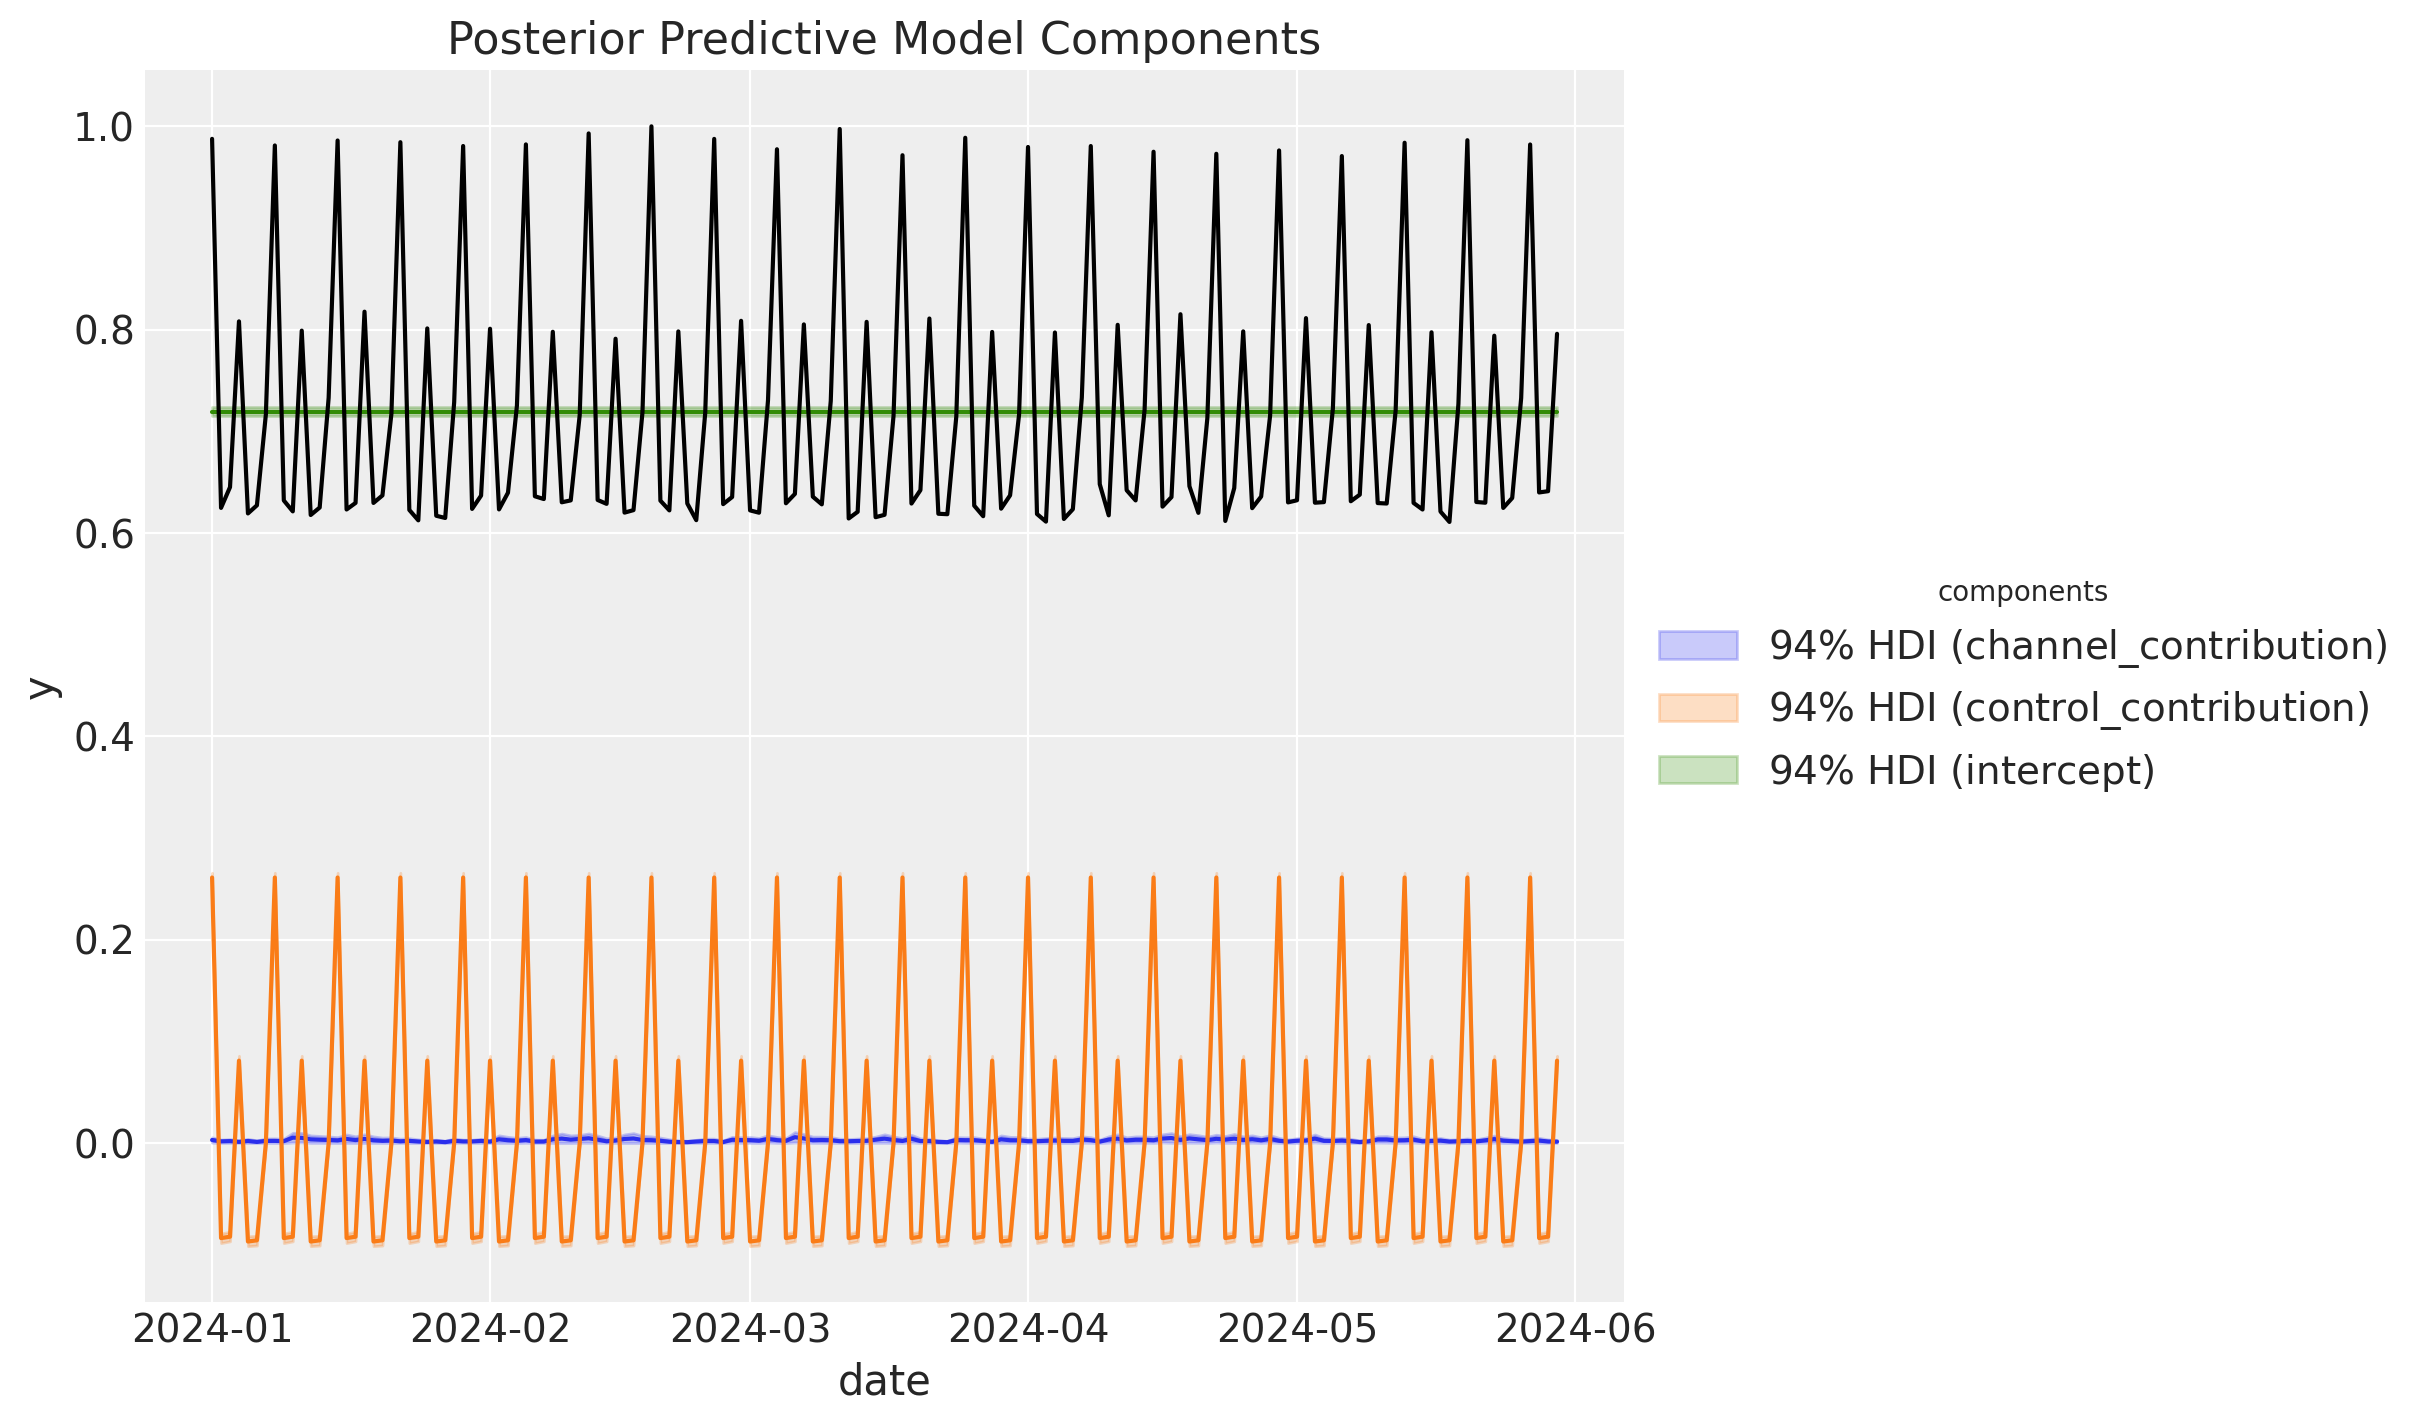

In [40]:
mmm.plot_components_contributions();

**Remark:** This plot shows the decomposition of the normalized target variable when by dividing by its maximum value. Do not forget that internally we are scaling the variables to make the model sample more efficiently. You can recover the transformations from the API methods, e.g.

In [41]:
mmm.get_target_transformer()

Pipeline(steps=[('scaler', MaxAbsScaler())])

A similar decomposition can be achieved using an area plot:

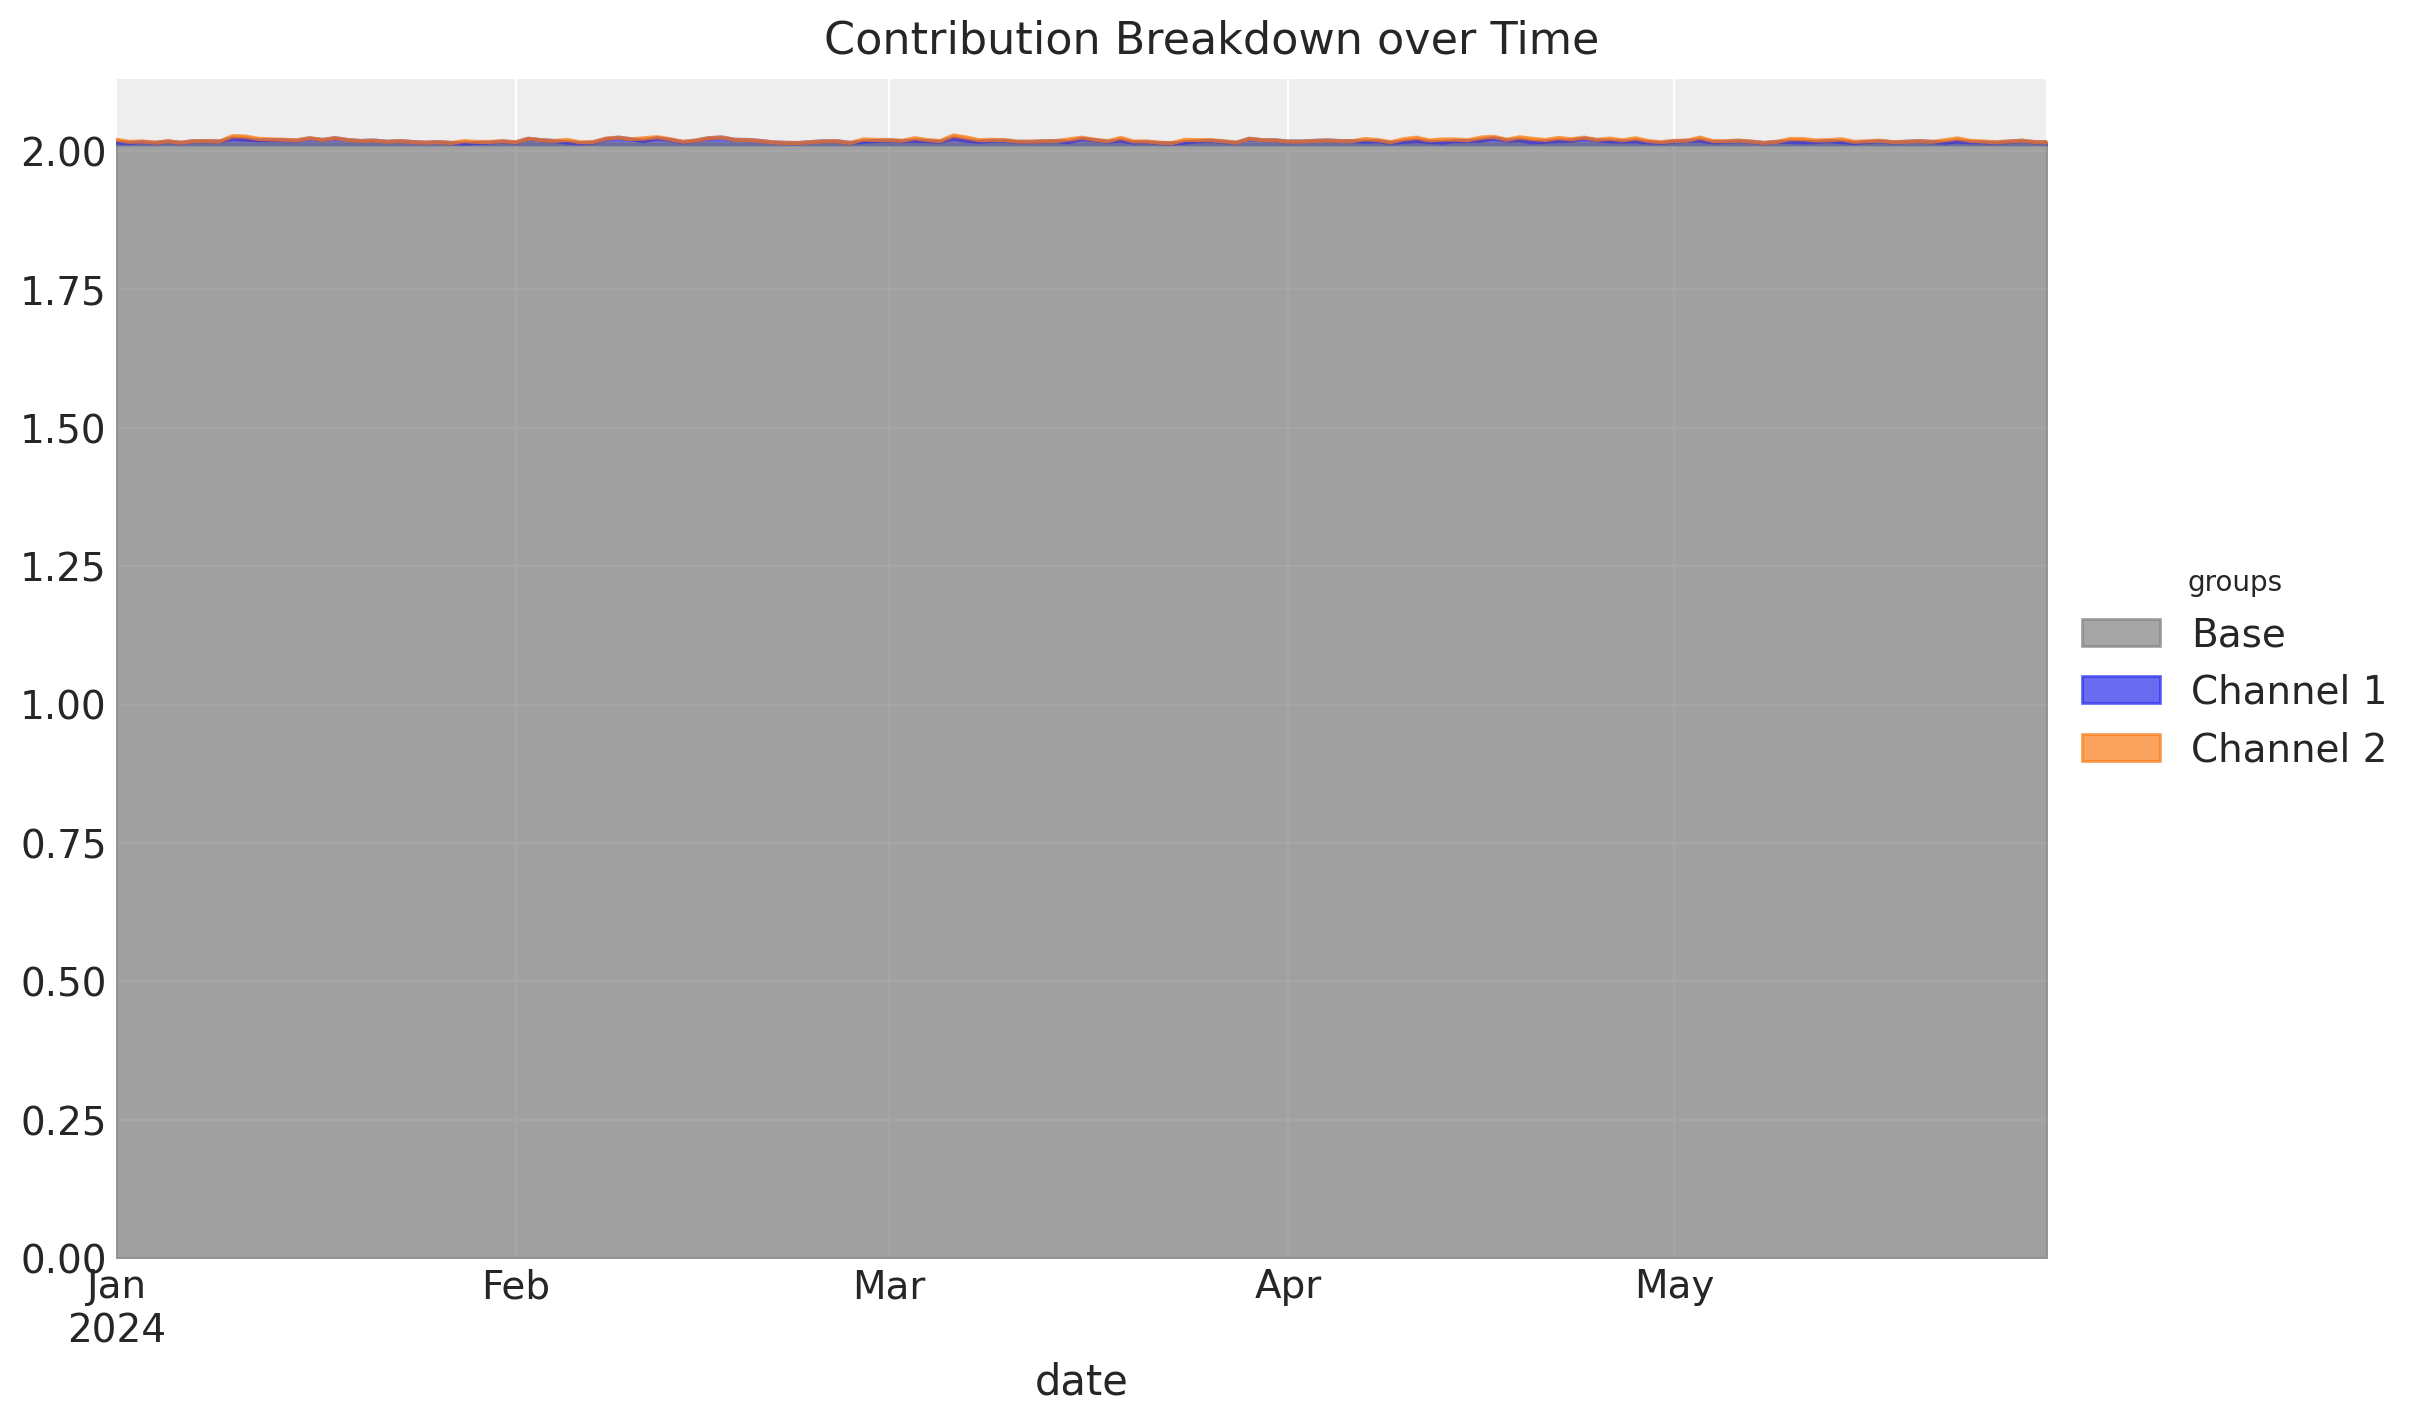

In [42]:
groups = {
    "Base": [
        "intercept",
        "event_1",
        "event_2",
        "t",
        "yearly_seasonality",
    ],
    "Channel 1": ["x1"],
    "Channel 2": ["x2"],
}

fig = mmm.plot_grouped_contribution_breakdown_over_time(
    stack_groups=groups,
    original_scale=True,
    area_kwargs={
        "color": {
            "Channel 1": "C0",
            "Channel 2": "C1",
            "Base": "gray",
            "Seasonality": "black",
        },
        "alpha": 0.7,
    },
)

fig.suptitle("Contribution Breakdown over Time", fontsize=16);

Note that this only works if the contributions of the channel or control variable are strictly positive.

Next, we look into the absolute historical contributions of each component:

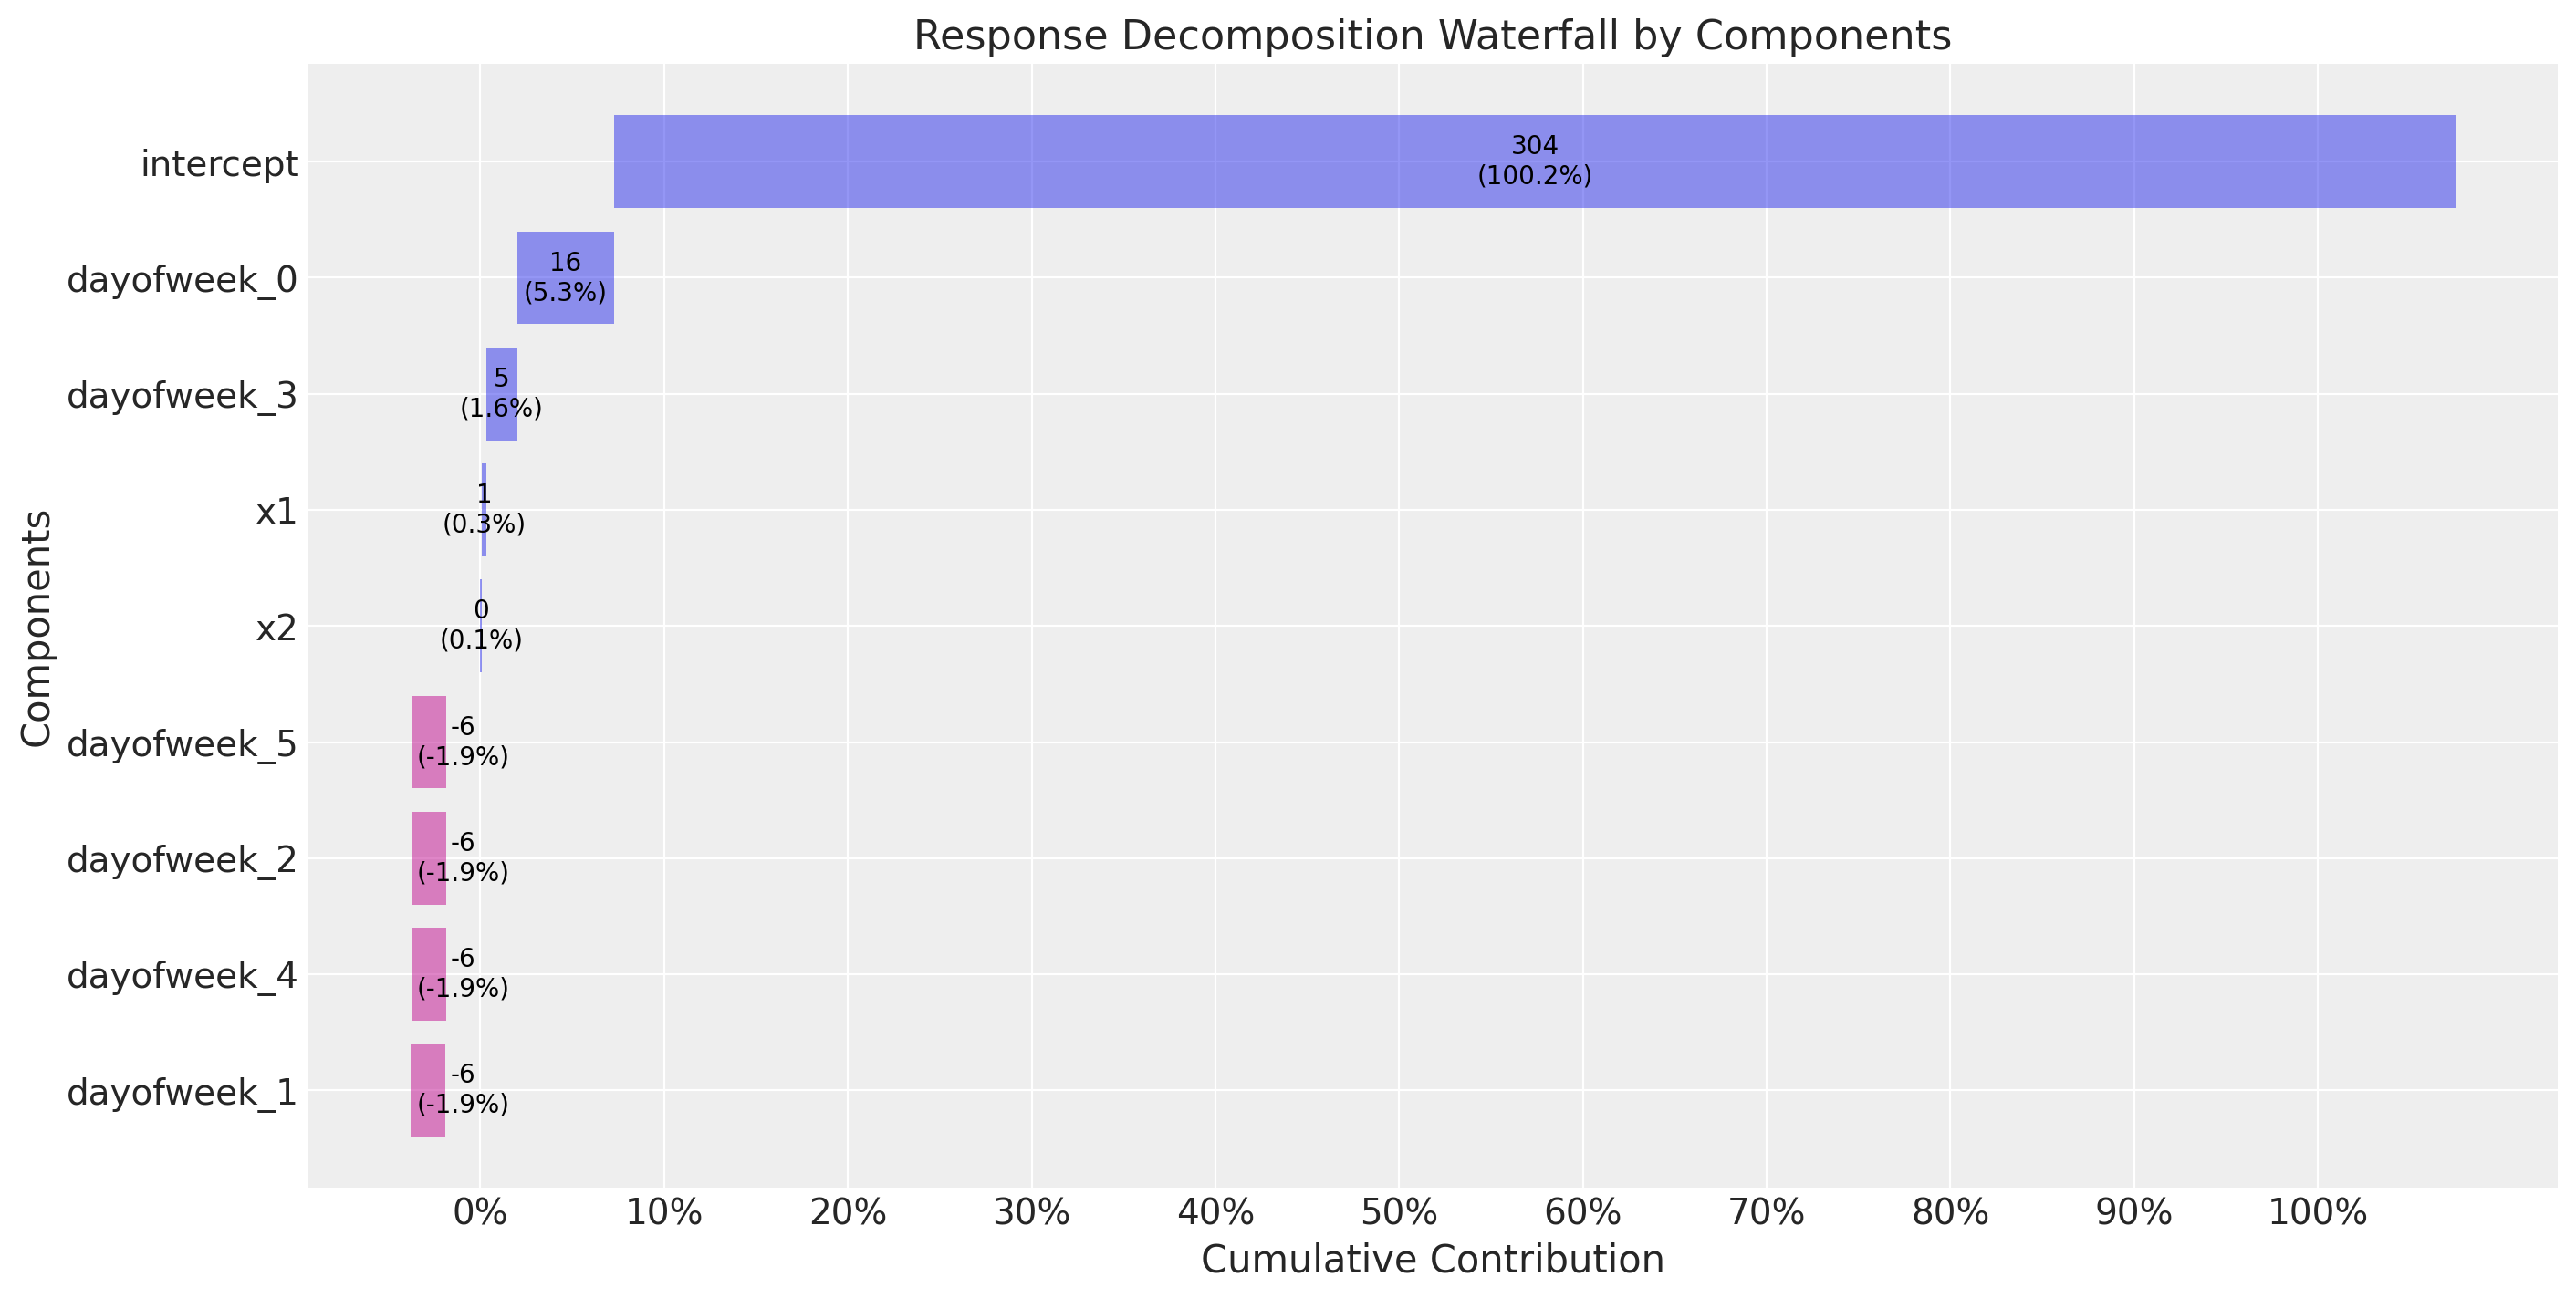

In [43]:
mmm.plot_waterfall_components_decomposition();

Note that we have recovered the true values for all the parameters! Well, in fact the contributions of the `intercept` and `t` are not exactly the same as int the data generating process, but the aggregate does match the true values of `intercept` + `trend`. The reason is that the true latent trend is not completely linear. One could use the time-varying intercept feature to capture this effect.

We can extract the data itself of all the input variables contributions over time, i.e. the regression coefficients times the feature values, as follows:

In [44]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(
    original_scale=True
)

get_mean_contributions_over_time_df.head()

x1        x2  dayofweek_0  dayofweek_1  dayofweek_2  \
date                                                                    
2024-01-01  0.003355  0.004794     0.730275     0.000000     0.000000   
2024-01-02  0.002440  0.001984     0.000000    -0.261635     0.000000   
2024-01-03  0.004051  0.001011     0.000000     0.000000    -0.257934   
2024-01-04  0.002403  0.000596     0.000000     0.000000     0.000000   
2024-01-05  0.005020  0.000386     0.000000     0.000000     0.000000   

            dayofweek_3  dayofweek_4  dayofweek_5  intercept  
date                                                          
2024-01-01     0.000000     0.000000          0.0   2.012178  
2024-01-02     0.000000     0.000000          0.0   2.012178  
2024-01-03     0.000000     0.000000          0.0   2.012178  
2024-01-04     0.226387     0.000000          0.0   2.012178  
2024-01-05     0.000000    -0.271076          0.0   2.012178

## 5. Media Parameters

We can deep-dive into the media transformation parameters. We want to compare the posterior distributions against the true values.

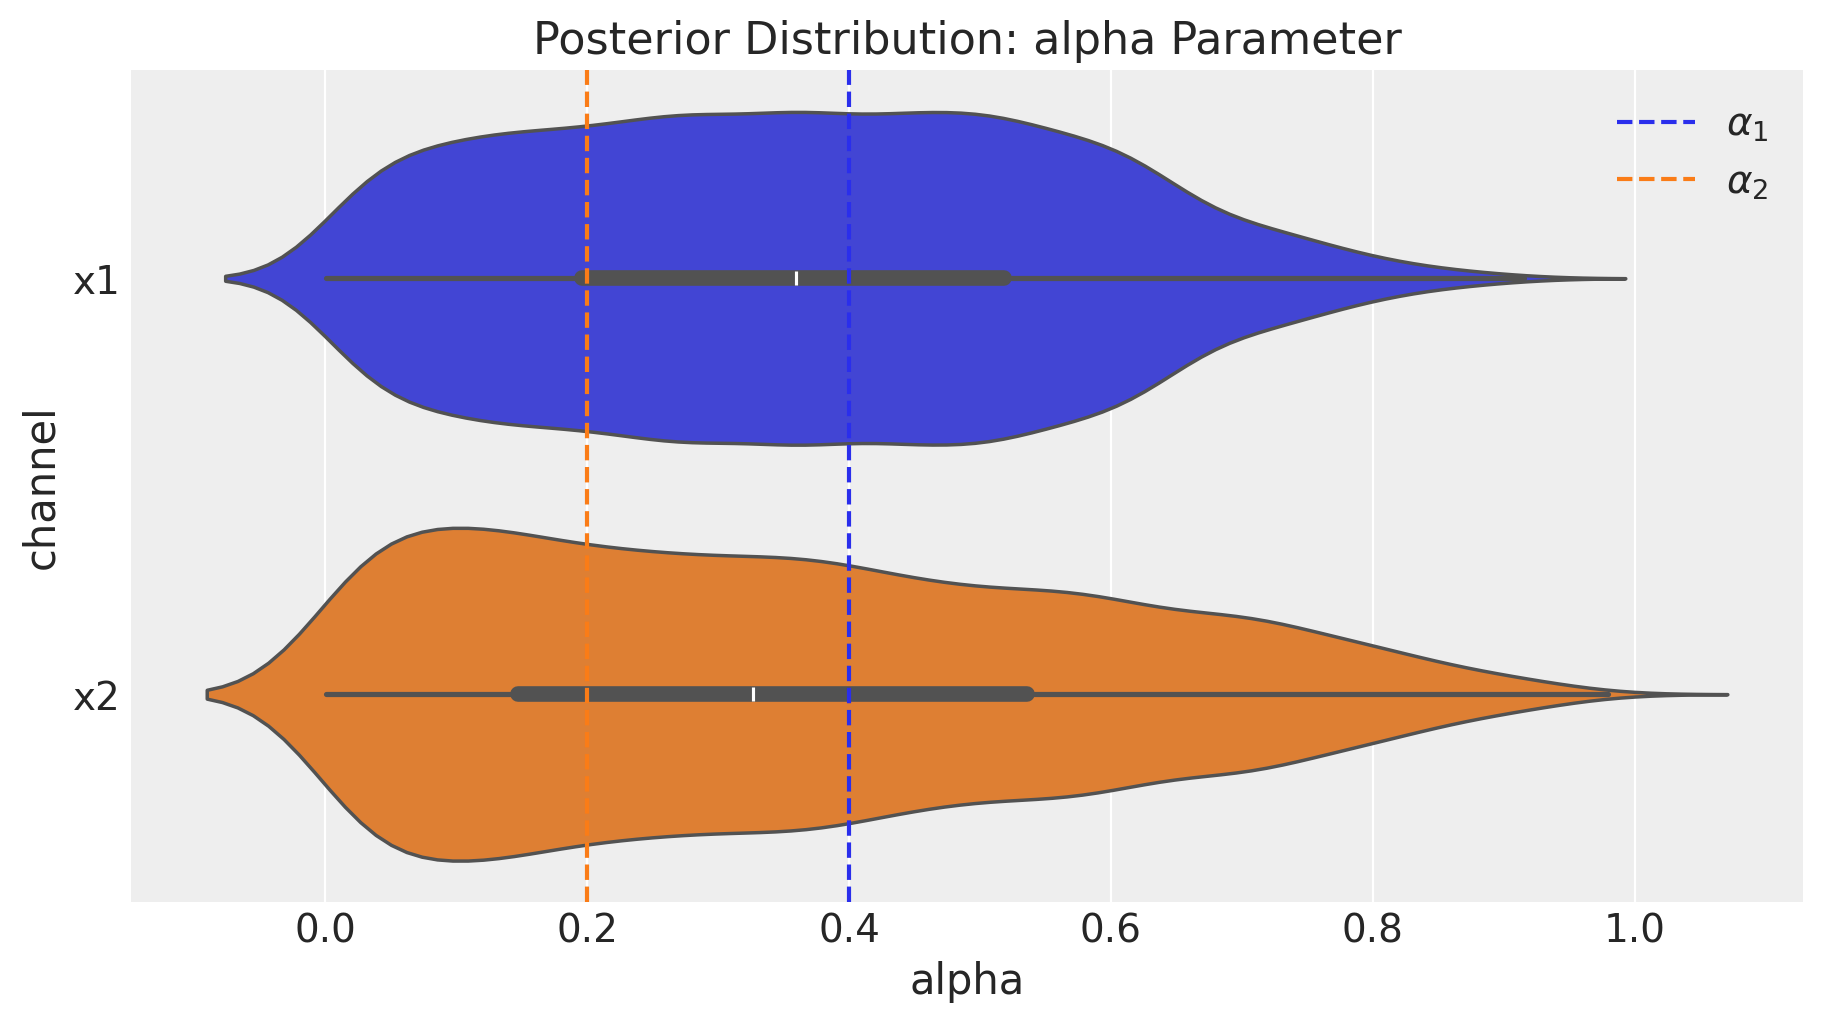

In [45]:
fig = mmm.plot_channel_parameter(param_name="alpha", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"$\alpha_1$")
ax.axvline(x=alpha2, color="C1", linestyle="--", label=r"$\alpha_2$")
ax.legend(loc="upper right");

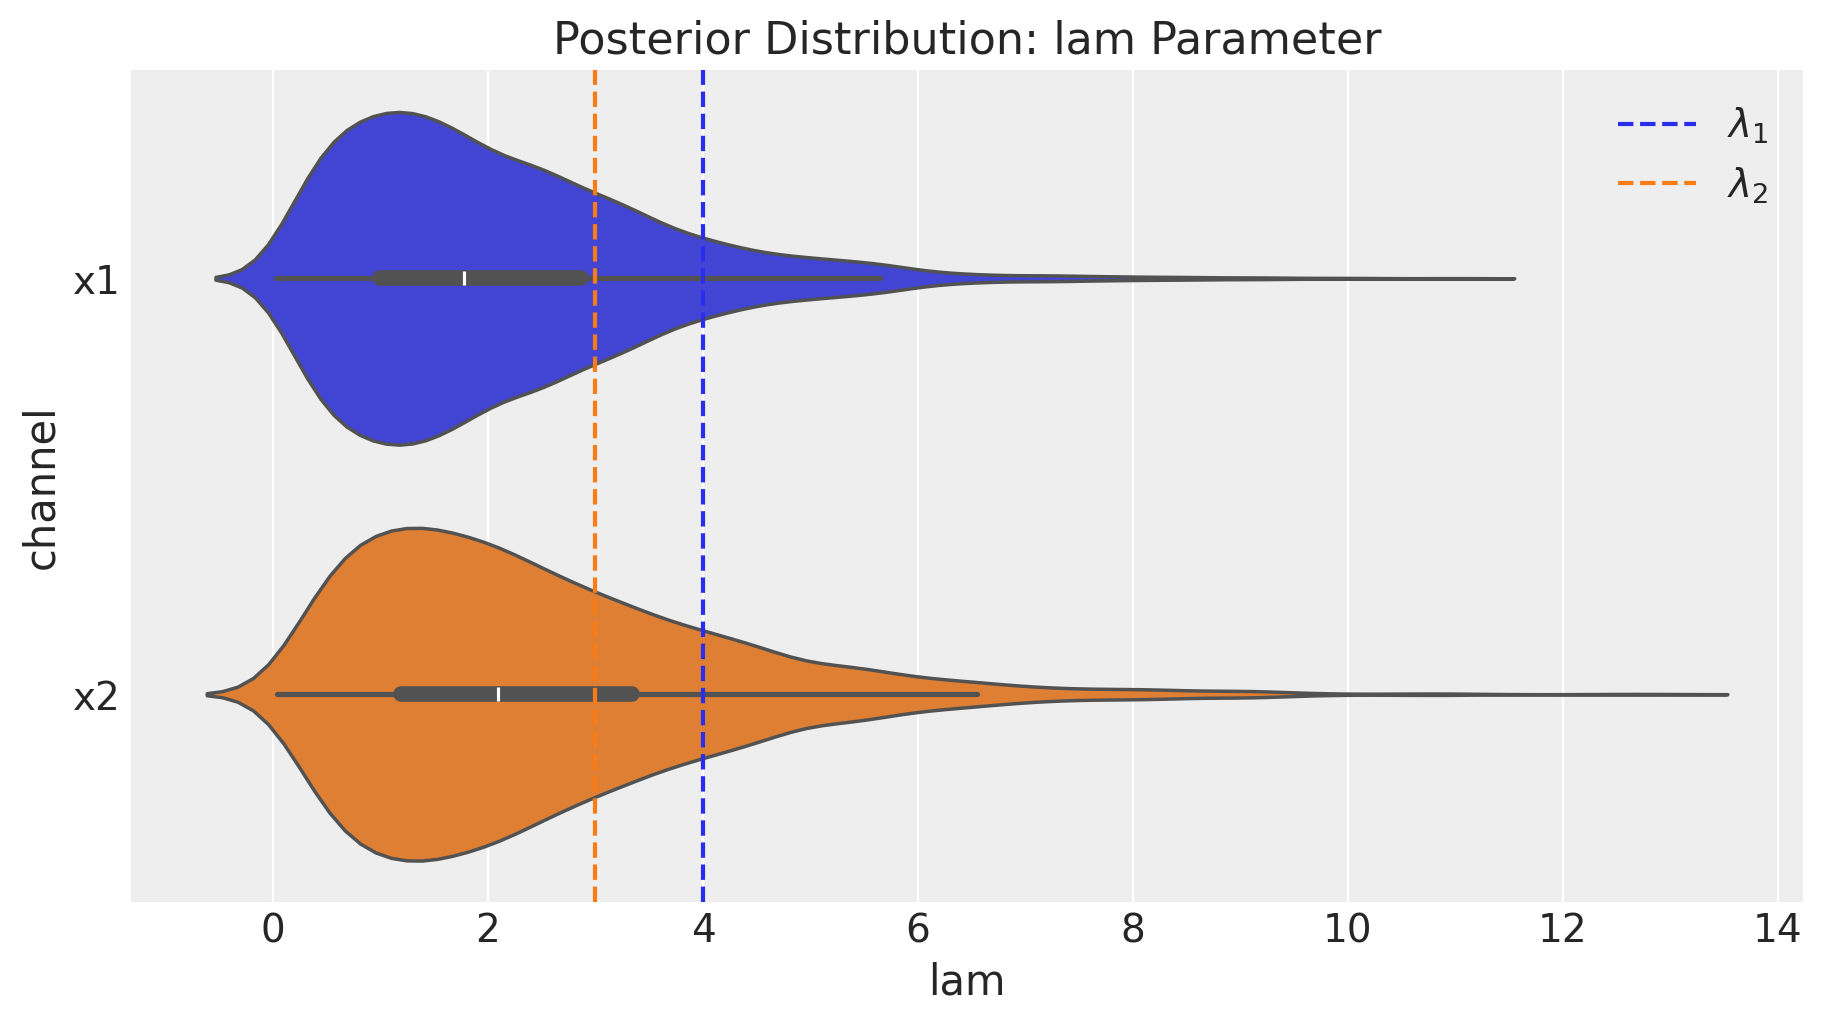

In [46]:
fig = mmm.plot_channel_parameter(param_name="lam", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=lam1, color="C0", linestyle="--", label=r"$\lambda_1$")
ax.axvline(x=lam2, color="C1", linestyle="--", label=r"$\lambda_2$")
ax.legend(loc="upper right");

We indeed see that our media parameter were successfully recovered!

## 6. Media Deep-Dive

First we can compute the relative contribution of each channel to the target variable. Note that we recover the true values!

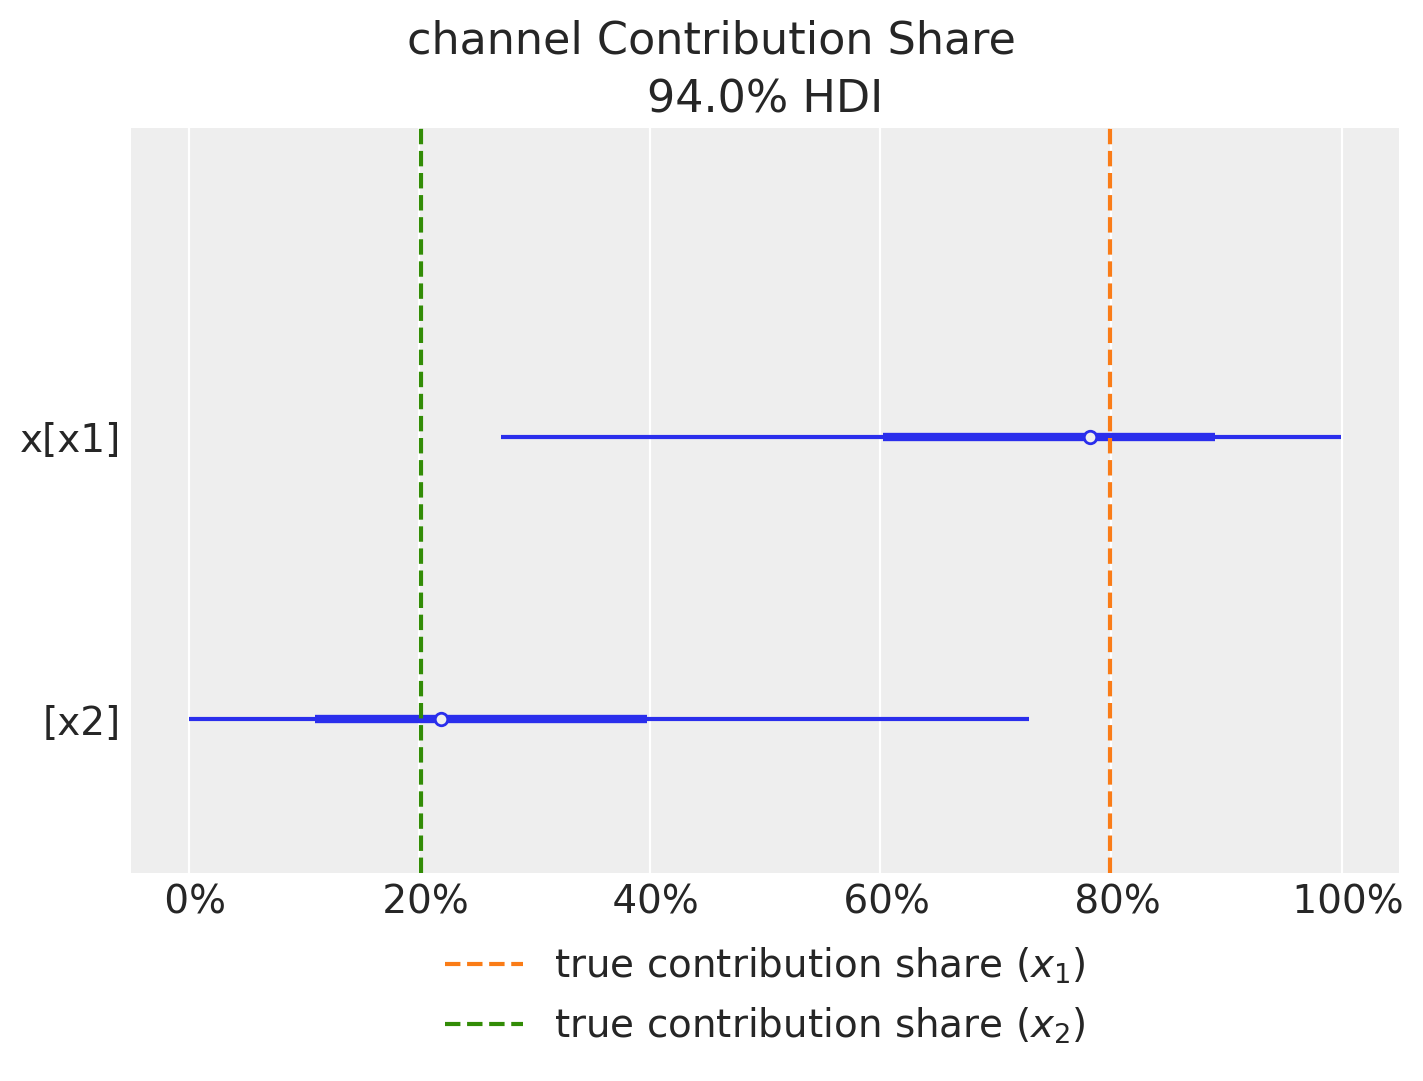

In [47]:
fig = mmm.plot_channel_contribution_share_hdi(figsize=(7, 5))
ax = fig.axes[0]
ax.axvline(
    x=contribution_share_x1,
    color="C1",
    linestyle="--",
    label="true contribution share ($x_1$)",
)
ax.axvline(
    x=contribution_share_x2,
    color="C2",
    linestyle="--",
    label="true contribution share ($x_2$)",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=1);

Next, we can plot the relative contribution of each channel to the target variable. 

First we plot the **direct contribution** per channel. Again, we get very close values as the ones obtained in Part I.

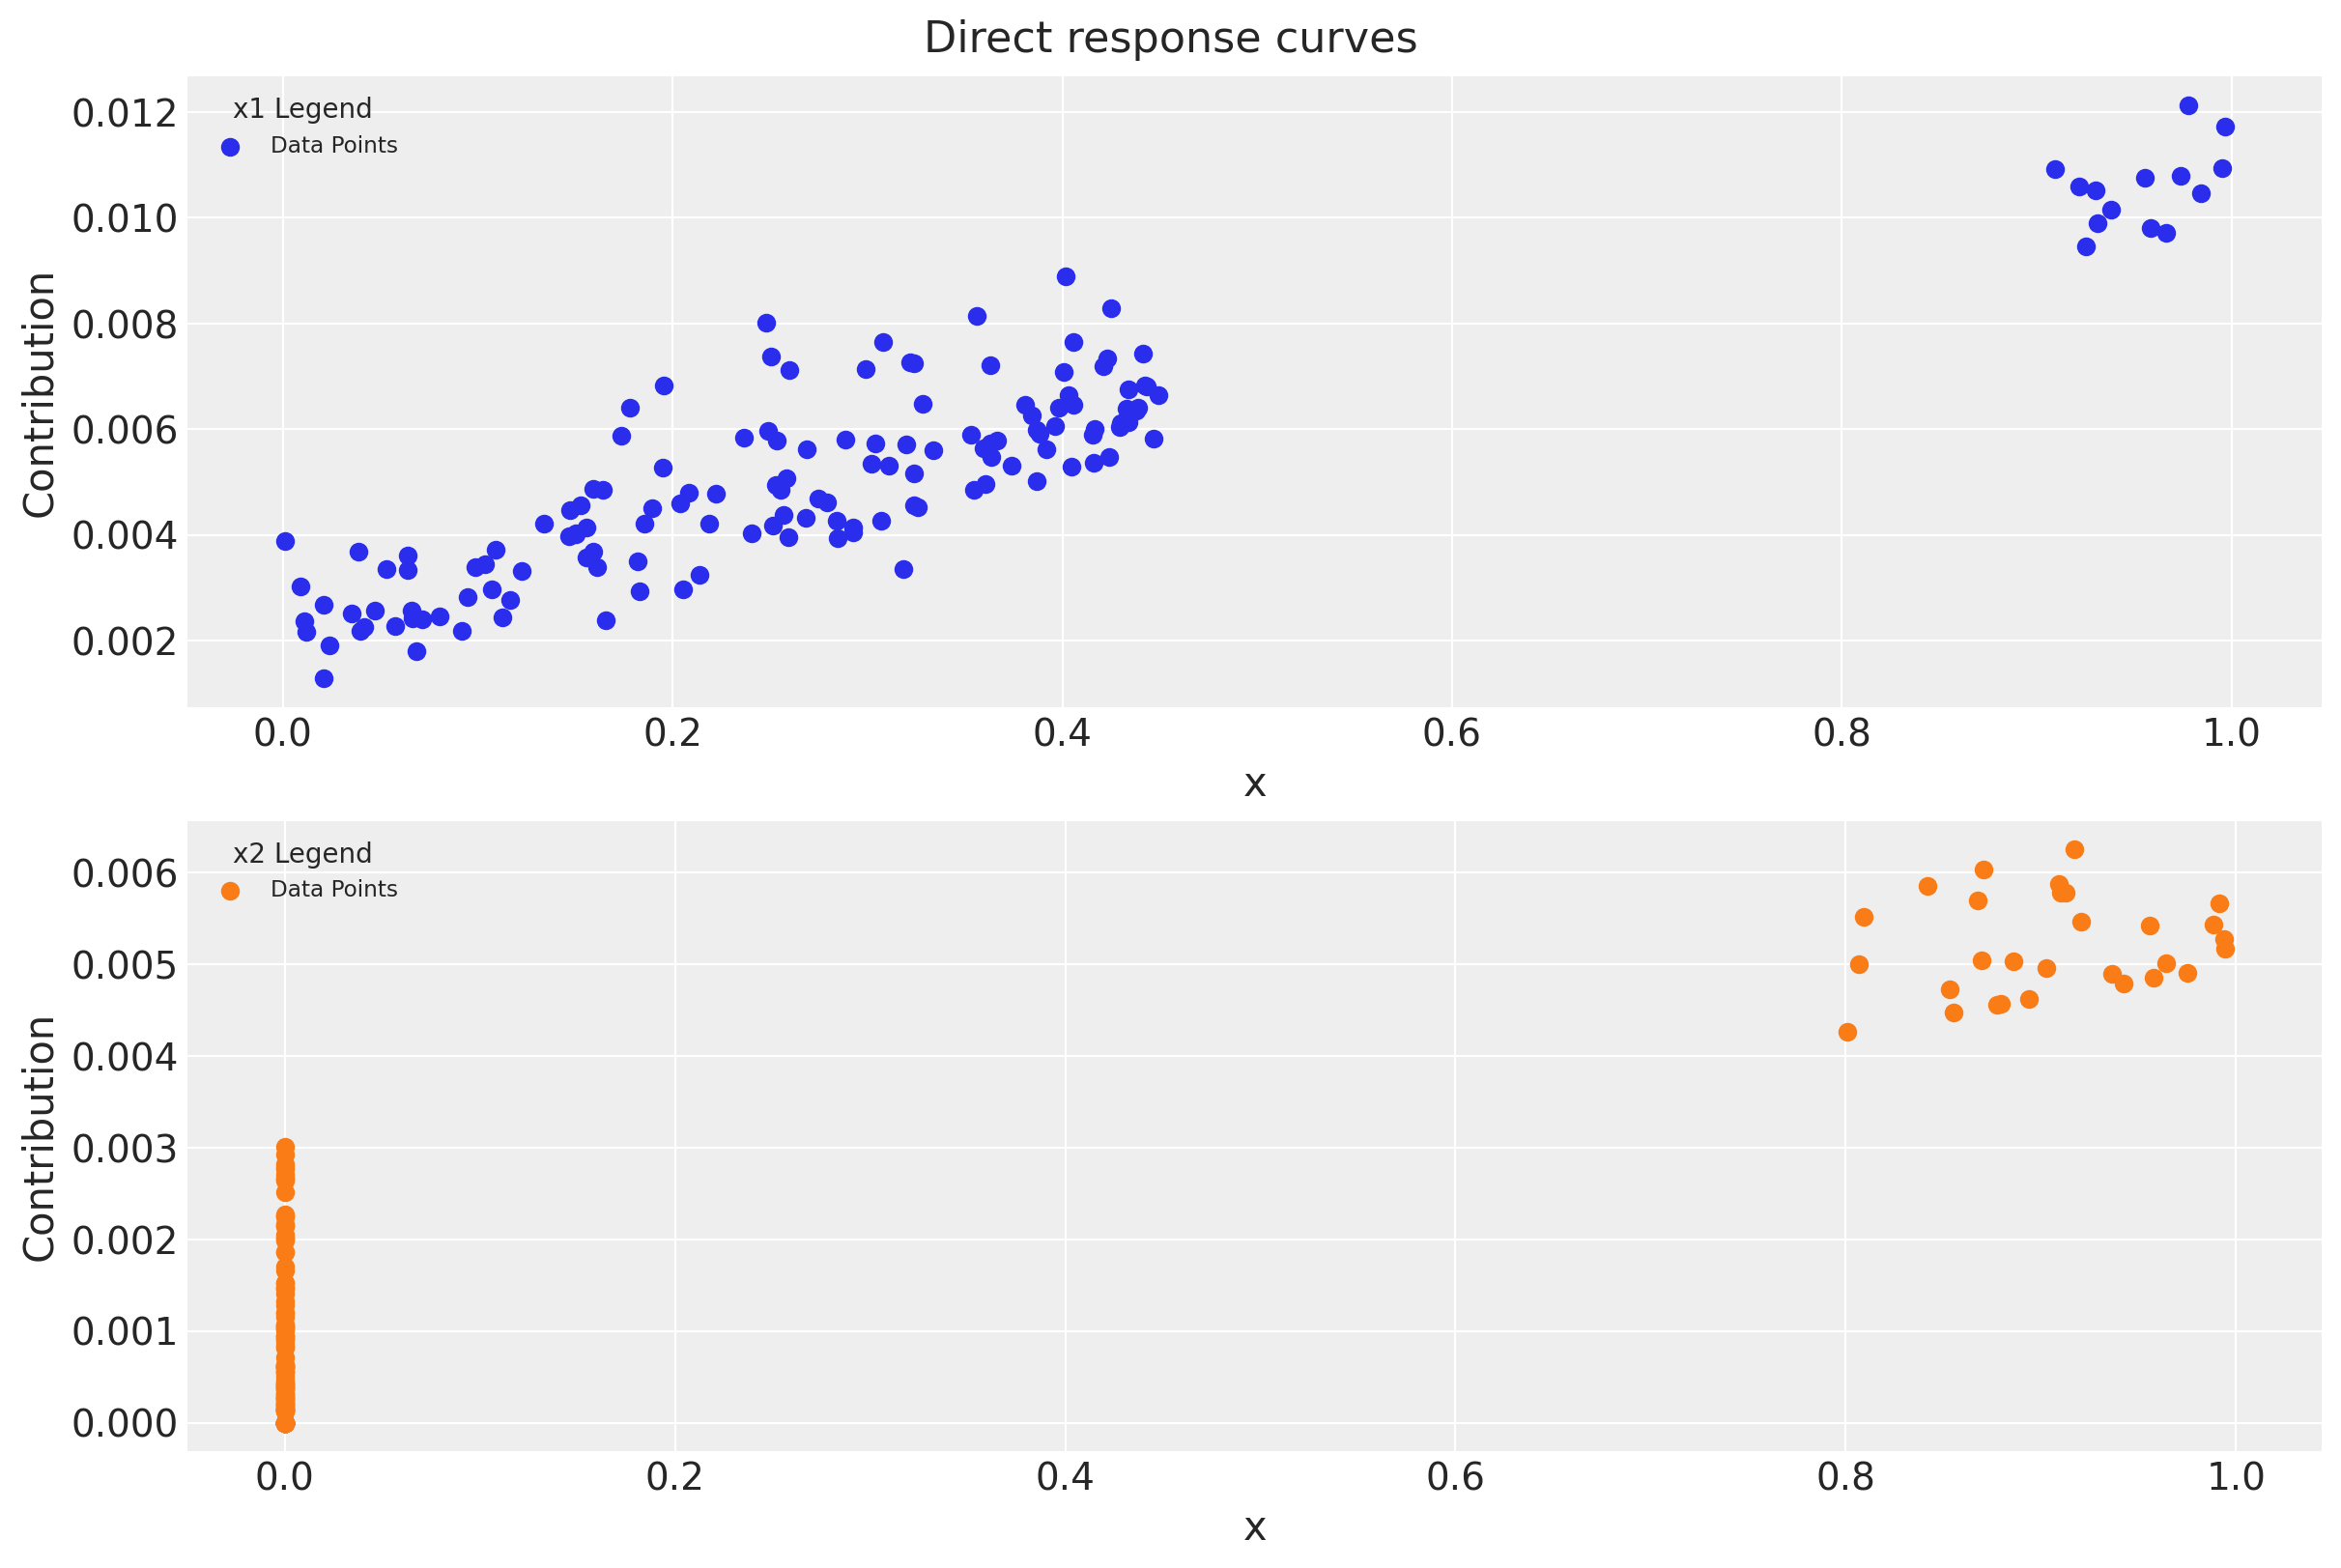

In [48]:
fig = mmm.plot_direct_contribution_curves()
[ax.set(xlabel="x") for ax in fig.axes];

 Note that trying to get the delayed cumulative contribution is not that easy as contributions from the past leak into the future. Specifically, note that we apply the saturation function to the aggregation. As the saturation function is non-linear. This is not the same as taking the sum of the saturation contributions Hence, is very hard to reverse engineer the contribution after carryover and saturation composition this way. 

A more transparent alternative is to evaluate the channel contribution at different share spend levels for the complete training period. Concretely, if the denote by $\delta$ the input channel data percentage level, so that for $\delta = 1$ we have the model input spend data and for $\delta = 1.5$ we have a $50\%$ increase in the spend, then we can compute the channel contribution at a grid of $\delta$-values and plot the results:

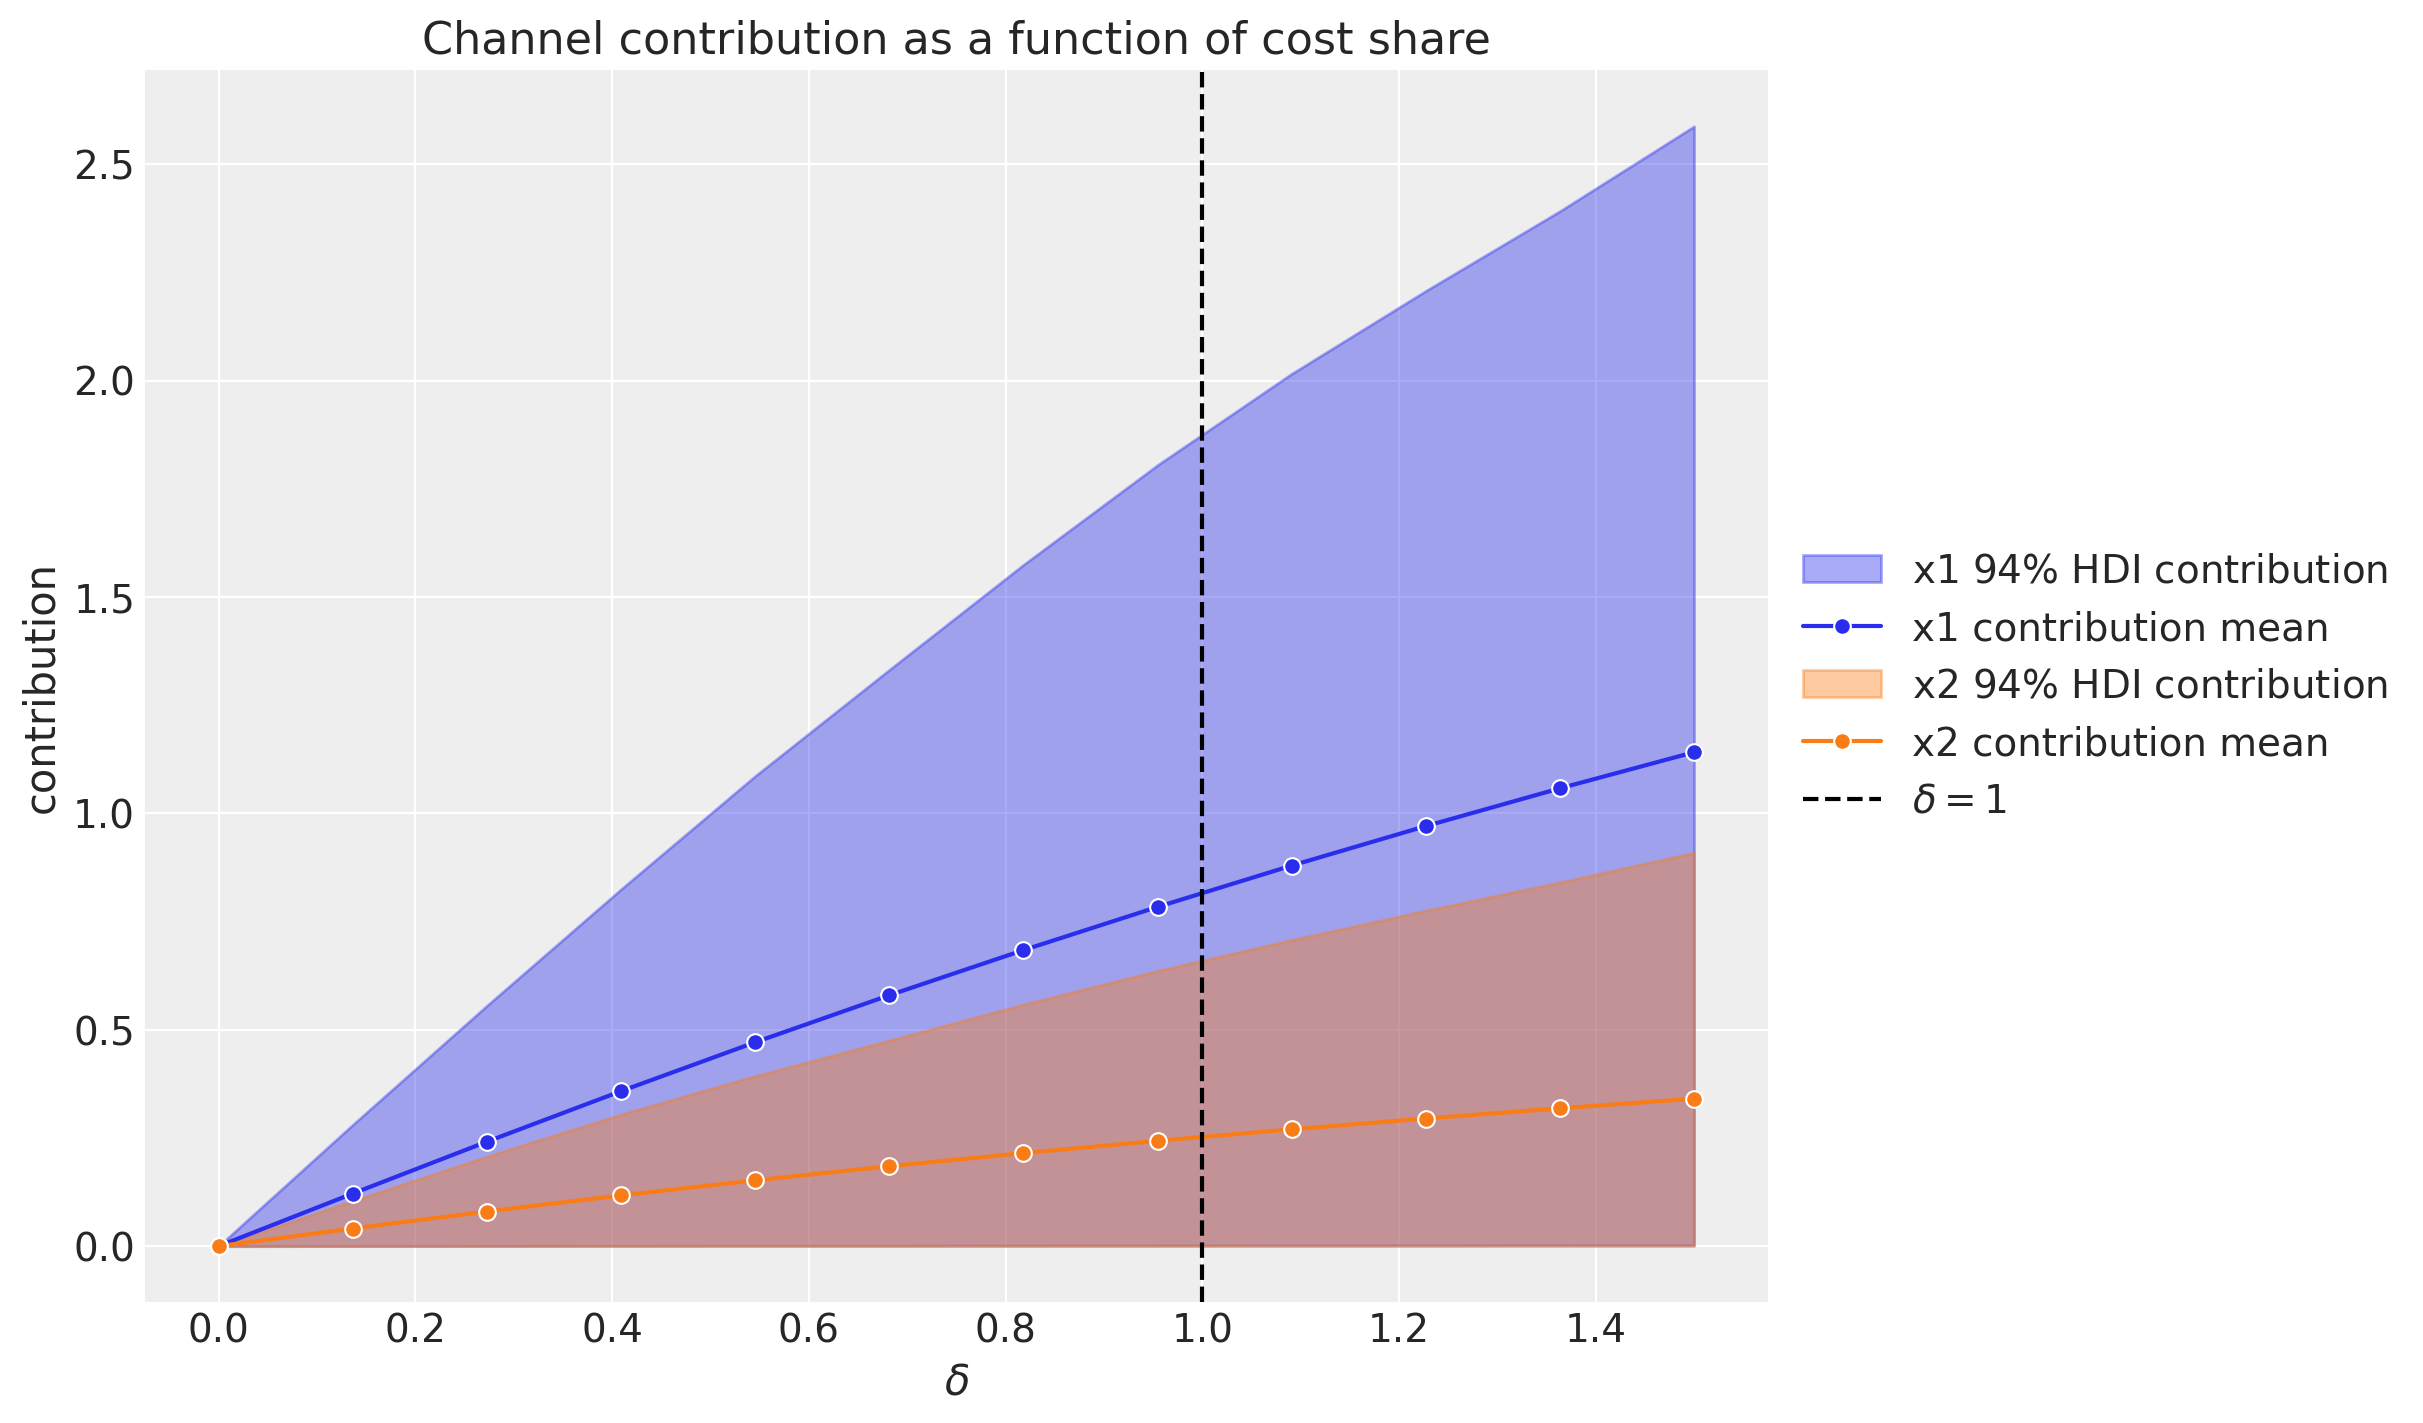

In [49]:
mmm.plot_channel_contributions_grid(start=0, stop=1.5, num=12);

- This plot does account for carryover (adstock) and saturation effects.
- We see that when we have no spend, the contribution is zero (assuming there twas no spend in the past, otherwise the carryover effect would be non-zero).

Observe that these grid values serve as inputs for an optimization step.

We can also plot the same contribution using the x-axis as the total channel input (e.g. total spend in EUR).

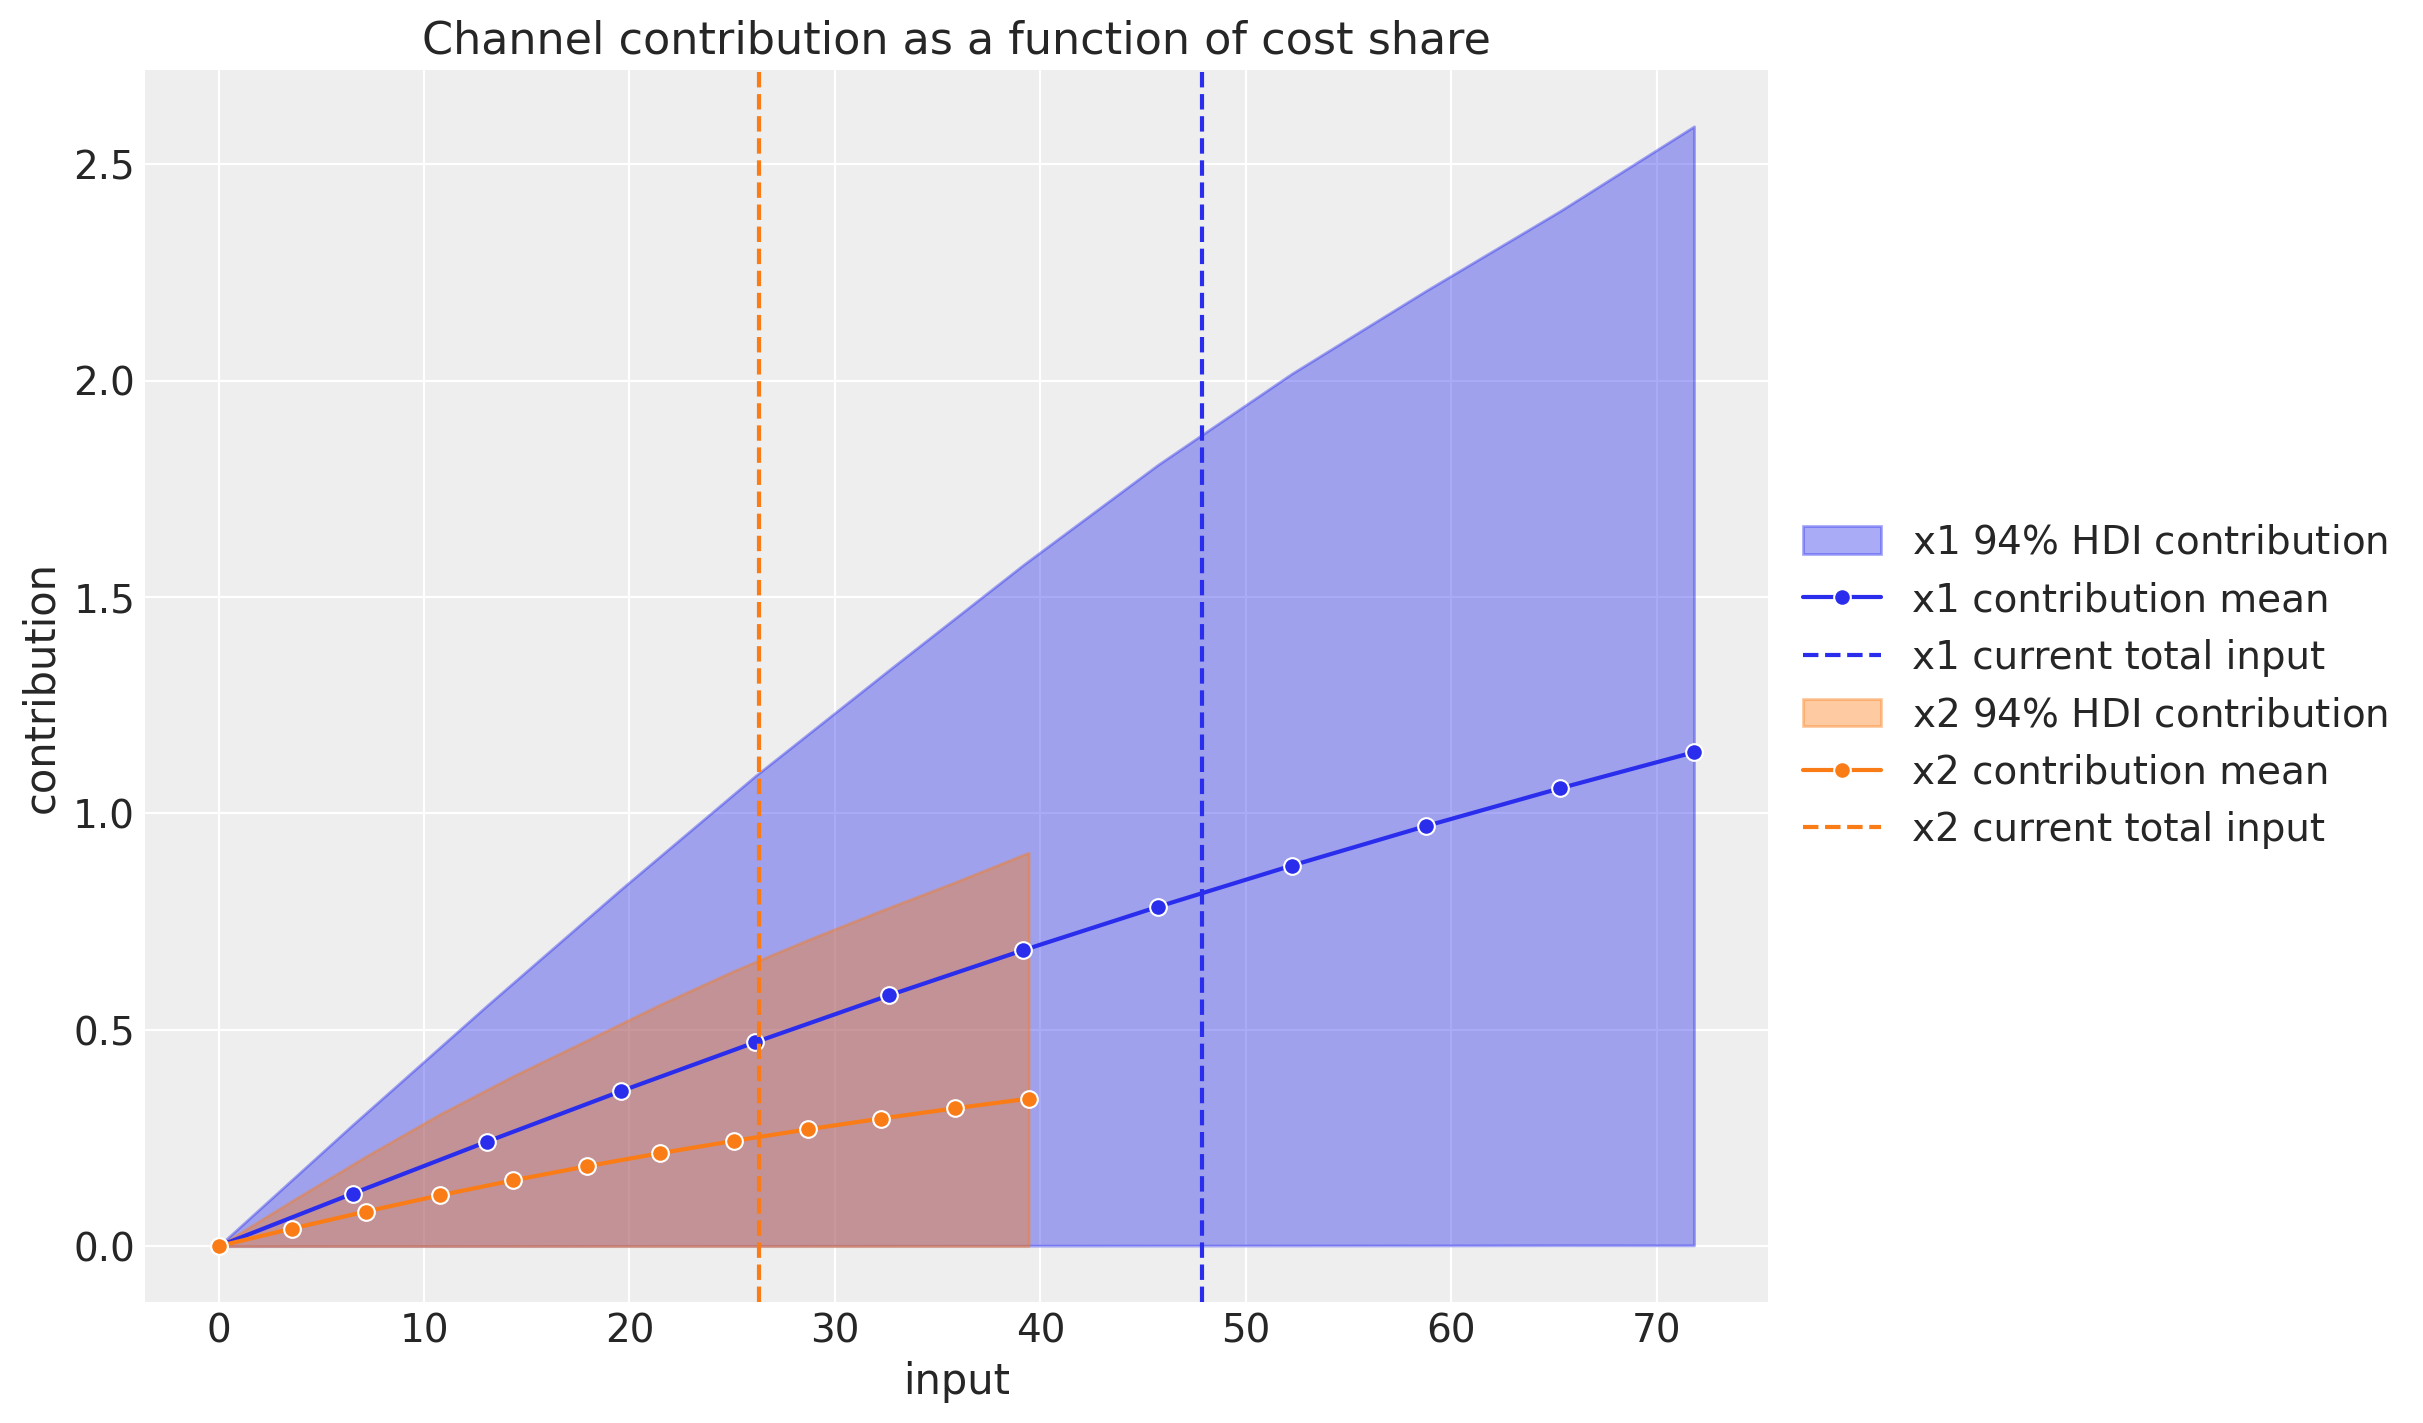

In [50]:
mmm.plot_channel_contributions_grid(start=0, stop=1.5, num=12, absolute_xrange=True);

## 7. Contribution  Recovery

Next, we can plot the direct contribution of each channel to the target variable over time.

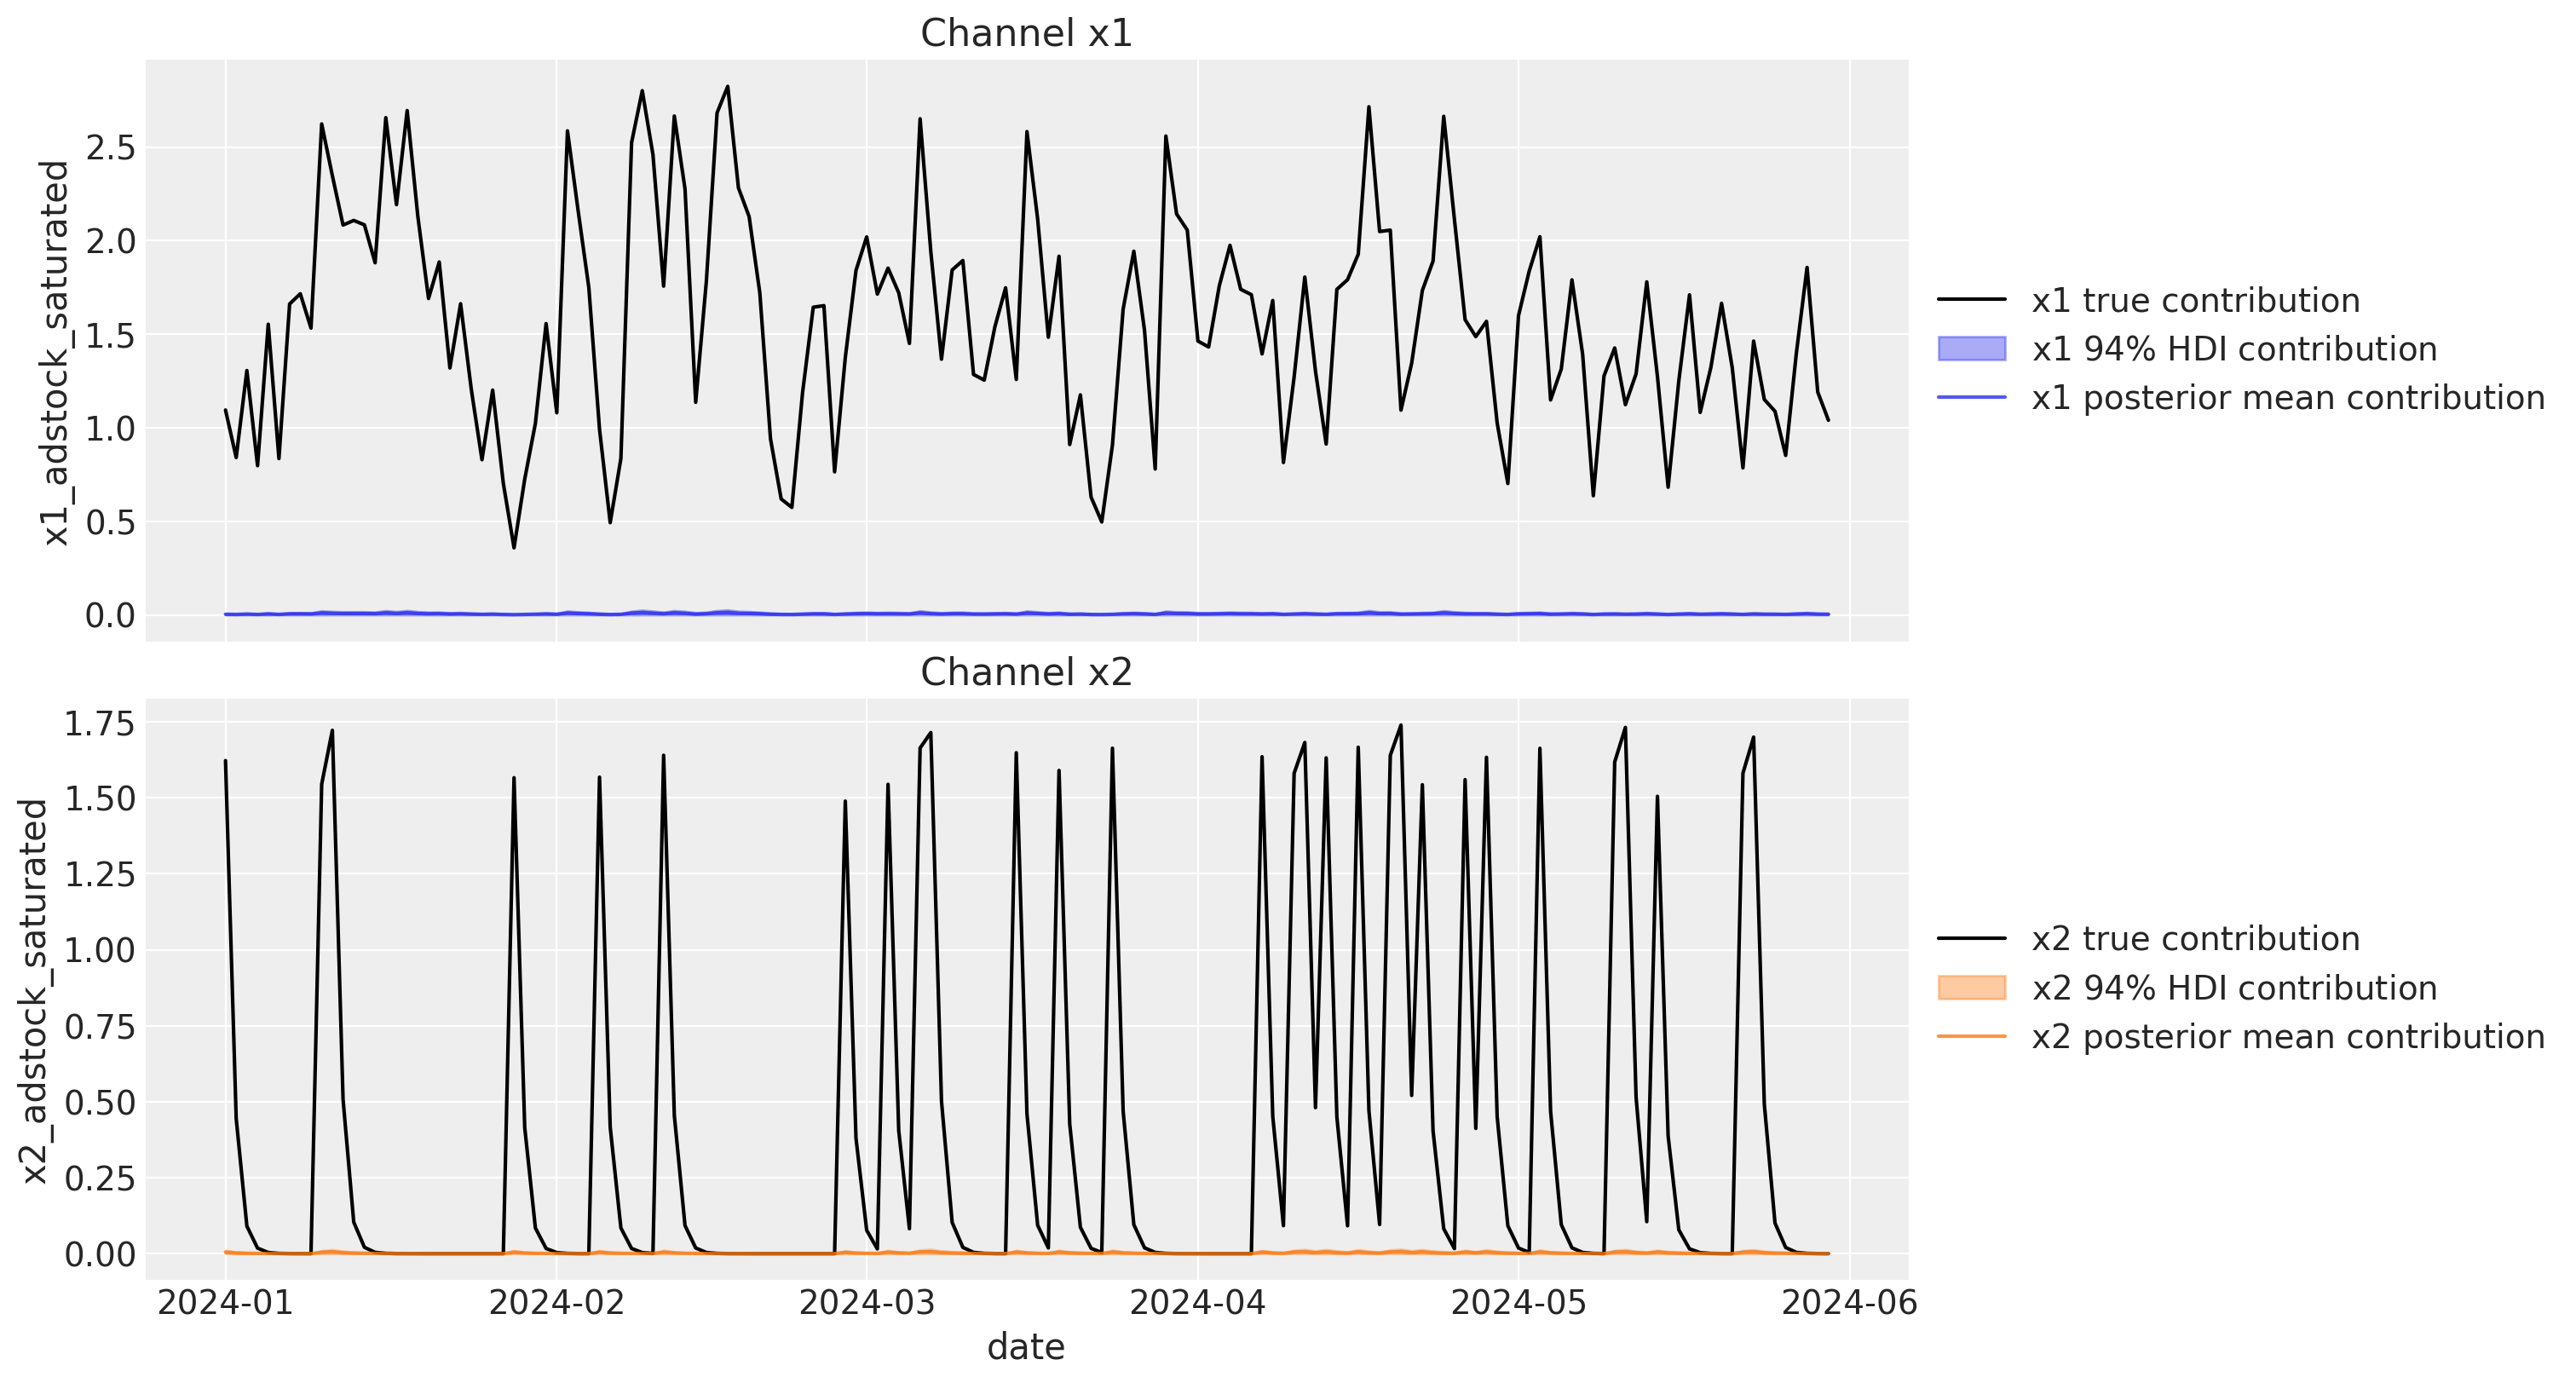

In [51]:
channels_contribution_original_scale = mmm.compute_channel_contribution_original_scale()
channels_contribution_original_scale_hdi = az.hdi(
    ary=channels_contribution_original_scale
)

fig, ax = plt.subplots(
    nrows=2, figsize=(15, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

for i, x in enumerate(["x1", "x2"]):
    # Estimate true contribution in the original scale from the data generating process
    sns.lineplot(
        x=df["date"],
        y=amplitude * betas[i] * df[f"{x}_adstock_saturated"],
        color="black",
        label=f"{x} true contribution",
        ax=ax[i],
    )
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=df["date"],
        y1=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 0],
        y2=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 1],
        color=f"C{i}",
        label=rf"{x} $94\%$ HDI contribution",
        alpha=0.4,
    )
    # Mean estimated contribution in the original scale
    sns.lineplot(
        x=df["date"],
        y=get_mean_contributions_over_time_df[x].to_numpy(),
        color=f"C{i}",
        label=f"{x} posterior mean contribution",
        alpha=0.8,
        ax=ax[i],
    )
    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")

The results look great! We therefore successfully recovered the true values from the data generation process. We have also seen how easy is to use the {class}`MMM <pymc_marketing.mmm.delayed_saturated_mmm.MMM>` class to fit media mix models! It takes over the model specification and the media transformations, while having all the flexibility of `pymc`!

## 8. ROAS

Finally, we can compute the (approximate) ROAS posterior distribution for each channel.

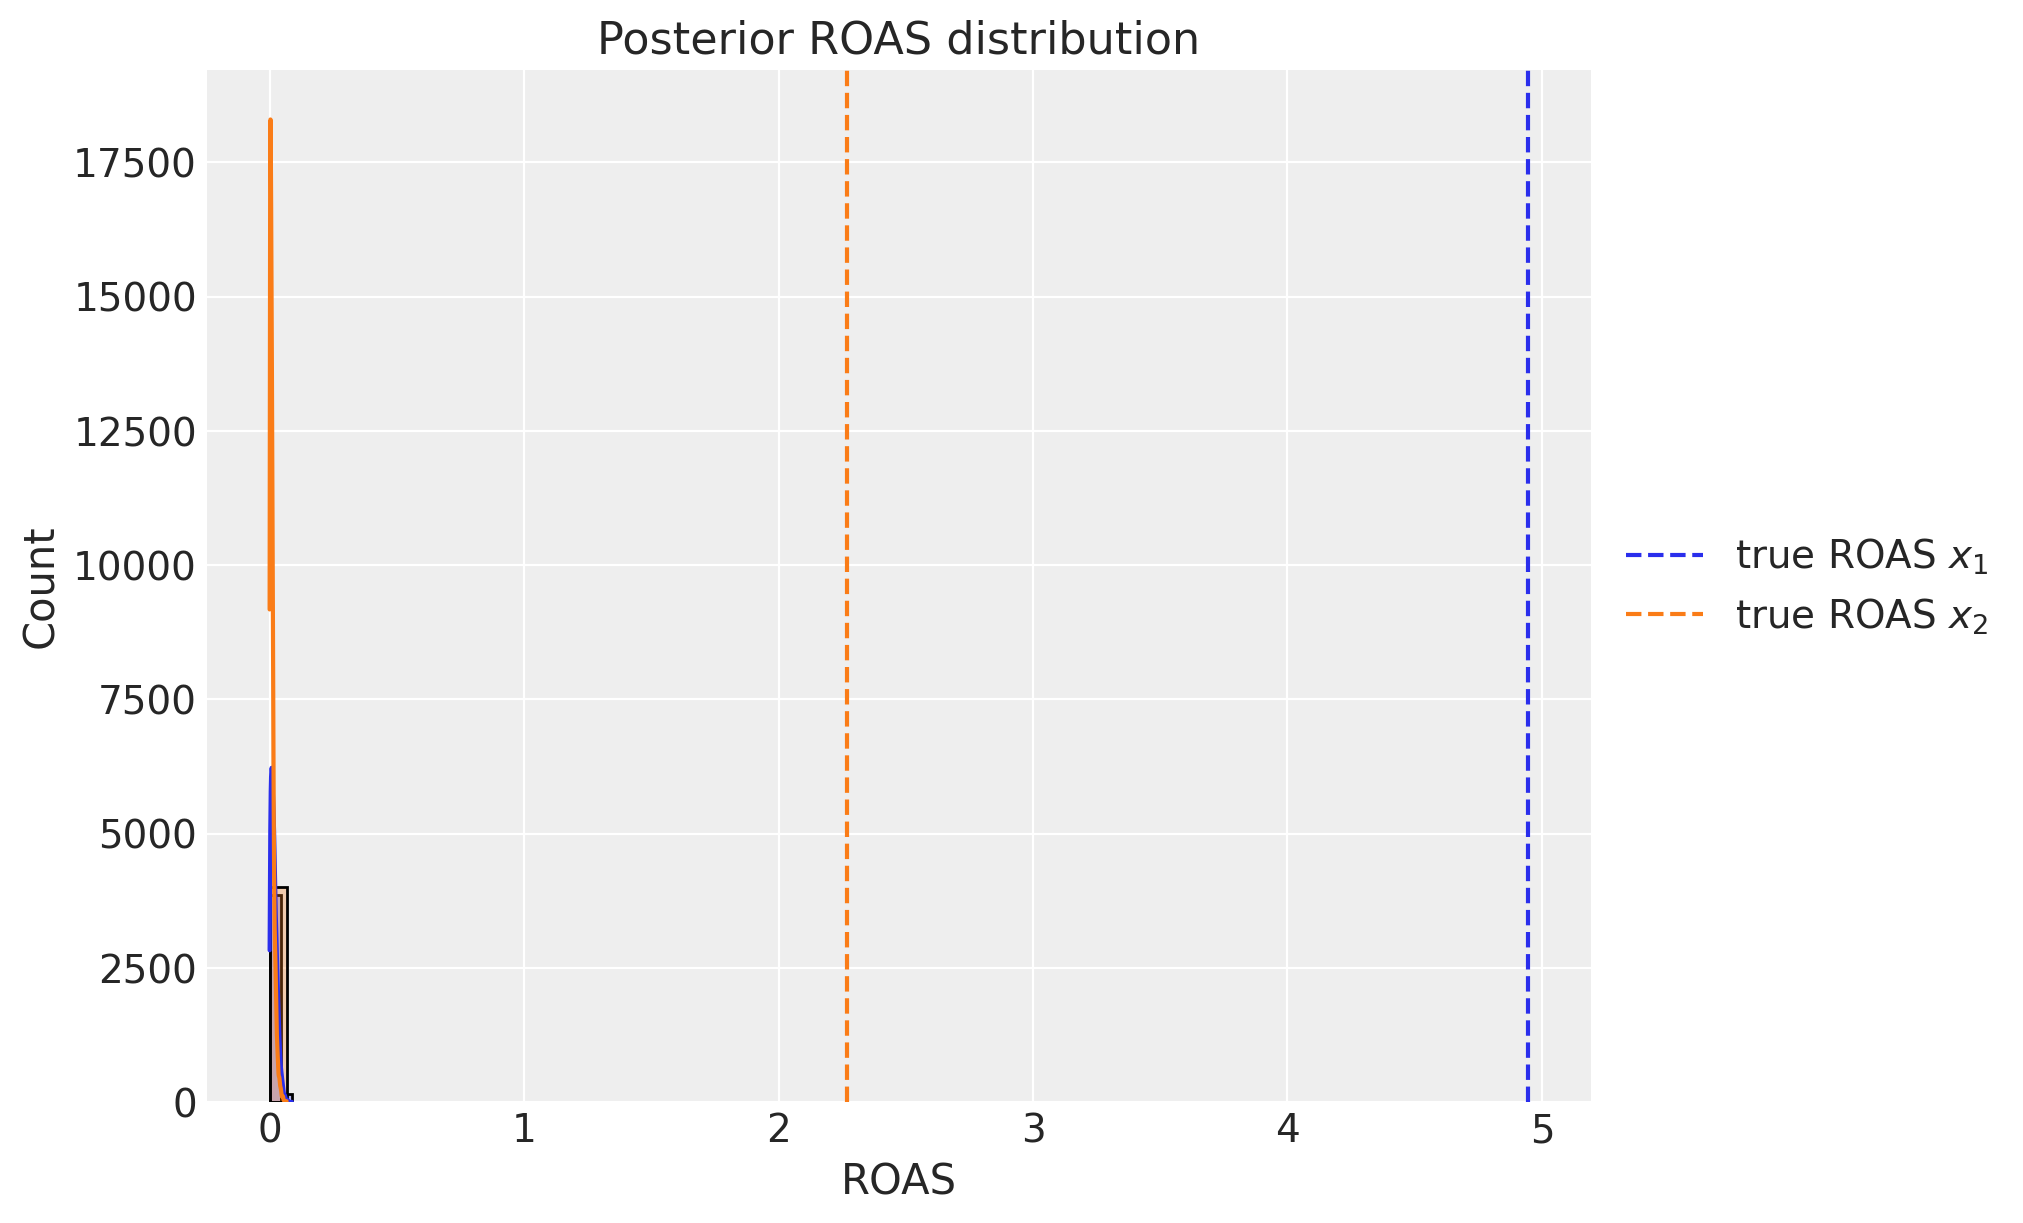

In [52]:
channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()

roas_samples = (
    channel_contribution_original_scale.stack(sample=("chain", "draw")).sum("date")
    / data[["x1", "x2"]].sum().to_numpy()[..., None]
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    roas_samples.sel(channel="x1").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax
)
sns.histplot(
    roas_samples.sel(channel="x2").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax
)
ax.axvline(x=roas_1, color="C0", linestyle="--", label=r"true ROAS $x_{1}$")
ax.axvline(x=roas_2, color="C1", linestyle="--", label=r"true ROAS $x_{2}$")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS");

We see that the ROAS posterior distributions are centered around the true values! We also see that, even considering the uncertainty, channel $x_{1}$ is more efficient than channel $x_{2}$. 

## 9. Out of Sample Predictions

Out of sample predictions are done with the `predict` and `posterior_predictive` methods. These include 

- `sample_posterior_predictive` : Get the full posterior predictive distribution
- `predict`: Get the mean of the posterior predictive distribution

These methods take new data, `X_pred`, and some additional `kwargs` for new predictions. Namely, 

- `include_last_observations` : boolean flag in order to carry adstock effects from last observations in the training dataset

The new data needs to have all the features that are specified in the model. There is no need to worry about: 

- input scaling of channel spends or control features
- creating fourier transformations on the `date_column`
- inverse scaling back to target domain

That will be done automatically!

In [94]:
last_date = X["date"].max()

# New dates starting from last in dataset
n_new = 5
new_dates = pd.date_range(start=last_date, periods=1 + n_new, freq="D")[1:]

X_out_of_sample = pd.DataFrame(
    {
        "date": new_dates,
    }
)

# Same channel spends as last day
X_out_of_sample["x1"] = X["x1"].iloc[-1]
X_out_of_sample["x2"] = X["x2"].iloc[-1]

# Other features
X_out_of_sample["event_1"] = 0
X_out_of_sample["event_2"] = 0

X_out_of_sample["t"] = range(len(X), len(X) + n_new)

X_out_of_sample = add_dayofweek(X_out_of_sample)

Call the desired method to get the new samples! The new coordinates will be from the new dates

In [95]:
X_out_of_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5 non-null      datetime64[ns]
 1   x1           5 non-null      float64       
 2   x2           5 non-null      float64       
 3   event_1      5 non-null      int64         
 4   event_2      5 non-null      int64         
 5   t            5 non-null      int64         
 6   dayofweek    5 non-null      int32         
 7   dayofweek_0  5 non-null      int64         
 8   dayofweek_1  5 non-null      int64         
 9   dayofweek_2  5 non-null      int64         
 10  dayofweek_3  5 non-null      int64         
 11  dayofweek_4  5 non-null      int64         
 12  dayofweek_5  5 non-null      int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(9)
memory usage: 632.0 bytes


In [96]:
y_out_of_sample = mmm.sample_posterior_predictive(
    X_pred=X_out_of_sample, extend_idata=False
)

y_out_of_sample

Sampling: [y]


Output()

<xarray.Dataset> Size: 256kB
Dimensions:  (date: 5, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 40B 2024-05-31 2024-06-01 ... 2024-06-04
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 160kB 1.74 1.718 1.724 ... 1.768 1.739 1.757
Attributes:
    created_at:                 2024-06-17T15:15:26.603240+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1

**NOTE:** If the method is being called **multiple times**, set the `extend_idata` argument to False in order to not overwrite the `observed_data` in the `InferenceData`

The new predictions are transformed back to the original scale of the target by default. That can be seen below: 

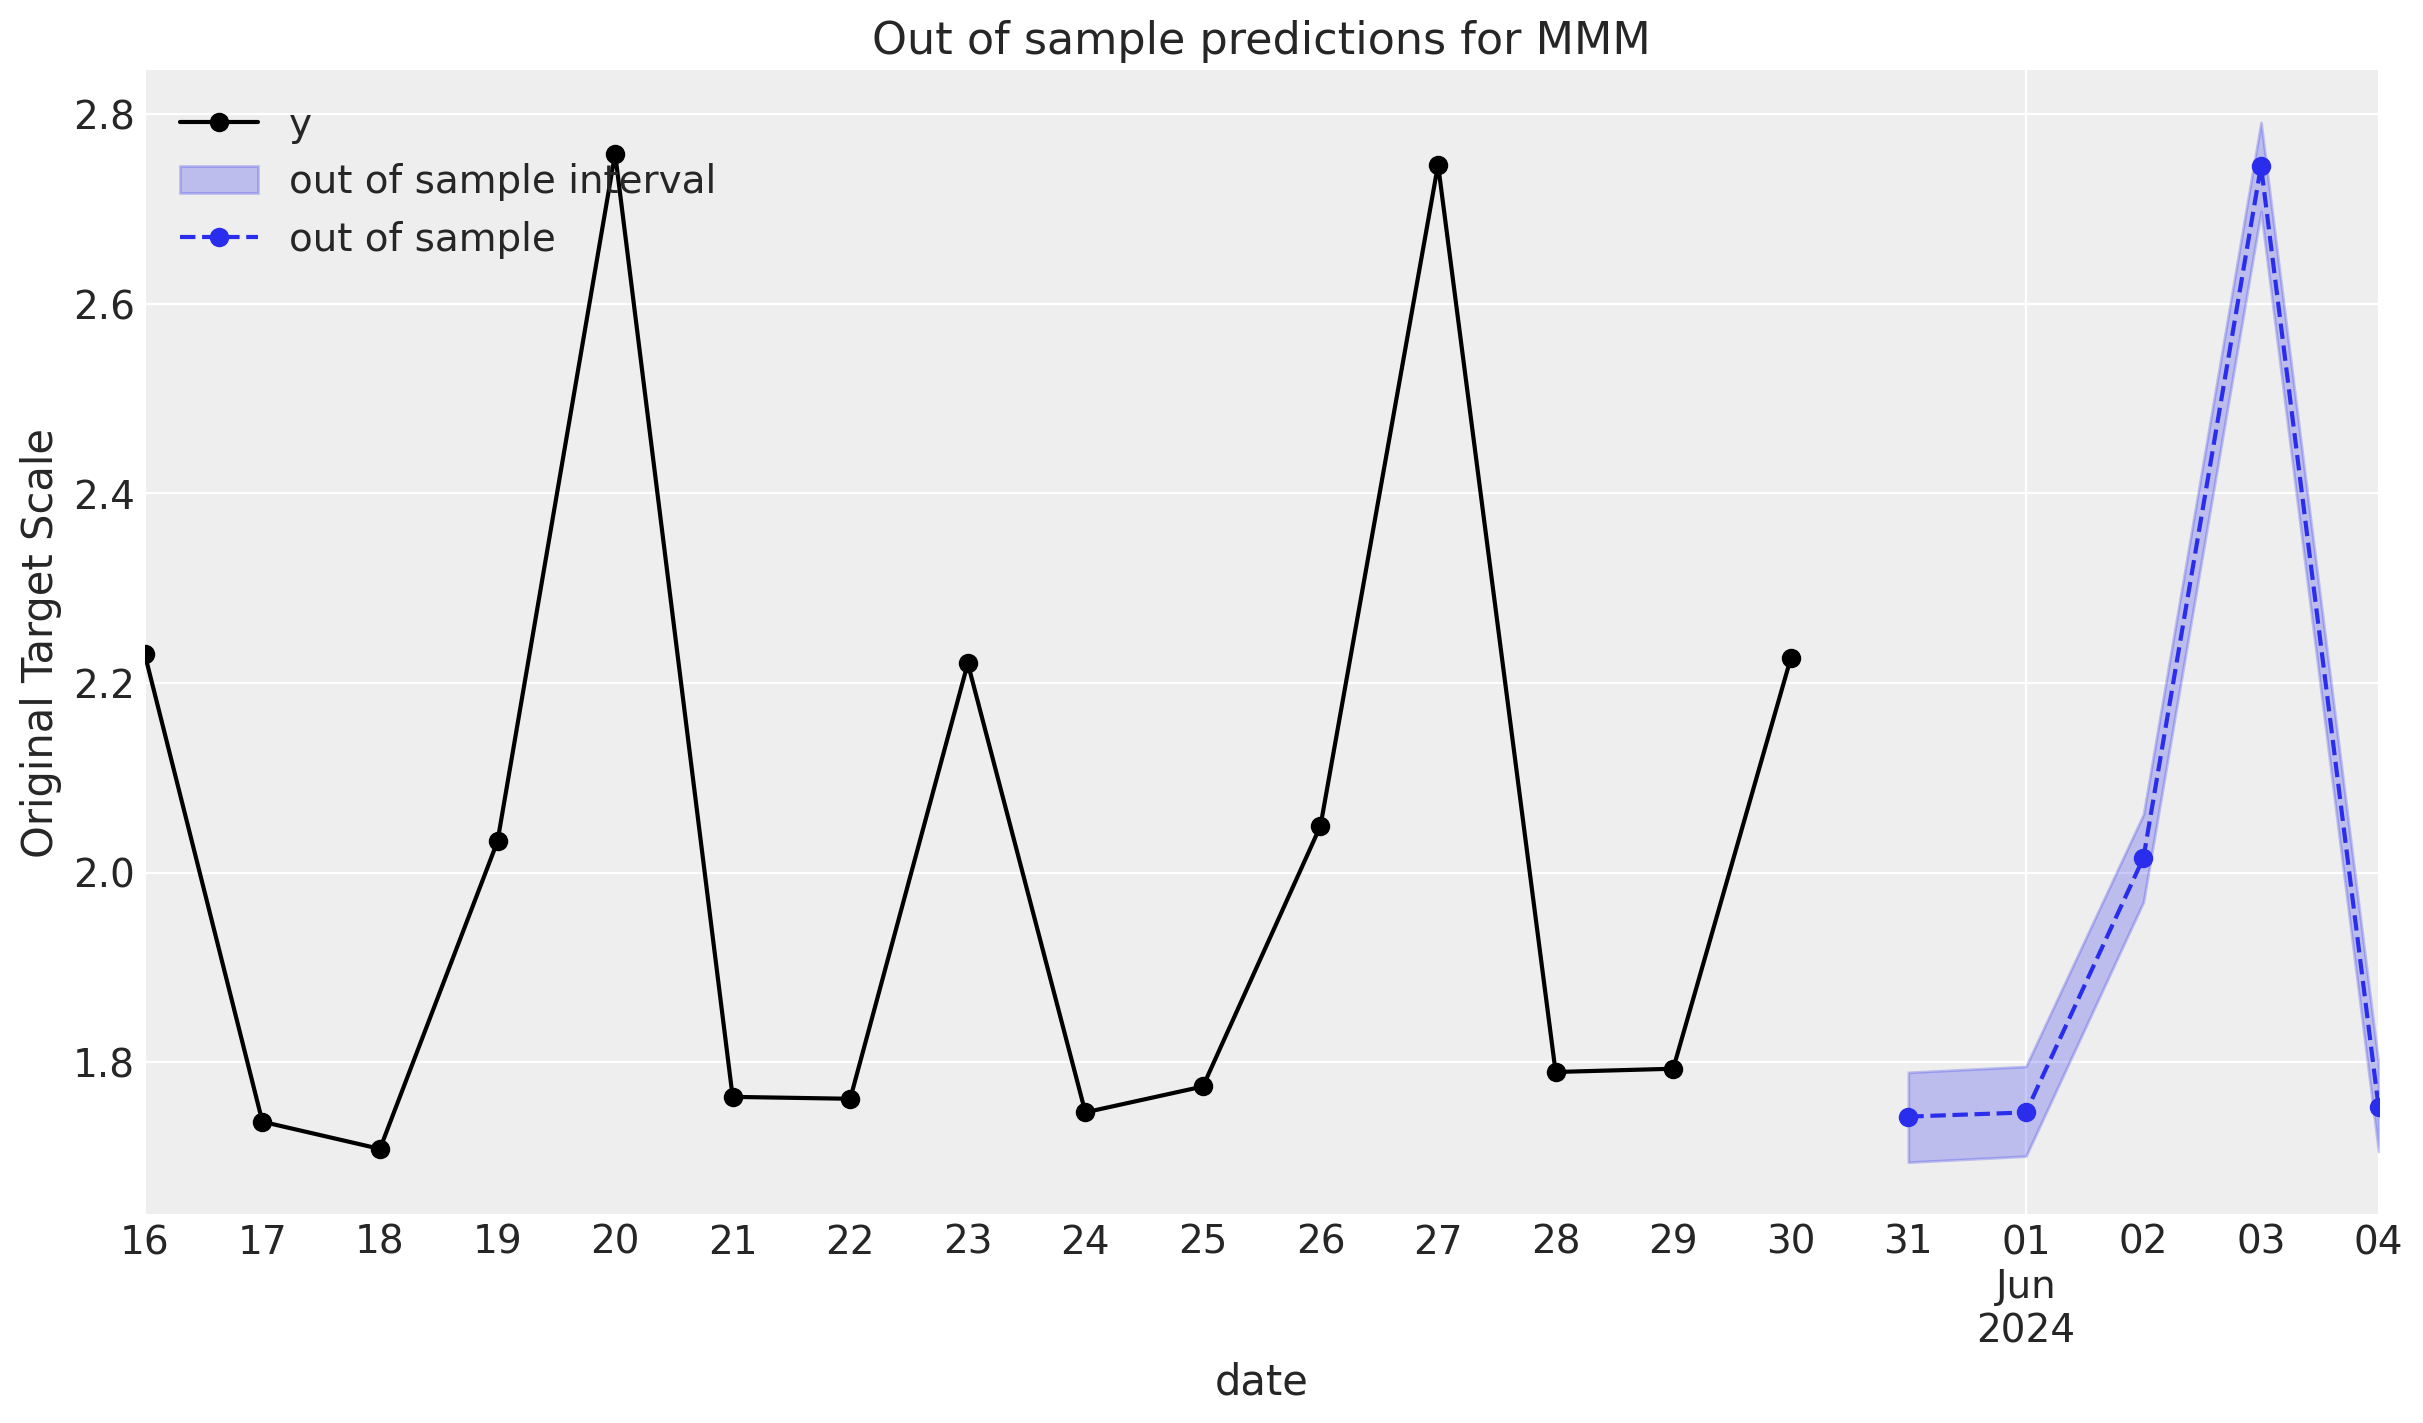

In [97]:
def plot_in_sample(X, y, ax, n_points: int = 15):
    (
        y.to_frame()
        .set_index(X["date"])
        .iloc[-n_points:]
        .plot(ax=ax, marker="o", color="black", label="actuals")
    )
    return ax


def plot_out_of_sample(X_out_of_sample, y_out_of_sample, ax, color, label):
    y_out_of_sample_groupby = y_out_of_sample["y"].to_series().groupby("date")

    lower, upper = quantiles = [0.025, 0.975]
    conf = y_out_of_sample_groupby.quantile(quantiles).unstack()
    ax.fill_between(
        X_out_of_sample["date"].dt.to_pydatetime(),
        conf[lower],
        conf[upper],
        alpha=0.25,
        color=color,
        label=f"{label} interval",
    )

    mean = y_out_of_sample_groupby.mean()
    mean.plot(ax=ax, marker="o", label=label, color=color, linestyle="--")
    ax.set(ylabel="Original Target Scale", title="Out of sample predictions for MMM")
    return ax


_, ax = plt.subplots()
plot_in_sample(X, y, ax=ax)
plot_out_of_sample(
    X_out_of_sample, y_out_of_sample, ax=ax, label="out of sample", color="C0"
)
ax.legend(loc="upper left");

If the out of sample data is being extended from the original predictions, consider setting the `include_last_observations` to True in order to carry over the effects from the last channel spends in the training set. 

The predictions are higher since the channel contributions the final spends still have an impact that eventually subside.

In [98]:
y_out_of_sample_with_adstock = mmm.sample_posterior_predictive(
    X_pred=X_out_of_sample, extend_idata=False, include_last_observations=True
)

Sampling: [y]


Output()

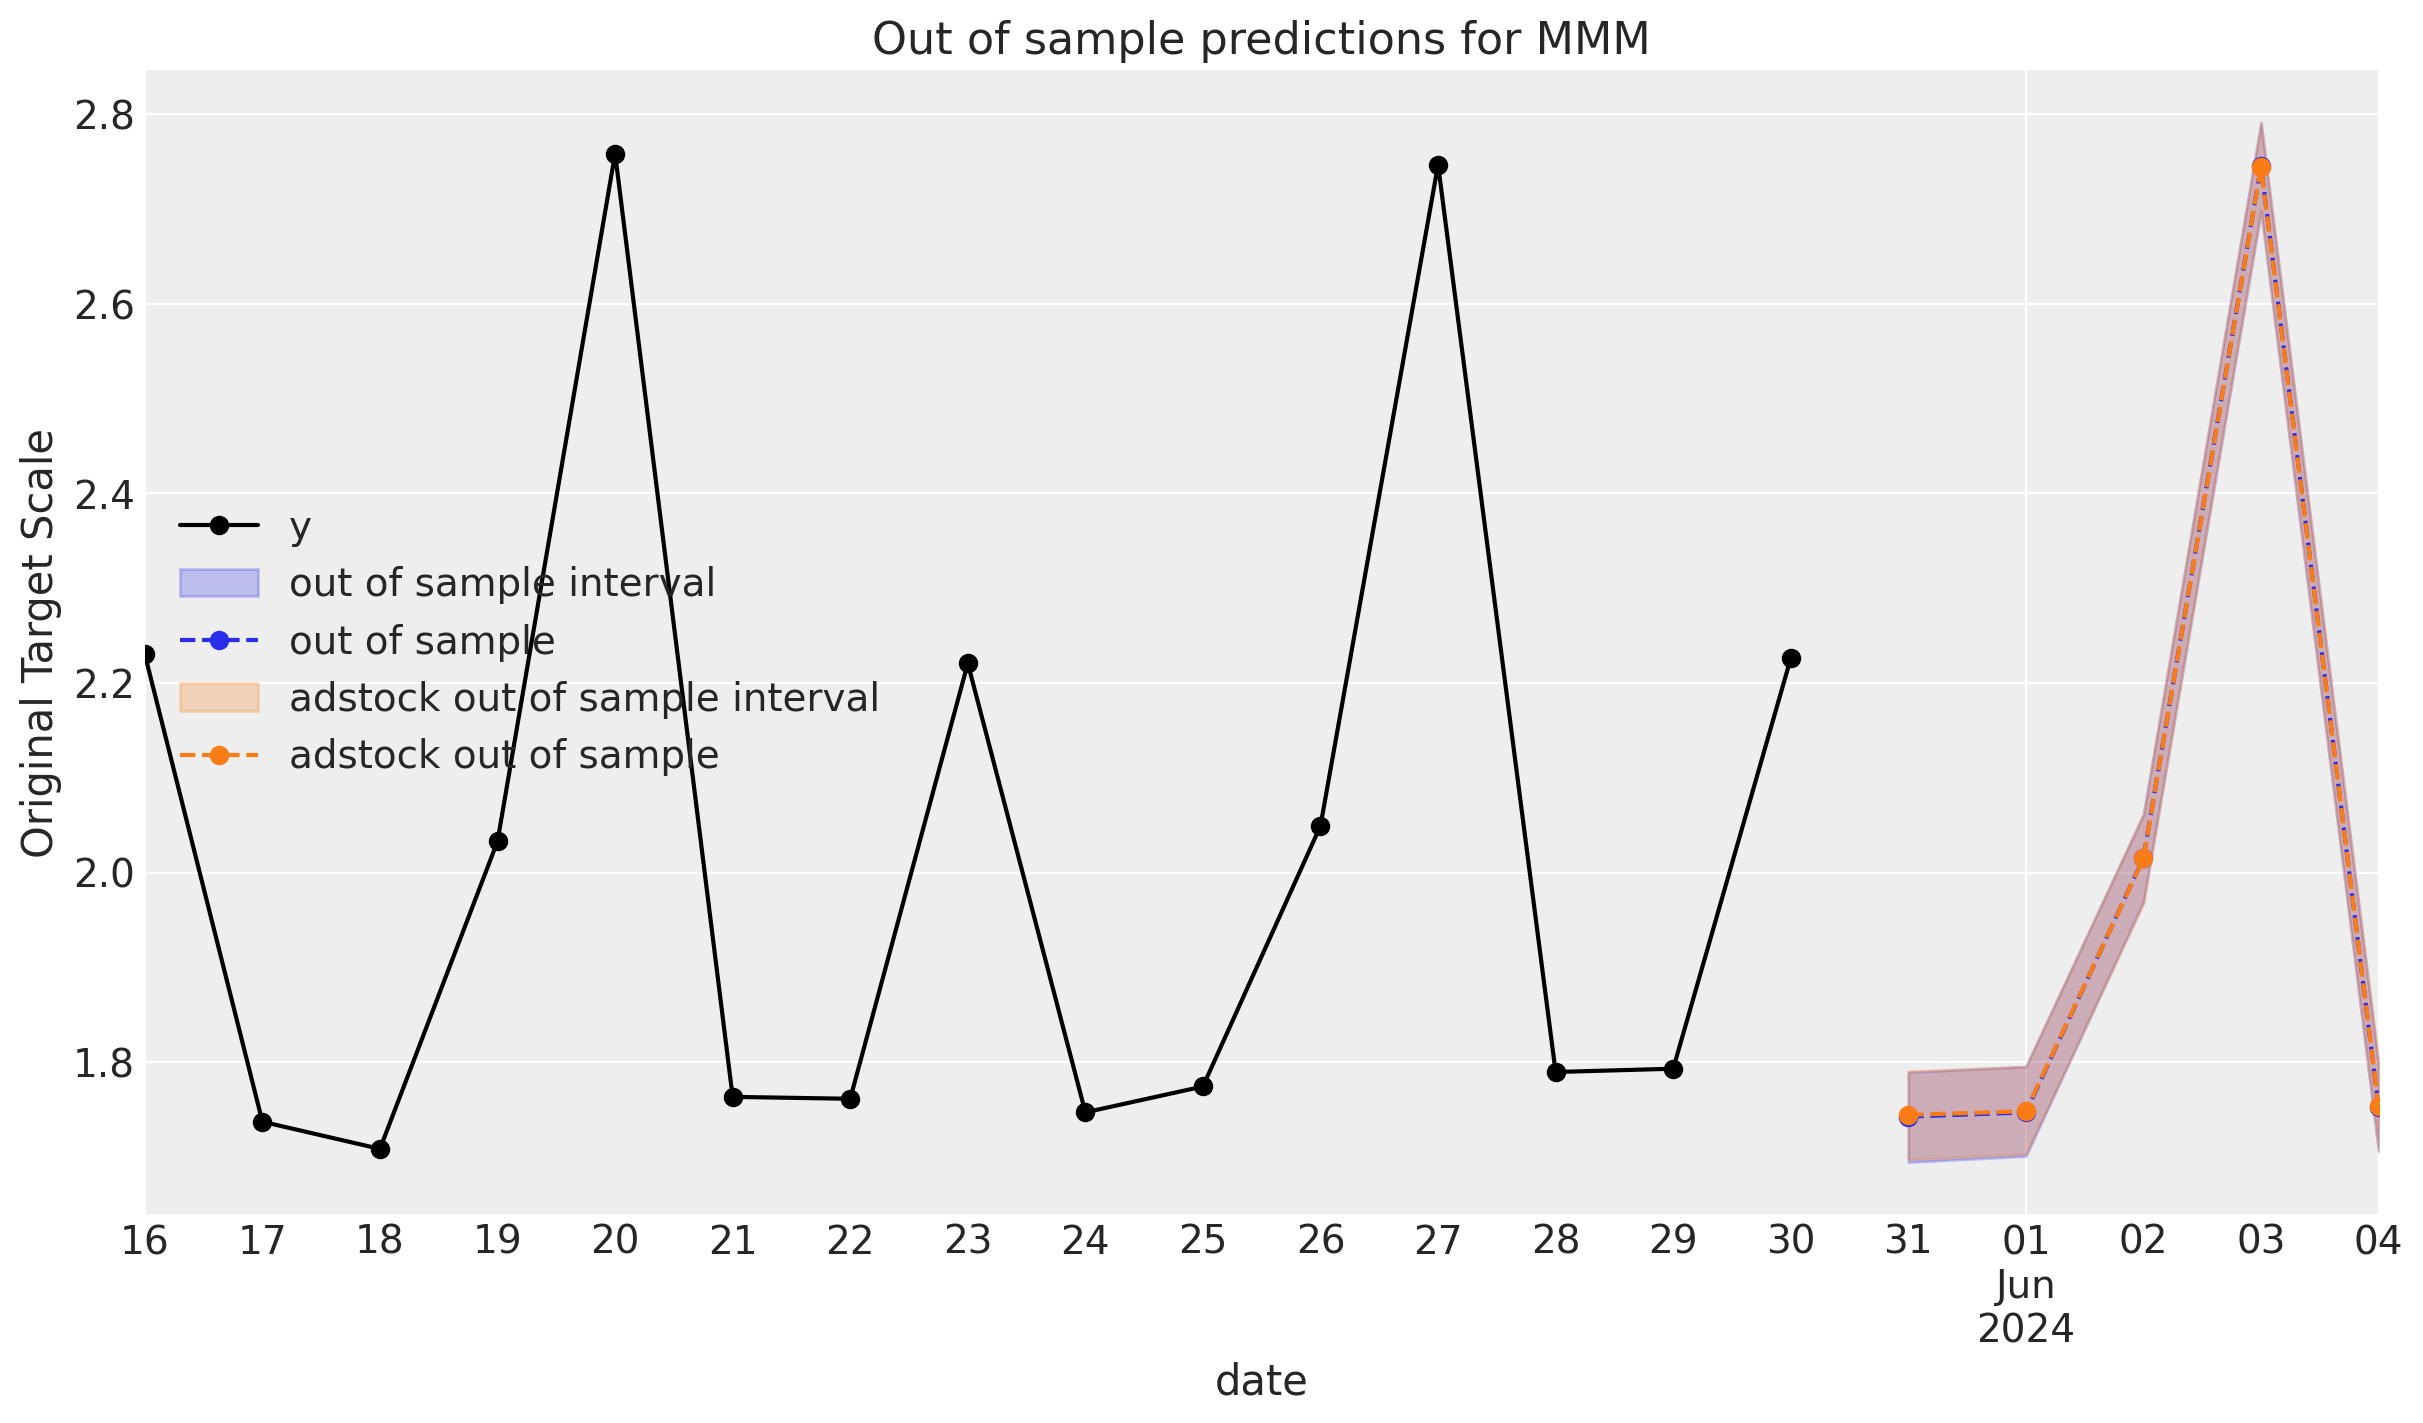

In [99]:
_, ax = plt.subplots()
plot_in_sample(X, y, ax=ax)
plot_out_of_sample(
    X_out_of_sample, y_out_of_sample, ax=ax, label="out of sample", color="C0"
)
plot_out_of_sample(
    X_out_of_sample,
    y_out_of_sample_with_adstock,
    ax=ax,
    label="adstock out of sample",
    color="C1",
)
ax.legend();

Finally we can use the model to understand the expected sales for different media spend scenarios considering the adstock and saturation effects learned from the data.

Sampling: []
Sampling: []
Sampling: []
Sampling: []


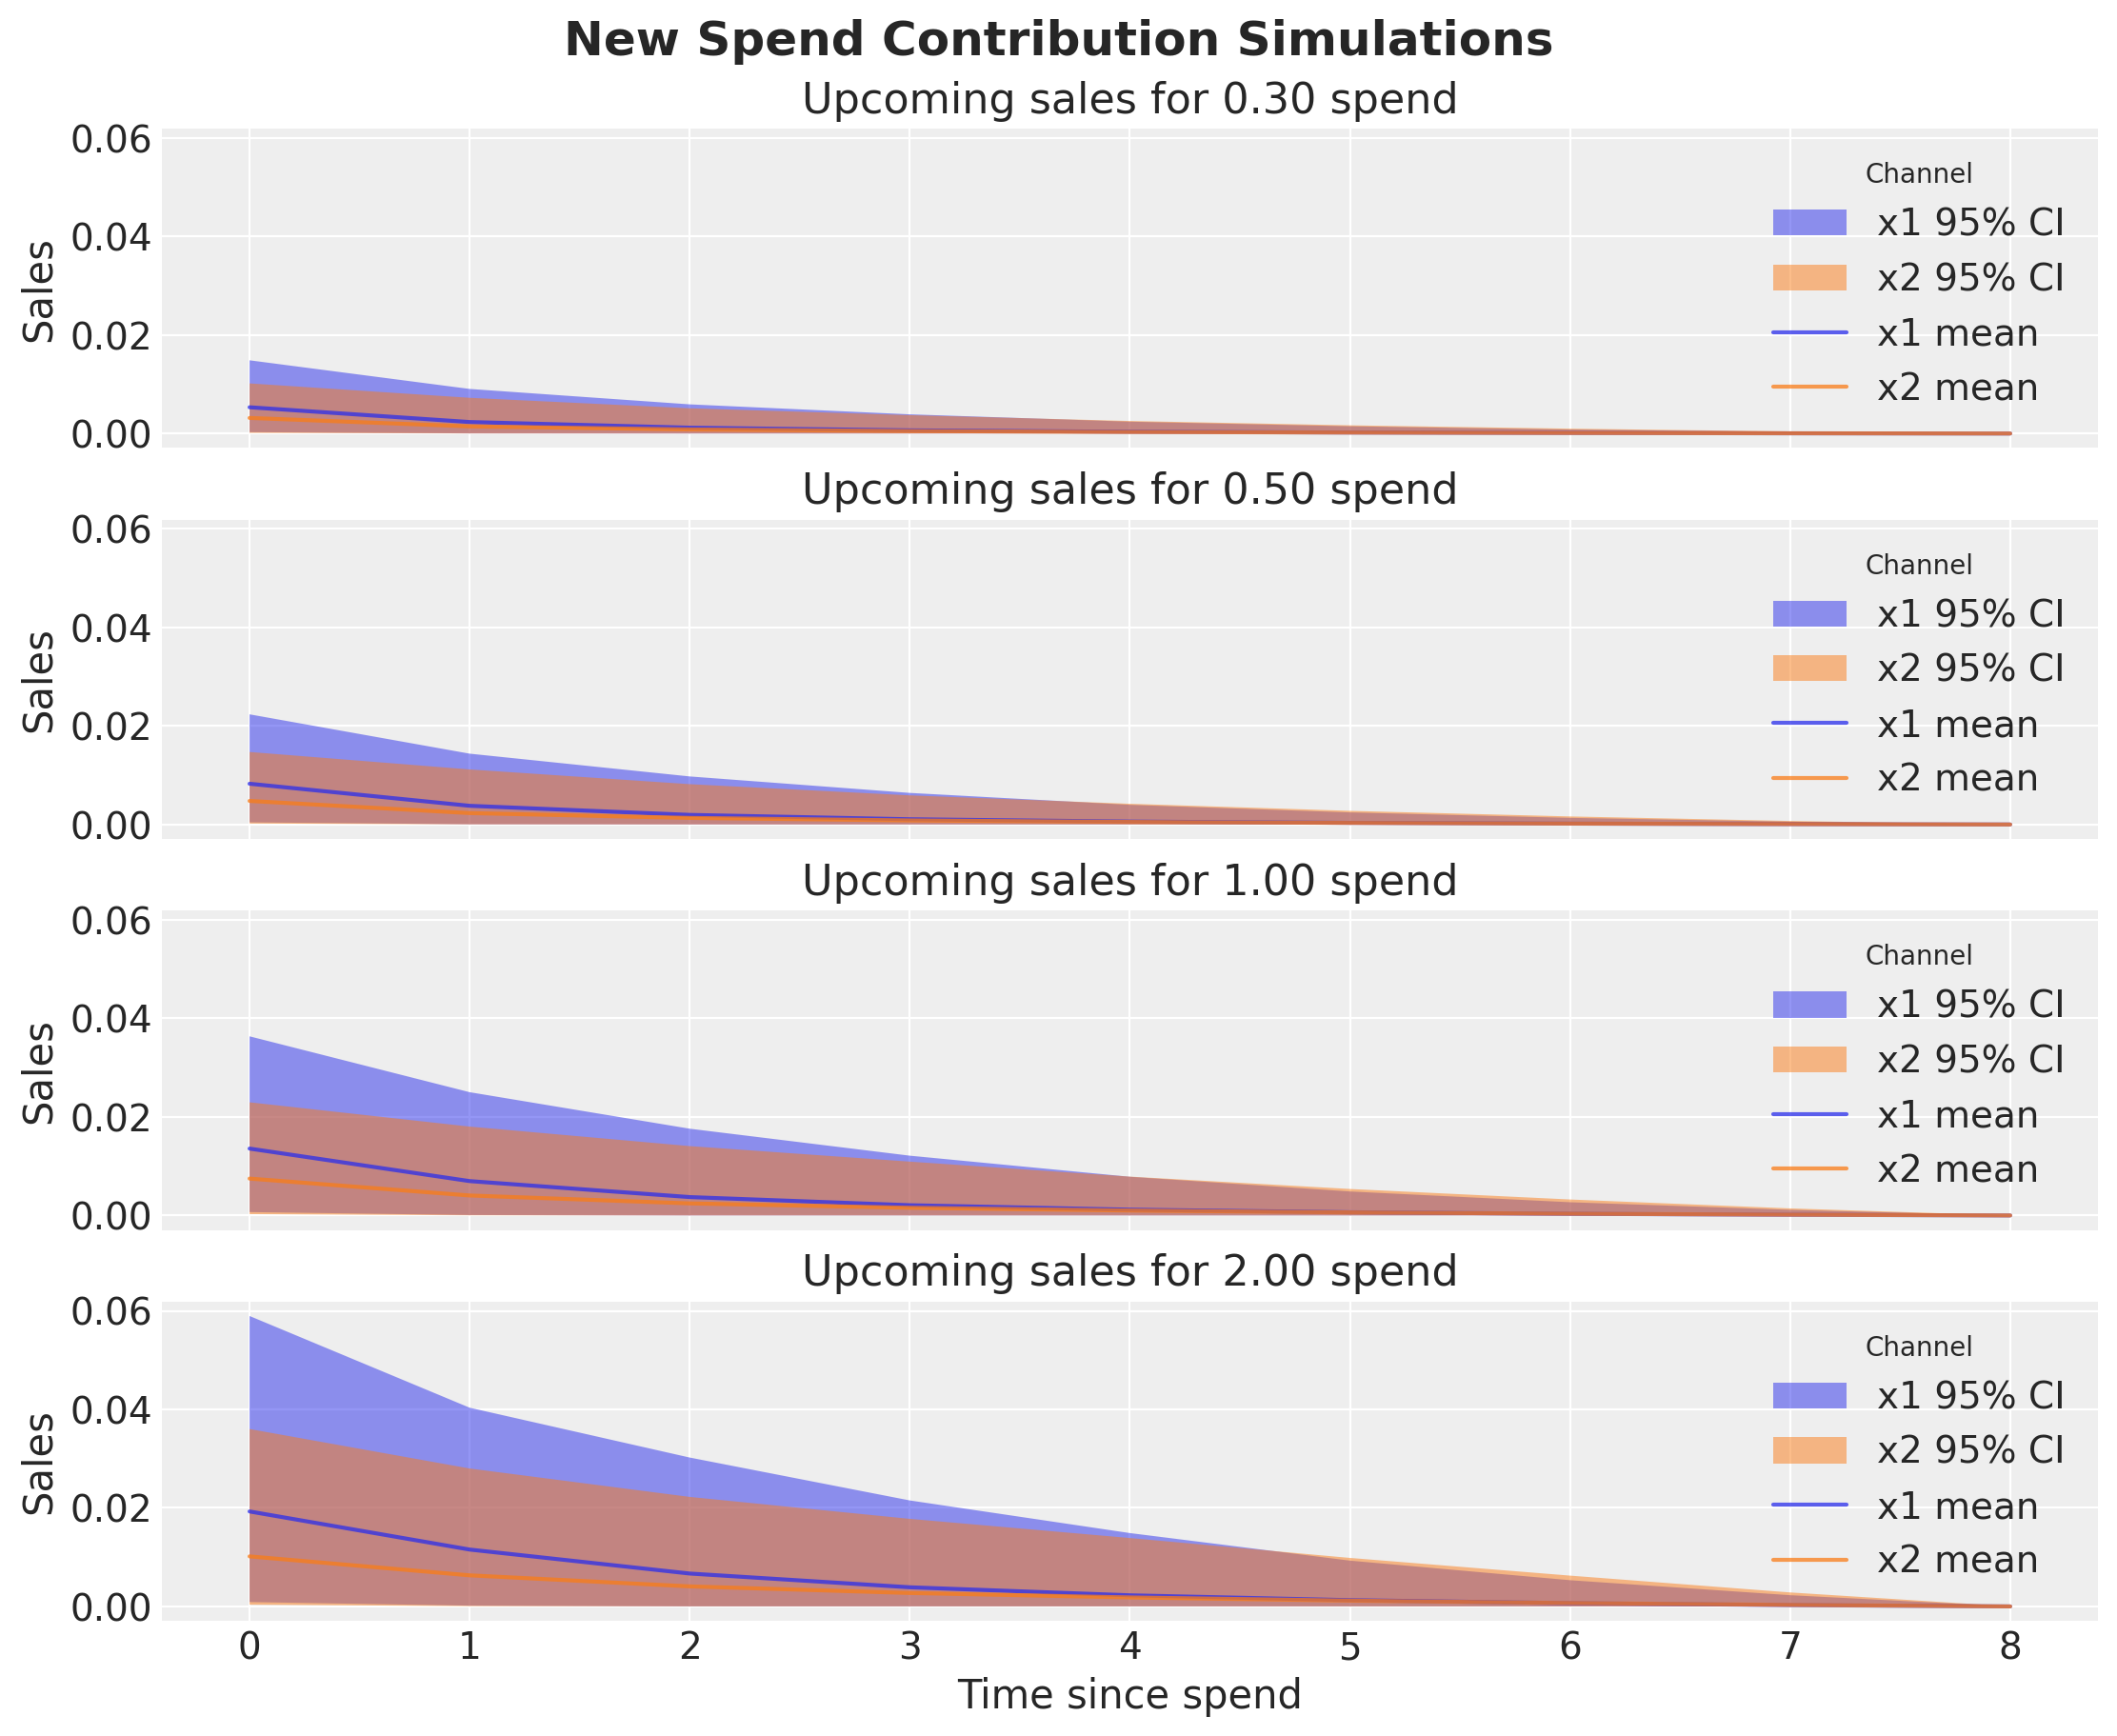

In [59]:
spends = [0.3, 0.5, 1, 2]

fig, axes = plt.subplots(
    nrows=len(spends),
    ncols=1,
    figsize=(11, 9),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for ax, spend in zip(axes, spends, strict=True):
    mmm.plot_new_spend_contributions(spend_amount=spend, progressbar=False, ax=ax)

fig.suptitle("New Spend Contribution Simulations", fontsize=18, fontweight="bold");

We clearly see that since $x_1$ has a higher adstock parameter $\alpha$ than $x_2$, then for new spend on a single date (i.e. `one_time`) 
$x_1$ has larger delayed contributions than $x_2$.

## 10. Save Model
After your model is train, you can quickly save it using the `save` method.

In [60]:
mmm.save("model.nc")